# Data Processing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
user = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Info_UserData.csv")
course = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Info_Content.csv")
log = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Log_Problem.csv")
#merge files for better readability
df = log.merge(user, how='left', on='uuid')
df = df.merge(course, how='left', on='ucid')
#df.to_csv("/content/drive/My Drive/Colab Notebooks/complete_merged_dataset.csv")
#df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/complete_merged_dataset.csv").drop(columns=['Unnamed: 0'])

Mounted at /content/drive


In [ ]:
# Filter for users where the count is greater than 10
upid_counts = df.groupby('uuid')['upid'].count()
users_with_more_than_10_upid = upid_counts[upid_counts > 10]
number_of_users = len(users_with_more_than_10_upid)
uuids_to_filter = users_with_more_than_10_upid.index.tolist()
df_filtered = df[df['uuid'].isin(uuids_to_filter)]
df = df_filtered

In [ ]:
'''
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for unique values to spot potential outliers (for categorical/discrete data)
print("\nUnique values per column (first 10):")
for col in df.columns:
  if df[col].dtype in ['object', 'category', 'int64']: # Check for non-numeric types and integers
    print(f"{col}: {df[col].unique()[:10]}") # Print only first 10 unique values for brevity

# Check for outliers using descriptive statistics (for numerical data)
print("\nDescriptive statistics (for numerical columns to spot outliers):")
print(df.describe())

# A more sophisticated outlier detection for numerical data (using IQR)
print("\nPotential outliers based on IQR (for numerical columns):")
for col in df.select_dtypes(include=np.number).columns:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  if not outliers.empty:
    print(f"Column '{col}' has {len(outliers)} potential outliers.")
    #print(outliers[[col]]) # Uncomment to see the outlier values
'''

'\n# Check for missing values\nprint("Missing values per column:")\nprint(df.isnull().sum())\n\n# Check for unique values to spot potential outliers (for categorical/discrete data)\nprint("\nUnique values per column (first 10):")\nfor col in df.columns:\n  if df[col].dtype in [\'object\', \'category\', \'int64\']: # Check for non-numeric types and integers\n    print(f"{col}: {df[col].unique()[:10]}") # Print only first 10 unique values for brevity\n\n# Check for outliers using descriptive statistics (for numerical data)\nprint("\nDescriptive statistics (for numerical columns to spot outliers):")\nprint(df.describe())\n\n# A more sophisticated outlier detection for numerical data (using IQR)\nprint("\nPotential outliers based on IQR (for numerical columns):")\nfor col in df.select_dtypes(include=np.number).columns:\n  Q1 = df[col].quantile(0.25)\n  Q3 = df[col].quantile(0.75)\n  IQR = Q3 - Q1\n  lower_bound = Q1 - 1.5 * IQR\n  upper_bound = Q3 + 1.5 * IQR\n  outliers = df[(df[col] < lo

In [ ]:
#df.dtypes

In [ ]:
#drop columns that will not be used
df = df.drop(columns=['content_pretty_name','level1_id','level2_id','level3_id'])

In [ ]:
#convert column to proper types
df['timestamp_TW'] = pd.to_datetime(df['timestamp_TW']).dt.tz_localize(None)
df['is_correct'] = df['is_correct'].astype('category')
df['is_hint_used'] = df['is_hint_used'].astype('category')
df['is_downgrade'] = df['is_downgrade'].astype('category')
df['is_upgrade'] = df['is_upgrade'].astype('category')
df['gender'] = df['gender'].astype('category')
df['first_login_date_TW'] = pd.to_datetime(df['first_login_date_TW'])
df['user_city'] = df['user_city'].astype('category')
df['is_self_coach'] = df['is_self_coach'].astype('category')
df['content_kind'] = df['content_kind'].astype('category')
df['difficulty'] = df['difficulty'].astype('category')
df['subject'] = df['subject'].astype('category')
df['learning_stage'] = df['learning_stage'].astype('category')

In [ ]:
#handle outliers for each column - numerical (https://developers.google.com/machine-learning/crash-course/numerical-data/normalization)
#user dataset contains columns: [gender, points, badges_cnt, first_login_date_TW, user_grade, user_city, has_teacher_cnt
# is_self_coach, has_studnt_cnt, belongs_to_class_cnt, has_class_cnt] which is the final state of the students
#content dataset contains columns: [content_pretty_name	content_kind	difficulty	subject	learning_stage	level1_id	level2_id	level3_id	level4_id]
from sklearn.preprocessing import MinMaxScaler
# Log-scaling
for col in ['problem_number', 'exercise_problem_repeat_session', 'points', 'badges_cnt']:
  # Add a small constant to avoid log(0)
  df[col] = np.log1p(df[col])

# Min-max 0-100 scaling
scaler = MinMaxScaler(feature_range=(0, 100))
for col in ['total_sec_taken', 'belongs_to_class_cnt']:
  df[col] = scaler.fit_transform(df[[col]])

# Clipping + min-max scaling
for col in ['total_attempt_cnt', 'used_hint_cnt', 'has_teacher_cnt']:
  # Define a reasonable upper bound based on descriptive statistics or domain knowledge
  # For example, using the 99th percentile or a fixed value like 100
  upper_bound = df[col].quantile(0.99) # Example: using 99th percentile
  # Or use a fixed value if appropriate: upper_bound = 1000
  df[col] = np.clip(df[col], None, upper_bound)
  df[col] = scaler.fit_transform(df[[col]]) # Apply min-max scaling after clipping

# Discrete number -> label encode
le = LabelEncoder()
df['level_encoded'] = le.fit_transform(df['level'])
df = df.drop(columns=['level']) # Drop the original column

# Binary encode
df['has_student_cnt'] = df['has_student_cnt'].astype(int)
df['has_class_cnt'] = df['has_class_cnt'].astype(int)

In [ ]:
#feature engineering
df['hour'] = df['timestamp_TW'].dt.hour
df['day_of_week'] = df['timestamp_TW'].dt.dayofweek
df['month'] = df['timestamp_TW'].dt.month
df['year'] = df['timestamp_TW'].dt.year
df['days_since_first_login'] = (df['timestamp_TW'] - df['first_login_date_TW']).dt.days

In [ ]:
#the exercise is in hieratchical structure, will keep level4_id since it's the most granular detail of the exercise under certain topic
print(df['level1_id'].nunique())
print(df['level2_id'].nunique())
print(df['level3_id'].nunique())
print(df['level4_id'].nunique())

KeyError: 'level1_id'

In [ ]:
#classification task, so transform "points" to class
bins = df['points'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
# Define labels for the classes (e.g., 0, 1, 2, 3)
labels = [0, 1, 2, 3]
# Create a new column 'points_class' by cutting the 'points' column into bins
df['points_class'] = pd.cut(df['points'], bins=bins, labels=labels, include_lowest=True)
# Convert the new class column to category type
df['points_class'] = df['points_class'].astype('category')
df = df.drop(columns=['points'])

In [ ]:
df = df.drop(columns=['gender','content_kind','subject'])
feature = ['is_correct', 'is_hint_used', 'is_downgrade', 'is_upgrade', 'is_self_coach']
for col in feature:
    df[col] = df[col].map({True: 1, False: 0, 'unknown': np.nan})
df['difficulty'] = df['difficulty'].map({'easy': 1, 'normal': 2, 'hard': 3})
df['learning_stage'] = df['learning_stage'].map({'elementary': 1, 'junior': 2, 'senior': 3})
le = LabelEncoder()
df['user_city_encoded'] = le.fit_transform(df['user_city'])
df = df.drop(columns=['user_city'])
df['is_upgrade'] = df['is_upgrade'].fillna(0)
df['is_downgrade'] = df['is_downgrade'].fillna(0)

## Feature

In [ ]:
# [difficulty:max]
# Since 'difficulty' is already mapped to numerical values (1, 2, 3),
# the max difficulty encountered by each user can be calculated using groupby and max.
df['difficulty'] = df['difficulty'].astype(float) # Ensure difficulty is numeric for max calculation
max_difficulty = df.groupby('uuid')['difficulty'].max().reset_index()
max_difficulty.rename(columns={'difficulty': 'max_difficulty'}, inplace=True)
df = df.merge(max_difficulty, on='uuid', how='left')

# [days_since_first_login:max]
# 'days_since_first_login' is already calculated as days from the first login.
# We want the maximum number of days since first login for each user.
max_days_since_first_login = df.groupby('uuid')['days_since_first_login'].max().reset_index()
max_days_since_first_login.rename(columns={'days_since_first_login': 'max_days_since_first_login'}, inplace=True)
df = df.merge(max_days_since_first_login, on='uuid', how='left')

# [average_weekly_login_frequency]
# This requires calculating the number of unique login days per user,
# then dividing by the total number of weeks the user has been active.
# We can approximate active weeks by dividing the max_days_since_first_login by 7.
# Calculate unique login days per user
unique_login_days = df.groupby('uuid')['timestamp_TW'].agg(lambda x: x.dt.date.nunique()).reset_index()
unique_login_days.rename(columns={'timestamp_TW': 'unique_login_days'}, inplace=True)

# Calculate total active weeks (handle potential division by zero if max_days_since_first_login is 0)
df['active_weeks'] = df['max_days_since_first_login'] / 7
df['active_weeks'] = df['active_weeks'].replace(0, 1) # Replace 0 with 1 to avoid division by zero

# Merge unique login days and active weeks and calculate average weekly login frequency
df = df.merge(unique_login_days, on='uuid', how='left')
df['average_weekly_login_frequency'] = df['unique_login_days'] / df['active_weeks']

# Drop intermediate columns
df = df.drop(columns=['unique_login_days', 'active_weeks'])


# [average_hints_usage]
# We have 'used_hint_cnt' which is the count of hints used per problem encounter.
# To get average hints usage, we can sum 'used_hint_cnt' for each user and divide by the total number of problems encountered by that user.
# Or, we can calculate the average 'used_hint_cnt' directly for each user. Let's go with the latter for simplicity as it represents average hint use per problem.
average_hints_usage = df.groupby('uuid')['used_hint_cnt'].mean().reset_index()
average_hints_usage.rename(columns={'used_hint_cnt': 'average_hints_usage'}, inplace=True)
df = df.merge(average_hints_usage, on='uuid', how='left')

In [ ]:
#what connect students -> edge
#basically the log file can be treated as edge
#basically the hierarchy is this: level4_id is the course topic > ucid is the exercise id > upid is the practice id
#so students can be connected by if they have done the same ucid and upid

In [ ]:
#what are some behavioral/ platform created features that encodes information
# #has_teacher_cnt->The number of teachers this user has in the Junyi Academy. mostly 0 and 1, turn binary, Whether they had a teacher
# #is_self_coach->Does the user add himself/herself as a teacher of their own? turn binary, High-autonomy signal
# #has_student_cnt->The number of students this user has in the Junyi Academy. Despite the user role of this user is a student, this user can still add another user as a student.turn binary, Indicates student-as-teacher behavior,
# #belongs_to_class_cnt->The number of classes this user belongs to. turn binary, Belongs to at least one class
# #has_class_cnt->The number of classes this user created to add other users. Despite the user role of this user is a student, this user can still create a class to add other users in.turn binary, Belongs to at least one class

df['has_teacher_cnt'] = (df['has_teacher_cnt'] > 0).astype(int)
df['is_self_coach'] = (df['is_self_coach'] == 1).astype(int) # Assuming 1 indicates self-coach after previous mapping
df['has_student_cnt'] = (df['has_student_cnt'] > 0).astype(int)
df['belongs_to_class_cnt'] = (df['belongs_to_class_cnt'] > 0).astype(int)
df['has_class_cnt'] = (df['has_class_cnt'] > 0).astype(int)

In [ ]:
# Step 1: Create daily login counts
df['date'] = pd.to_datetime(df['timestamp_TW'].dt.date)
daily_logins = df.groupby(['uuid', 'date']).size().reset_index(name='login_count_per_day')

# Step 2: Create a complete daily time index per user
# Get the full date range per user
all_dates = (
    daily_logins.groupby('uuid')['date']
    .apply(lambda x: pd.date_range(start=x.min(), end=x.max()))
    .explode()
    .reset_index()
    .rename(columns={'date': 'full_date'})
)

# Merge to ensure every user has a full sequence of days
full_logins = all_dates.merge(
    daily_logins, left_on=['uuid', 'full_date'], right_on=['uuid', 'date'], how='left'
).drop(columns='date')

full_logins['login_count_per_day'] = full_logins['login_count_per_day'].fillna(0)
full_logins = full_logins.rename(columns={'full_date': 'date'})
full_logins = full_logins.set_index('date')

# Step 3: Apply rolling sum per user (now it's time-based and valid!)
rolling_login_freq = (
    full_logins.groupby('uuid')['login_count_per_day']
    .rolling(window='7D').sum()
    .reset_index(name='rolling_login_freq_7d')
)

# Step 4: Merge back into your original df (based on date and uuid)
df = df.merge(rolling_login_freq, left_on=['uuid', 'date'], right_on=['uuid', 'date'], how='left')
df = df.drop(columns=['date'])  # clean up temporary column


In [ ]:
# Rolling average hint usage (last 10 problems)
df['rolling_mean_hints_usage_10_problems'] = (
    df.groupby('uuid')['used_hint_cnt']
    .rolling(window=10, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Rolling correctness ratio (last 10 problems)
df['rolling_correctness_ratio_10_problems'] = (
    df.groupby('uuid')['is_correct']
    .rolling(window=10, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Rolling sum of total attempts (last 5 problems)
df['rolling_sum_total_attempt_cnt_5_problems'] = (
    df.groupby('uuid')['total_attempt_cnt']
    .rolling(window=5, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)


In [ ]:
df.to_csv("/content/drive/My Drive/Thesis/complete_merged_dataset_with_features.csv")

In [ ]:
#temporal features
#rolling_login_freq_7d, rolling_mean_hints_usage_10_problems, rolling_correctness_ratio_10_problems, rolling_sum_total_attempt_cnt_5_problems

#basic user features, [] means created features -> feed into graph
#user_grade:max, user_city_encoded, [max_difficulty], [max_days_since_first_login], [average_weekly_login_frequency], [average_hints_usage]

#platform specific features
#has_teacher_cnt	is_self_coach	has_student_cnt	belongs_to_class_cnt	has_class_cnt

#Call df

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/Thesis/complete_merged_dataset_with_features.csv")
df = df.drop(columns=['Unnamed: 0'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#EDA

In [ ]:
# prompt: 🔗 A. 學生共題圖（Student-Problem Bipartite Graph）
# 建立學生與題目的二分圖（uuid, upid）
# 每對 student 配對一題共答就累計一次
import itertools
df_sample = df.sample(frac=0.1, random_state=42)
pairs = (
    df_sample[['upid', 'uuid']]
    .drop_duplicates()
    .groupby('upid')['uuid']
    .apply(lambda x: pd.Series(list(itertools.combinations(x, 2))))
    .explode()
    .dropna()
)
print(f"co-answered pairs: {len(pairs)}")

co-answered pairs: 207750372


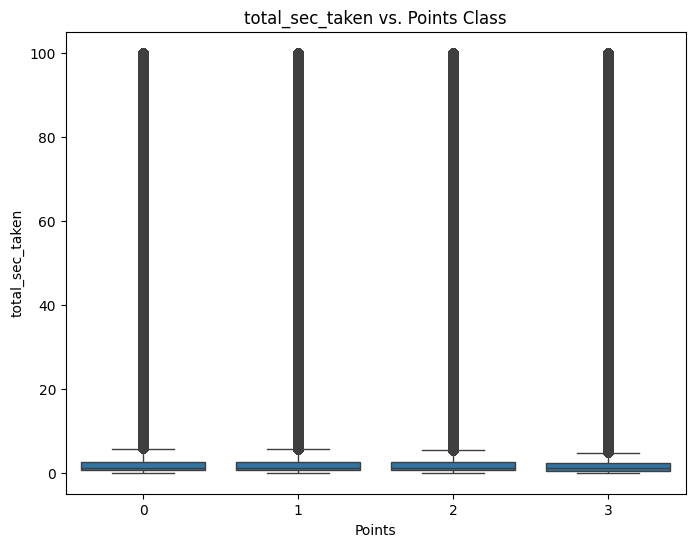

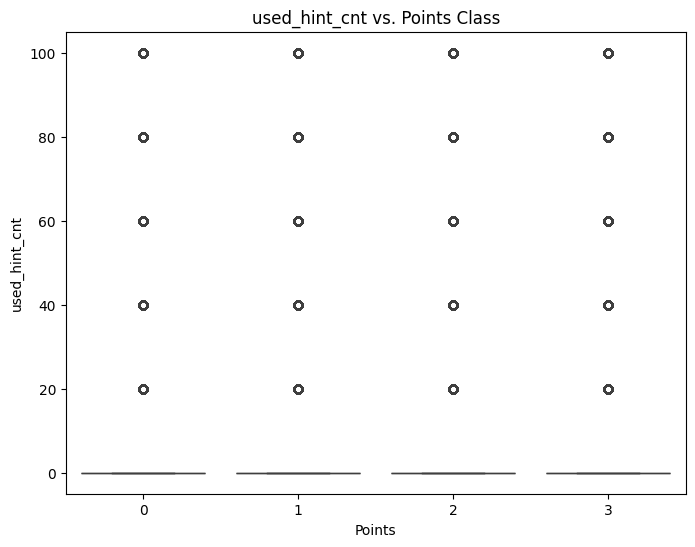

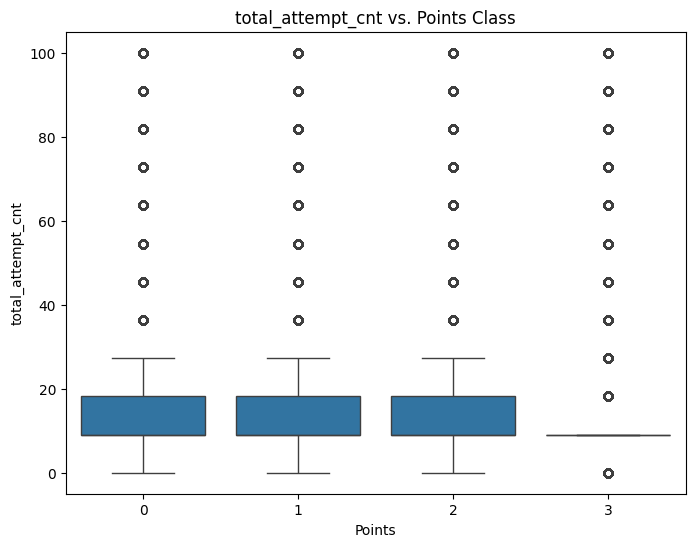

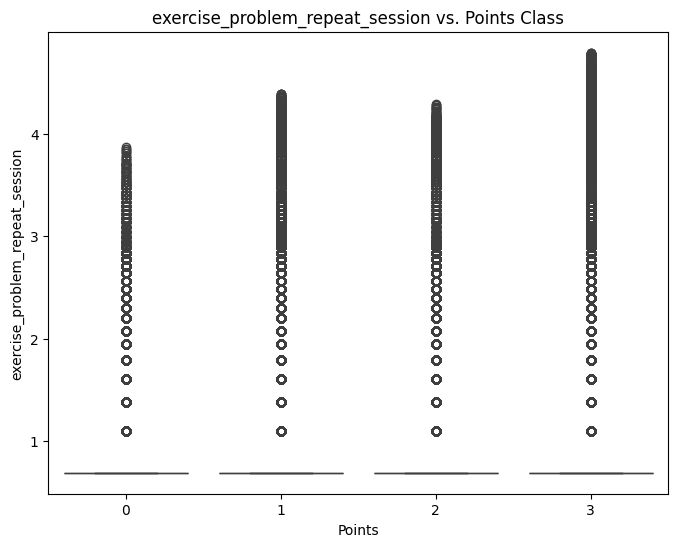

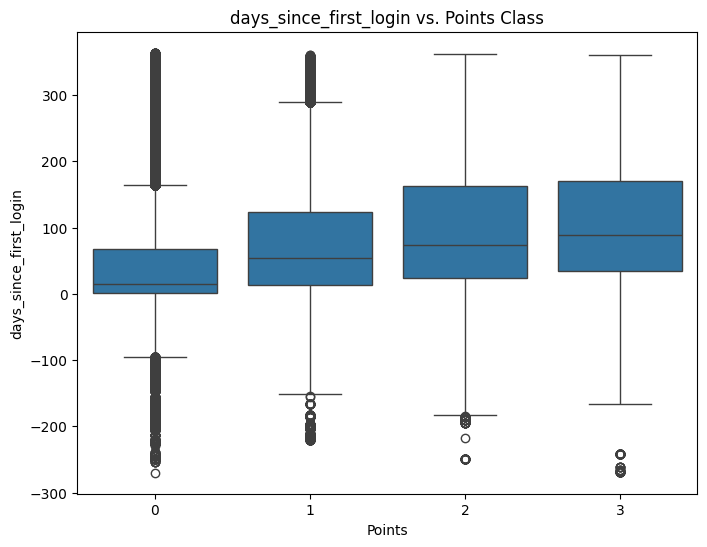

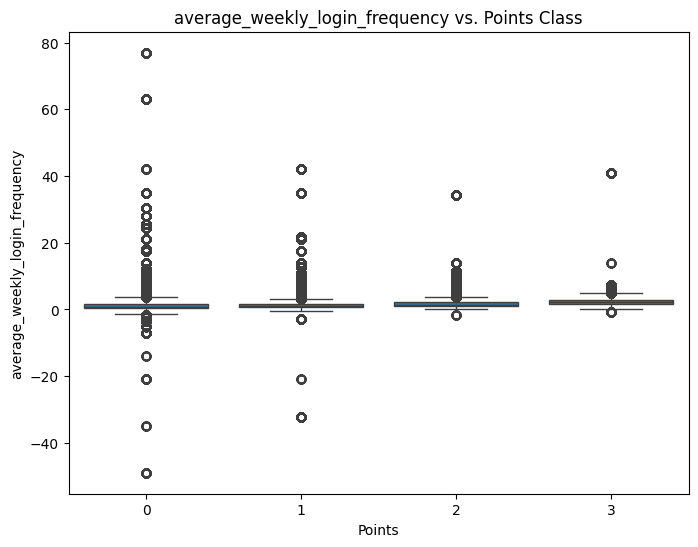

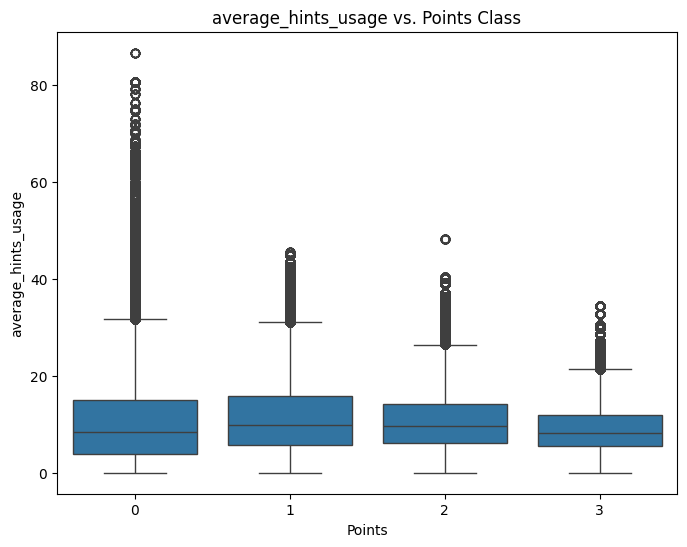

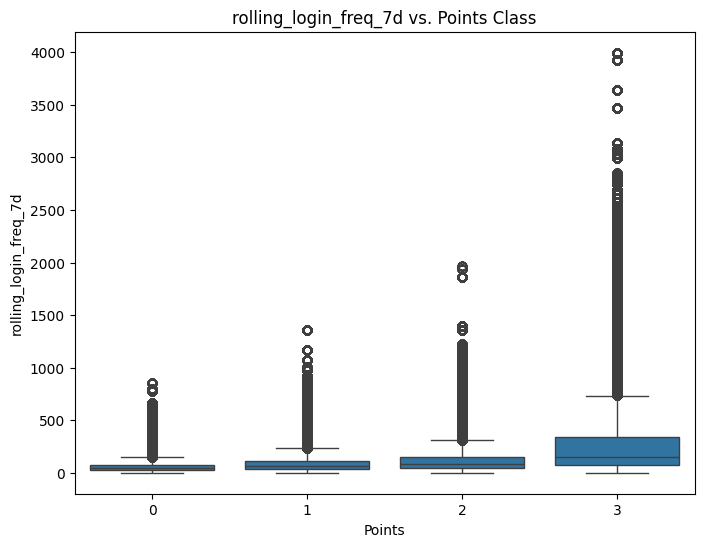

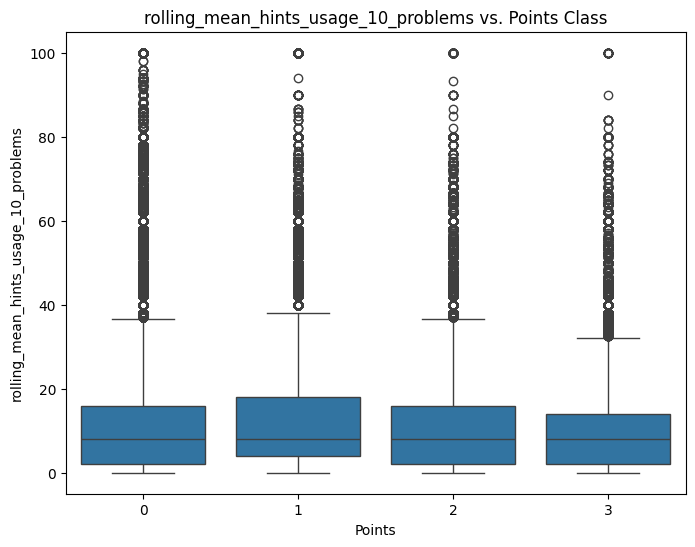

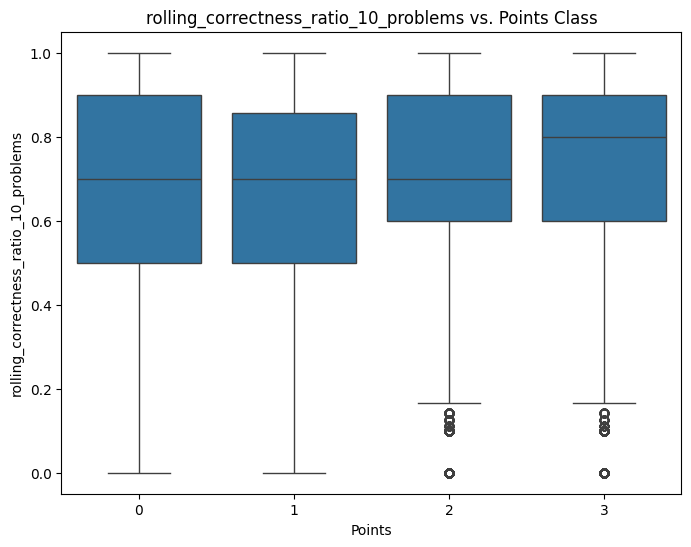

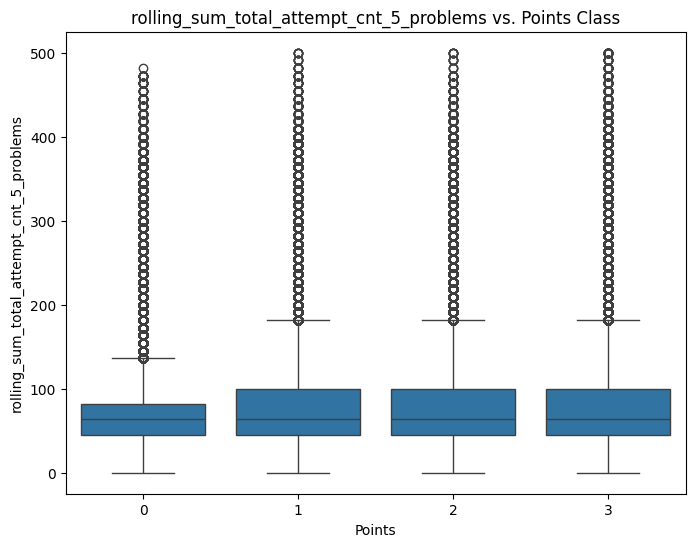

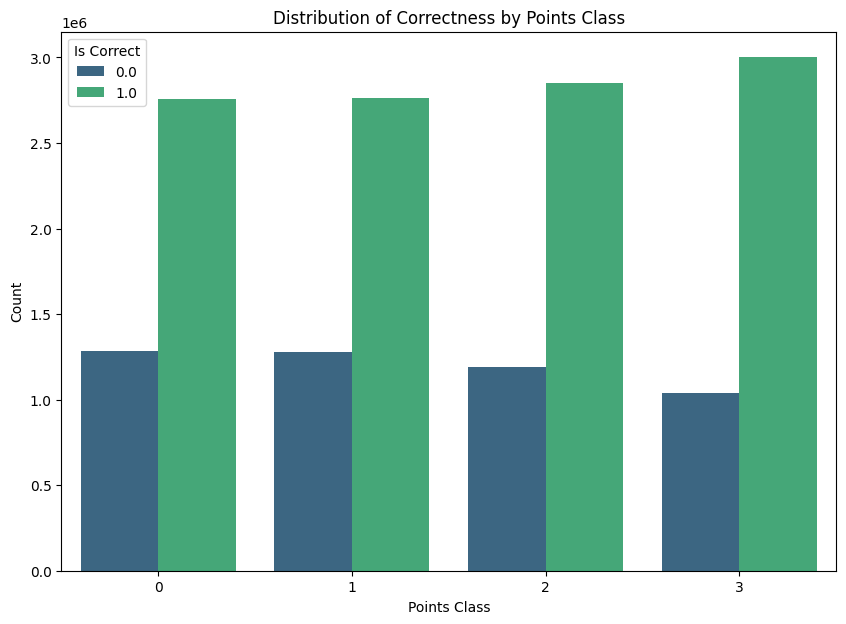

In [ ]:
# Boxplot/Violin plot for behavioral features vs. points
behavioral_features = ['total_sec_taken', 'used_hint_cnt', 'total_attempt_cnt','exercise_problem_repeat_session', 'days_since_first_login', 'average_weekly_login_frequency', 'average_hints_usage', 'rolling_login_freq_7d', 'rolling_mean_hints_usage_10_problems', 'rolling_correctness_ratio_10_problems', 'rolling_sum_total_attempt_cnt_5_problems']
for feature in behavioral_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='points_class', y=feature, data=df)
    plt.title(f'{feature} vs. Points Class')
    plt.xlabel('Points')
    plt.ylabel(feature)
    plt.show()

# Bar chart/Stacked bar for is_correct vs. points
plt.figure(figsize=(10, 7))
sns.countplot(x='points_class', hue='is_correct', data=df, palette='viridis')
plt.title('Distribution of Correctness by Points Class')
plt.xlabel('Points Class')
plt.ylabel('Count')
plt.legend(title='Is Correct')
plt.show()

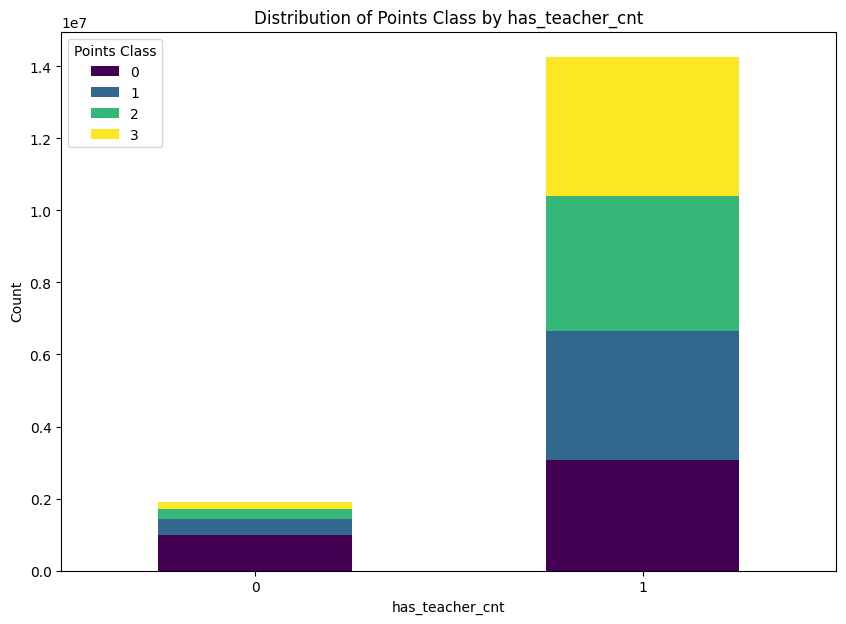

<ipython-input-4-e264ff151563>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='points_class', data=mean_points_class, palette='viridis')


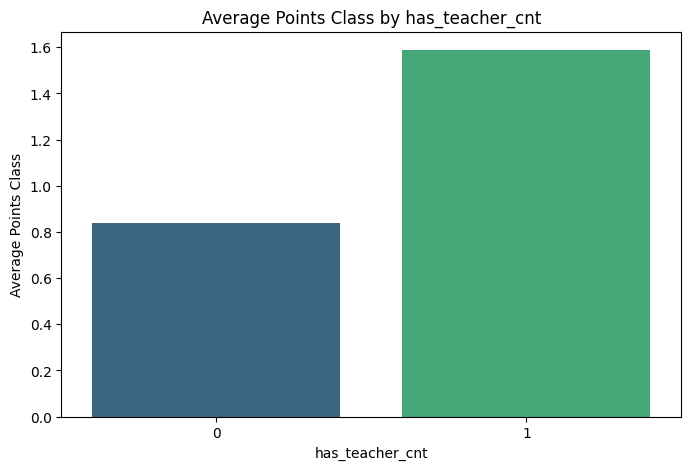

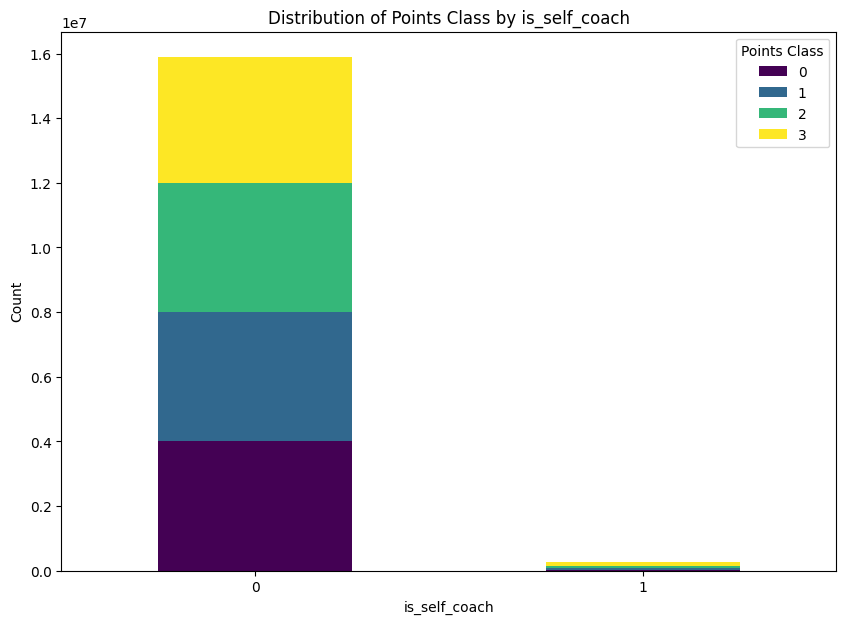

<ipython-input-4-e264ff151563>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='points_class', data=mean_points_class, palette='viridis')


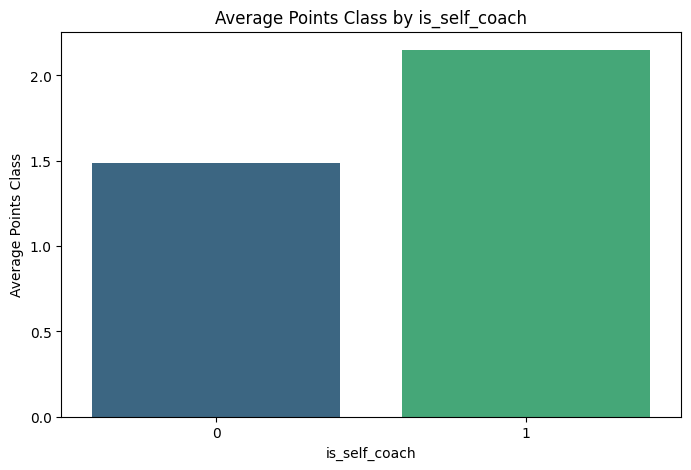

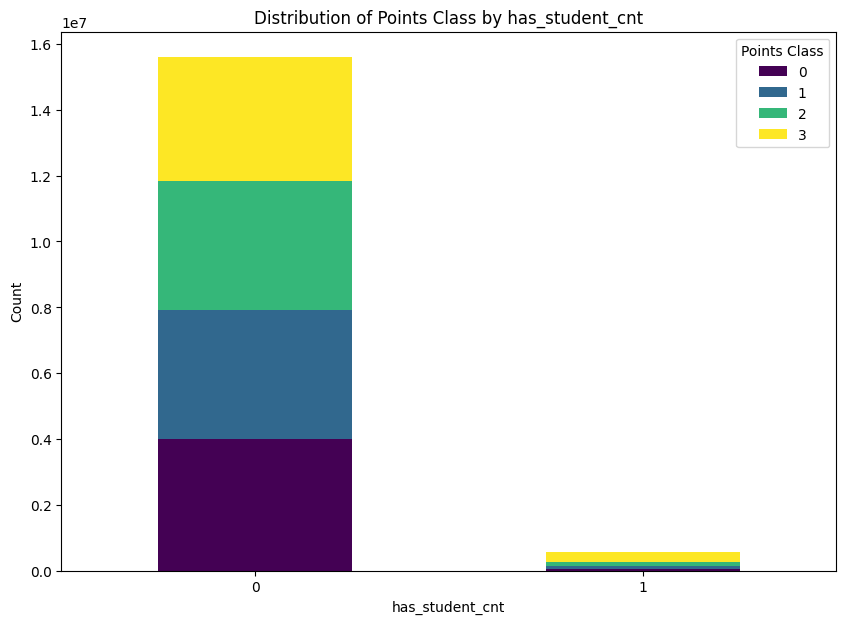

<ipython-input-4-e264ff151563>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='points_class', data=mean_points_class, palette='viridis')


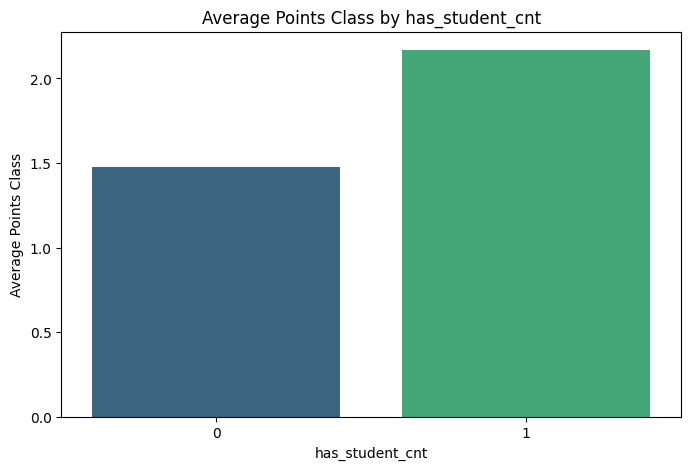

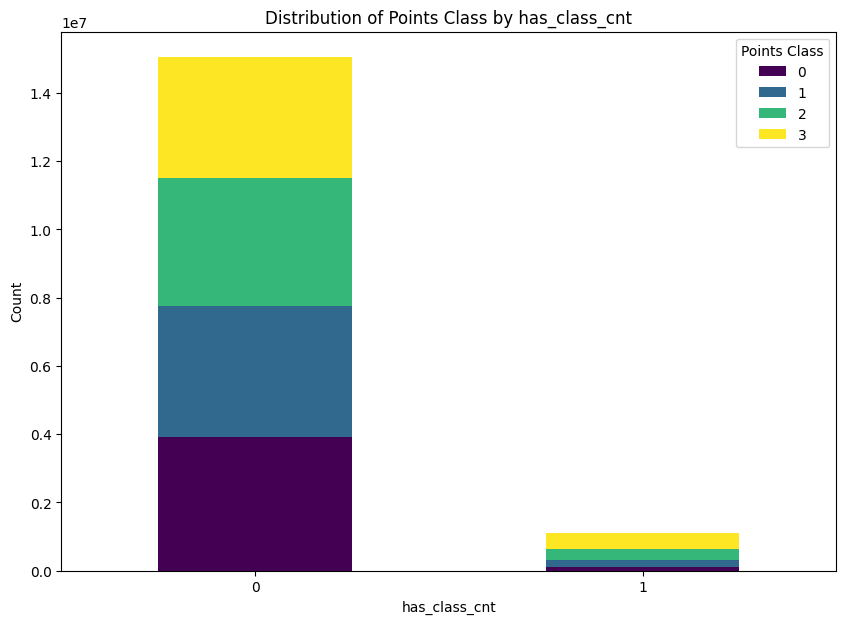

<ipython-input-4-e264ff151563>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='points_class', data=mean_points_class, palette='viridis')


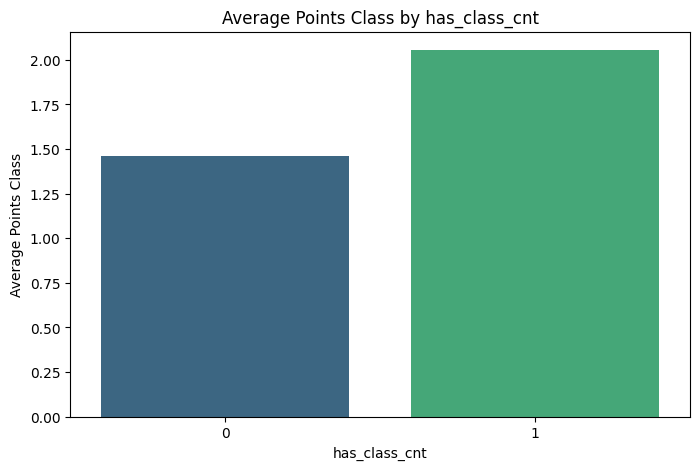

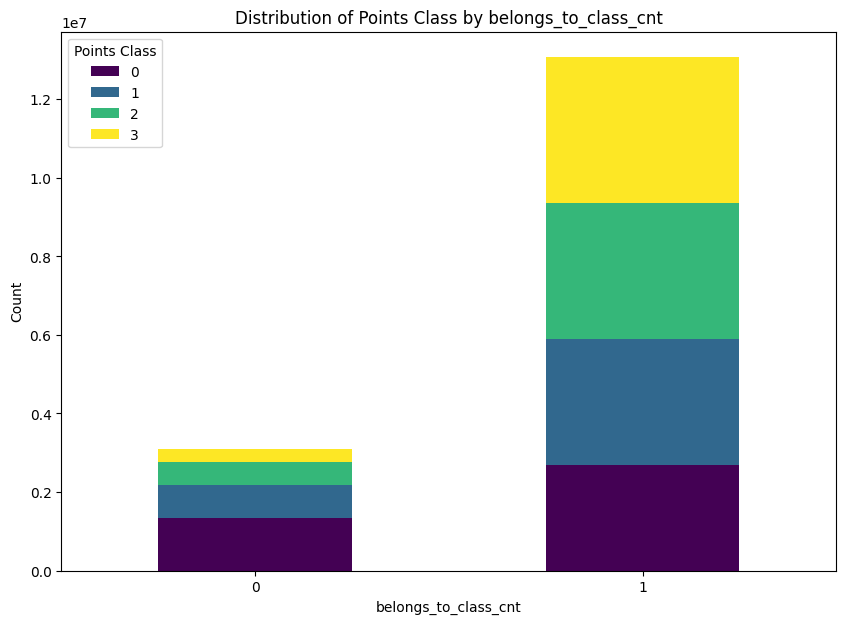

<ipython-input-4-e264ff151563>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='points_class', data=mean_points_class, palette='viridis')


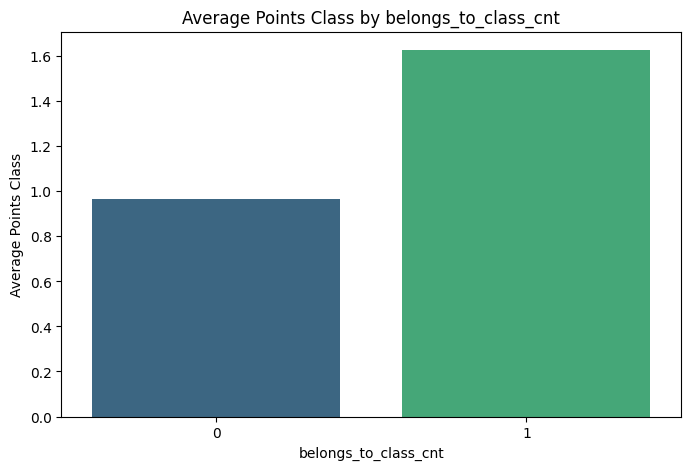

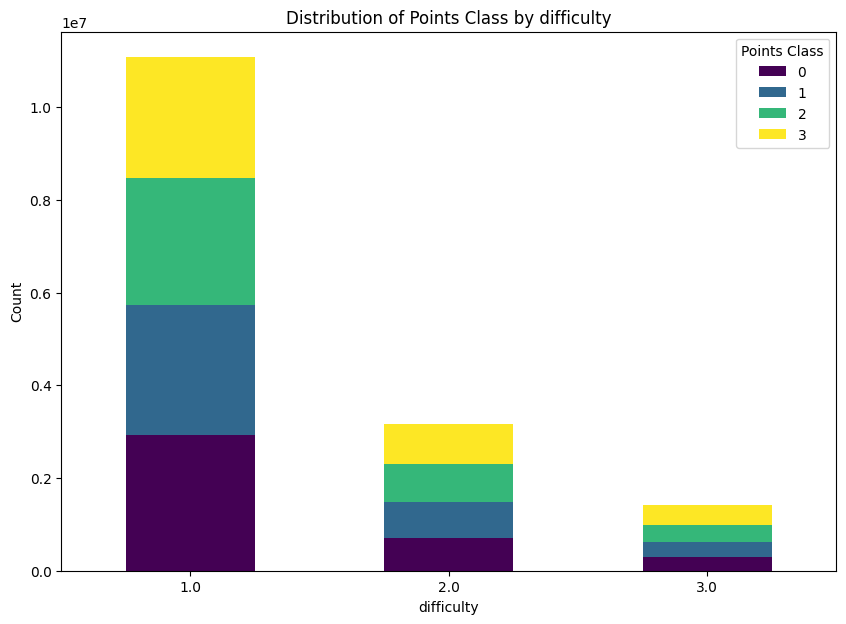

<ipython-input-4-e264ff151563>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='points_class', data=mean_points_class, palette='viridis')


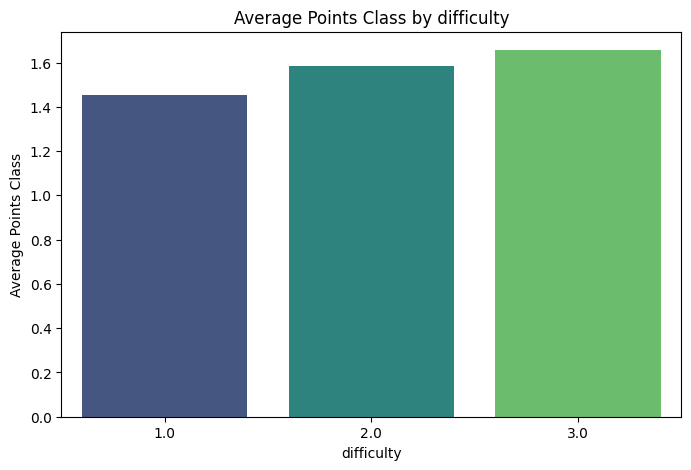

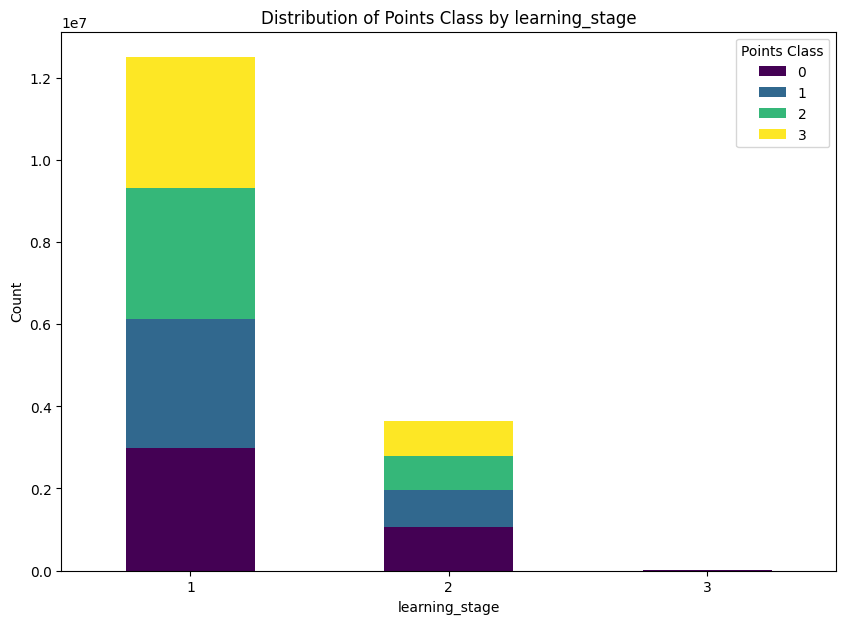

<ipython-input-4-e264ff151563>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='points_class', data=mean_points_class, palette='viridis')


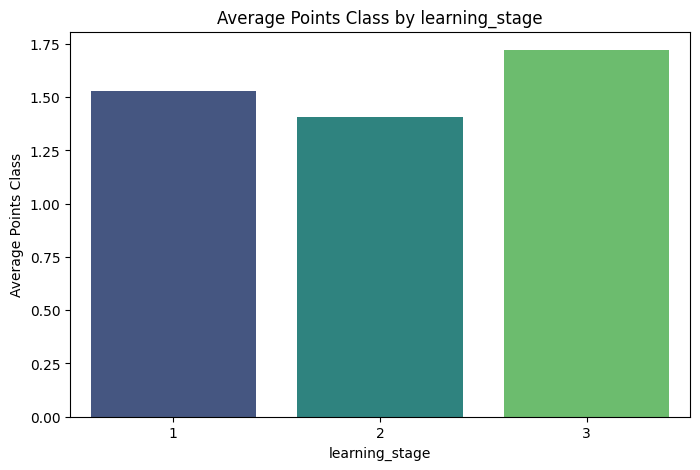

In [ ]:
# prompt: 🔍 B. 行為特徵與分數的關聯
# Feature	方法	說明
# total_sec_taken, used_hint_cnt, total_attempt_cnt vs. points	boxplot / violin	學生花費時間、嘗試次數與成績的關聯性
# is_correct vs. points	bar chart / stacked bar	正確率與分數的交互影響
# 🔍 C. 平台設計因素影響力（RQ2）
# has_teacher_cnt, is_self_coach, belongs_to_class_cnt 等 vs points or points_class
# ✅ 可做 stacked bar 或 groupby mean plot，觀察 trend

import seaborn as sns

# Stacked bar or groupby mean plot for platform design factors vs. points
platform_features = ['has_teacher_cnt', 'is_self_coach', 'has_student_cnt', 'has_class_cnt', 'belongs_to_class_cnt', 'difficulty', 'learning_stage'] # Add points_class as the target
for feature in platform_features:
    # Group by the platform feature and points_class, then unstack to get counts for stacking
    grouped_counts = df.groupby([feature, 'points_class']).size().unstack(fill_value=0)

    # Normalize if you want percentages
    # grouped_counts = grouped_counts.divide(grouped_counts.sum(axis=1), axis=0) * 100

    ax = grouped_counts.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')
    plt.title(f'Distribution of Points Class by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count') # Or 'Percentage' if normalized
    plt.xticks(rotation=0)
    plt.legend(title='Points Class')
    plt.show()

    # Or a mean plot
    mean_points_class = df.groupby(feature)['points_class'].mean().reset_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=feature, y='points_class', data=mean_points_class, palette='viridis')
    plt.title(f'Average Points Class by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Average Points Class')
    plt.show()

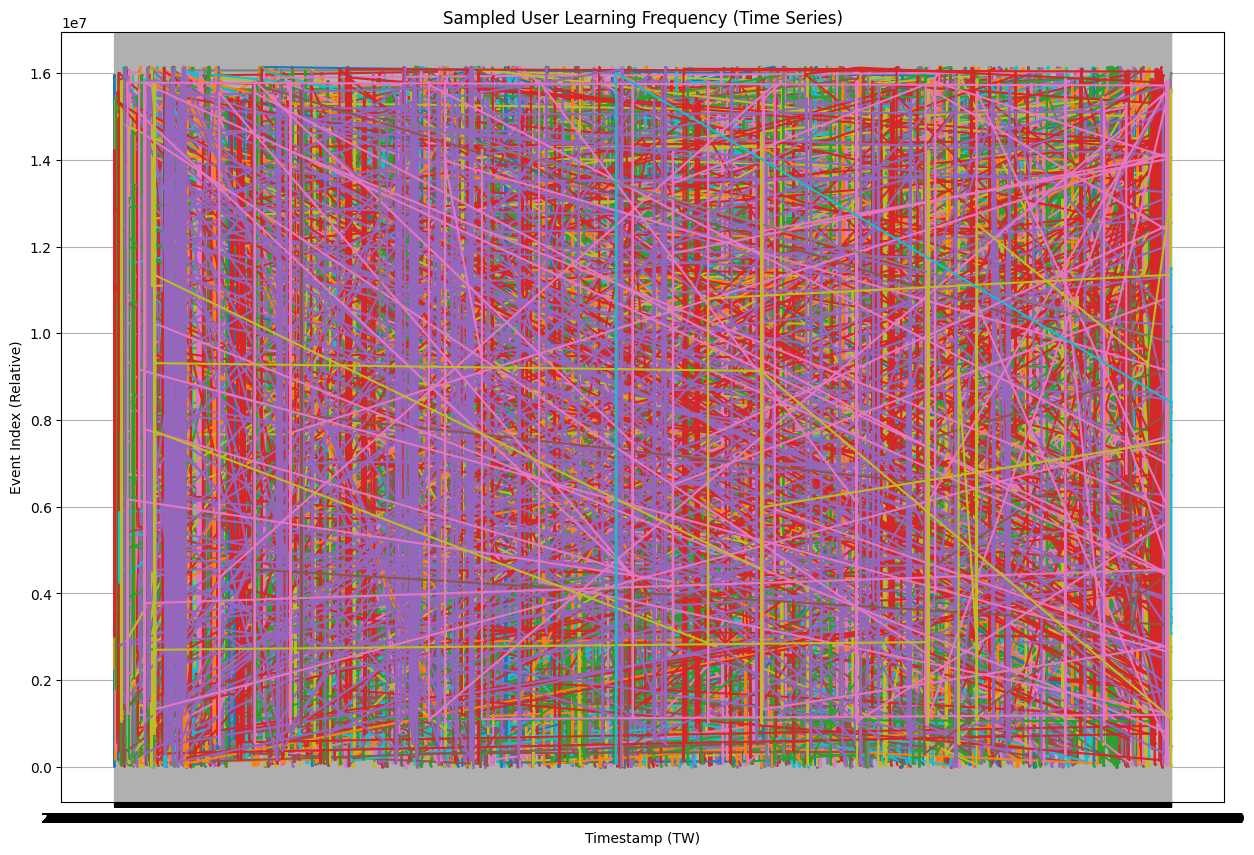

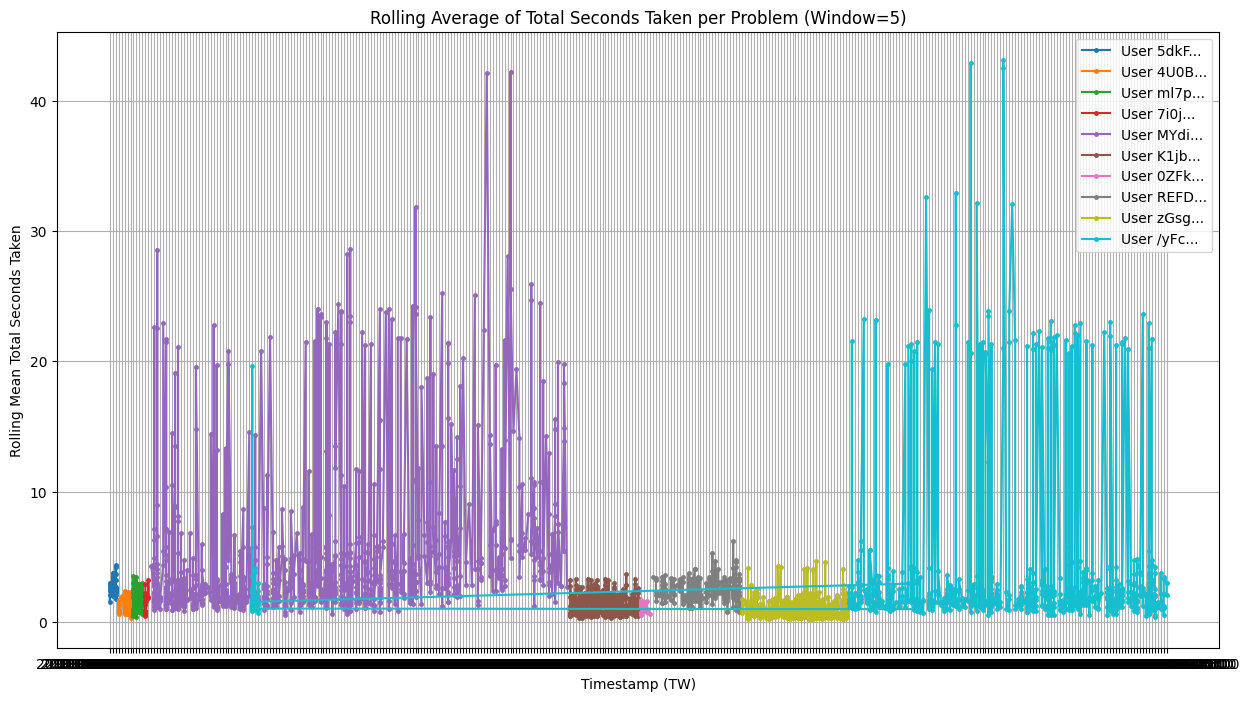

In [ ]:
# prompt: ⏳ D. 時間面分析
# Feature	方法	說明
# timestamp_TW per uuid	抽樣畫出 time series	看學生的學習頻率是否具時間結構（週期性、密集度）
# 依照 uuid groupby 看 total_sec_taken 的滑動平均	rolling mean 視覺化	若有趨勢 → 適合用 dynamic GNN

# Sample 500 unique users for time series visualization
sampled_uuids = np.random.choice(df['uuid'].unique(), size=min(500, df['uuid'].nunique()), replace=False)

plt.figure(figsize=(15, 10))
for uuid in sampled_uuids:
    user_df = df[df['uuid'] == uuid].sort_values('timestamp_TW')
    plt.plot(user_df['timestamp_TW'], user_df.index, marker='.', linestyle='-', markersize=2, label=f'User {uuid[:4]}...')

plt.title('Sampled User Learning Frequency (Time Series)')
plt.xlabel('Timestamp (TW)')
plt.ylabel('Event Index (Relative)')
plt.grid(True)
plt.show()


# Calculate rolling average of total_sec_taken per user
df['total_sec_taken_rolling_mean'] = df.groupby('uuid')['total_sec_taken'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

# Sample some users to plot
sampled_uuids_rolling = np.random.choice(df['uuid'].unique(), size=min(10, df['uuid'].nunique()), replace=False)

plt.figure(figsize=(15, 8))
for uuid in sampled_uuids_rolling:
    user_df = df[df['uuid'] == uuid].sort_values('timestamp_TW')
    plt.plot(user_df['timestamp_TW'], user_df['total_sec_taken_rolling_mean'], marker='.', linestyle='-', markersize=5, label=f'User {uuid[:4]}...')

plt.title('Rolling Average of Total Seconds Taken per Problem (Window=5)')
plt.xlabel('Timestamp (TW)')
plt.ylabel('Rolling Mean Total Seconds Taken')
plt.legend()
plt.grid(True)
plt.show()


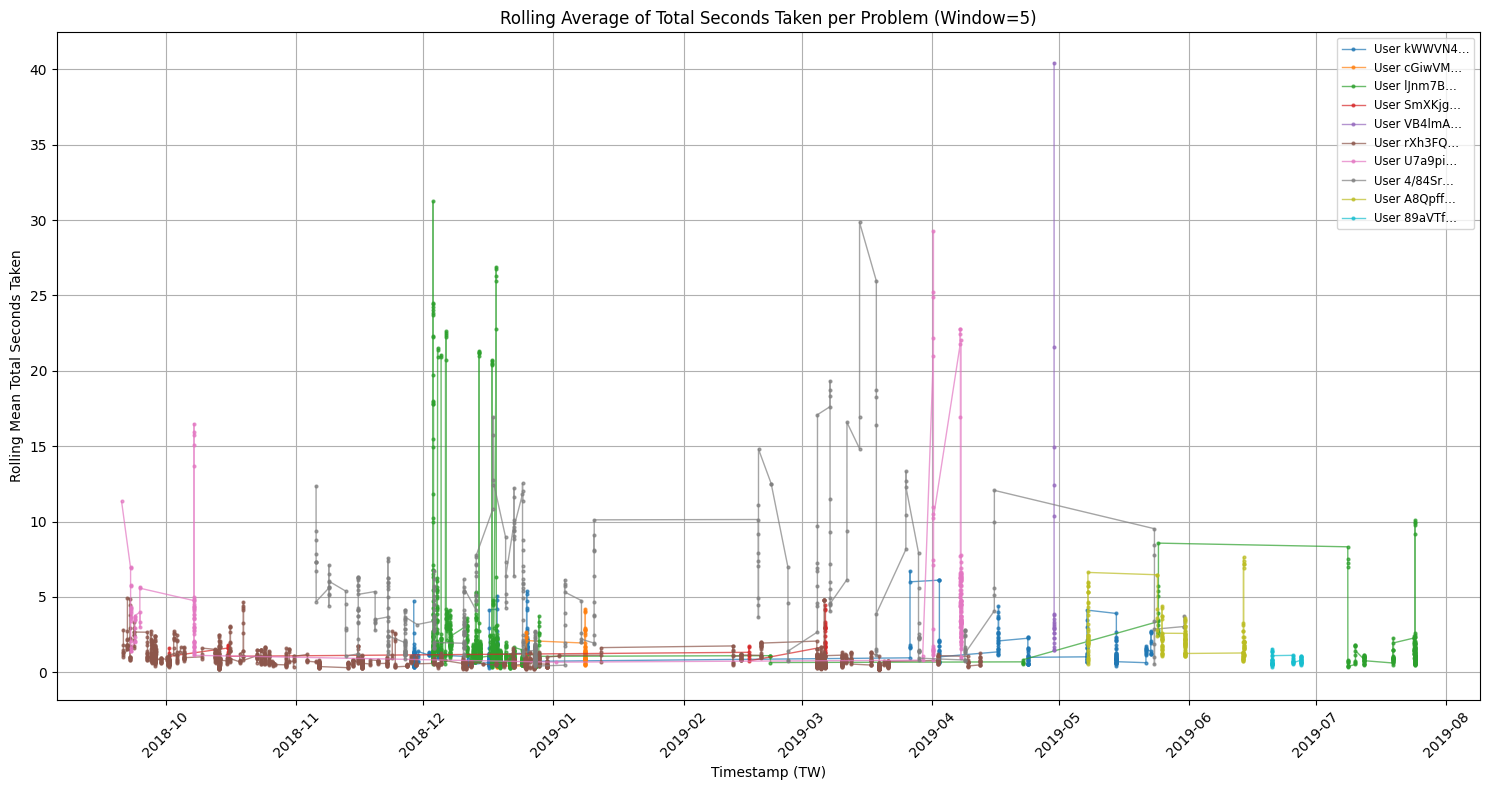

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure timestamp is in datetime format
df['timestamp_TW'] = pd.to_datetime(df['timestamp_TW'], errors='coerce')

# Sort by time to ensure correct rolling window
df = df.sort_values(by=['uuid', 'timestamp_TW'])

# Compute rolling mean efficiently using transform (preserves original shape)
df['total_sec_taken_rolling_mean'] = (
    df.groupby('uuid')['total_sec_taken']
    .transform(lambda x: x.rolling(window=5, min_periods=1).mean())
)

# Sample up to 10 users for visualization
sampled_uuids = np.random.choice(df['uuid'].unique(), size=min(10, df['uuid'].nunique()), replace=False)

# Plot
plt.figure(figsize=(15, 8))
for uuid in sampled_uuids:
    user_df = df[df['uuid'] == uuid]
    plt.plot(
        user_df['timestamp_TW'],
        user_df['total_sec_taken_rolling_mean'],
        marker='.',
        linestyle='-',
        markersize=4,
        alpha=0.7,
        linewidth=1,
        label=f'User {uuid[:6]}…'
    )

plt.title('Rolling Average of Total Seconds Taken per Problem (Window=5)')
plt.xlabel('Timestamp (TW)')
plt.ylabel('Rolling Mean Total Seconds Taken')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df = df.drop(columns='Unnamed: 0')
df.columns

Index(['timestamp_TW', 'uuid', 'ucid', 'upid', 'problem_number',
       'exercise_problem_repeat_session', 'is_correct', 'total_sec_taken',
       'total_attempt_cnt', 'used_hint_cnt', 'is_hint_used', 'is_downgrade',
       'is_upgrade', 'badges_cnt', 'first_login_date_TW', 'user_grade',
       'has_teacher_cnt', 'is_self_coach', 'has_student_cnt',
       'belongs_to_class_cnt', 'has_class_cnt', 'difficulty', 'learning_stage',
       'level4_id', 'level_encoded', 'hour', 'day_of_week', 'month', 'year',
       'days_since_first_login', 'points_class', 'user_city_encoded',
       'max_difficulty', 'max_days_since_first_login',
       'average_weekly_login_frequency', 'average_hints_usage',
       'rolling_login_freq_7d', 'rolling_mean_hints_usage_10_problems',
       'rolling_correctness_ratio_10_problems',
       'rolling_sum_total_attempt_cnt_5_problems'],
      dtype='object')

In [ ]:
#platform related design
#has_teacher_cnt – whether a teacher is involved
#is_self_coach – if the student is studying independently
#has_student_cnt, has_class_cnt, belongs_to_class_cnt – structural grouping
#difficulty, learning_stage, max_difficulty – exercise design/difficulty

In [ ]:
#student related
#demographic: user_grade, user_city_encoded
#derived: average_weekly_login_frequency, average_hints_usage, rolling_login_freq_7d, rolling_mean_hints_usage_10_problems, rolling_correctness_ratio_10_problems, rolling_sum_total_attempt_cnt_5_problems
#behavior: total_sec_taken, used_hint_cnt, total_attempt_cnt, is_correct, exercise_problem_repeat_session, days_since_first_login

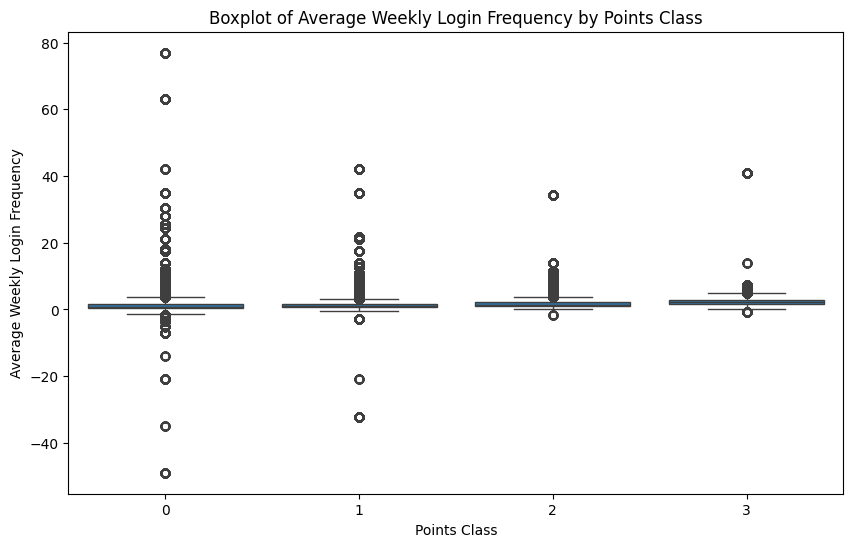

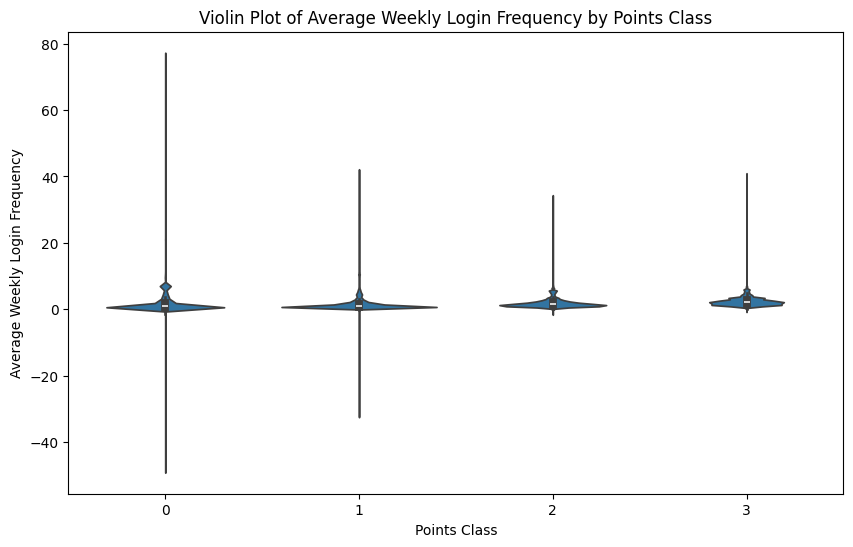

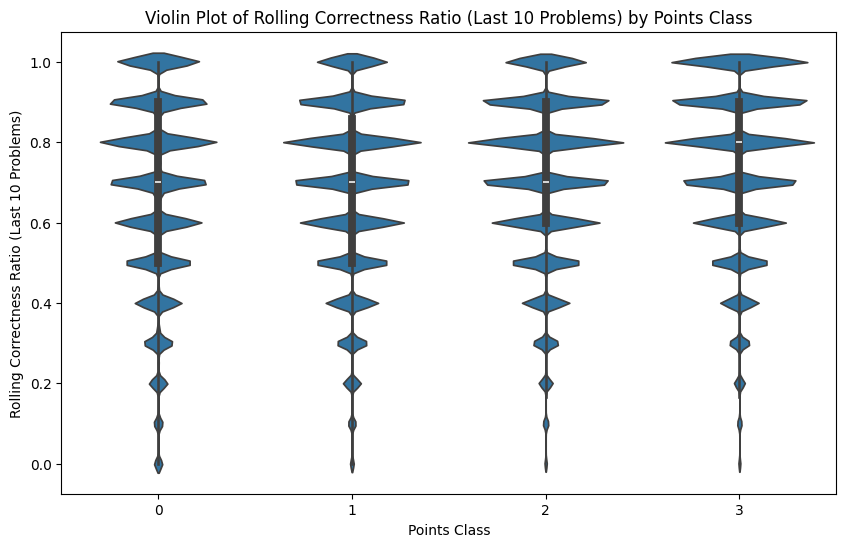

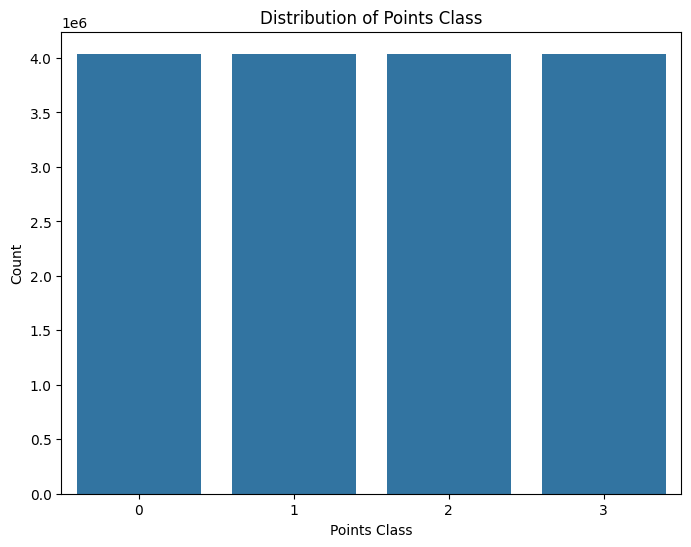

<ipython-input-8-449ab904ba6d>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data['problem_order'] = range(len(student_data))
<ipython-input-8-449ab904ba6d>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data['problem_order'] = range(len(student_data))
<ipython-input-8-449ab904ba6d>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

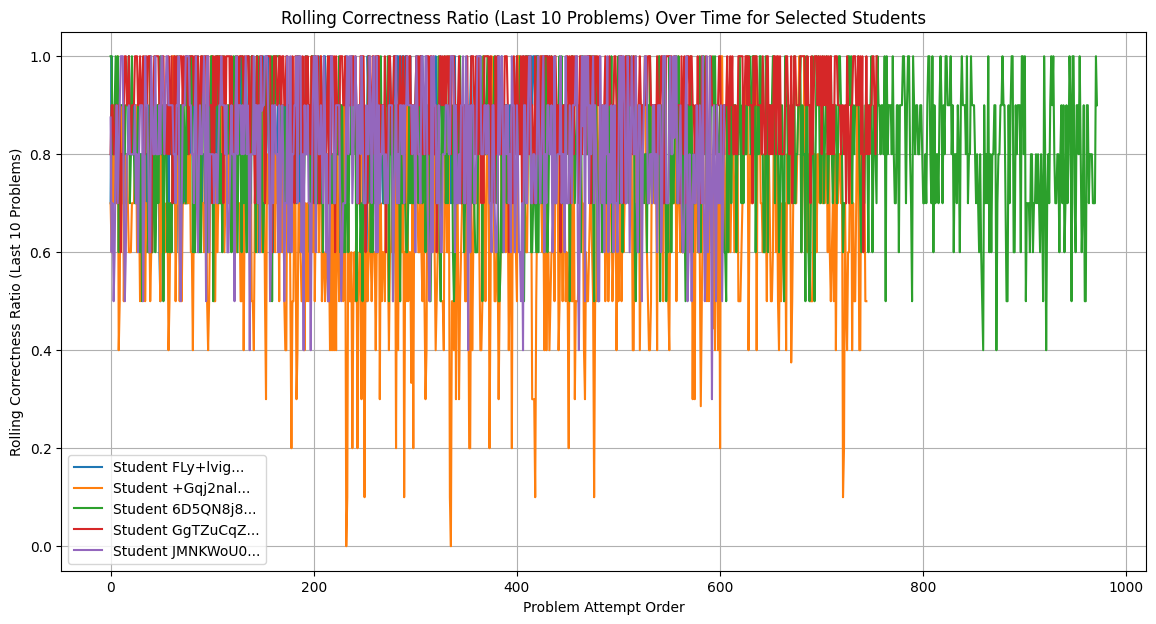

In [ ]:
import seaborn as sns

# Boxplot: points_class vs. average_weekly_login_frequency
plt.figure(figsize=(10, 6))
sns.boxplot(x='points_class', y='average_weekly_login_frequency', data=df)
plt.title('Boxplot of Average Weekly Login Frequency by Points Class')
plt.xlabel('Points Class')
plt.ylabel('Average Weekly Login Frequency')
plt.show()

# Violin plot: points_class vs. average_weekly_login_frequency
plt.figure(figsize=(10, 6))
sns.violinplot(x='points_class', y='average_weekly_login_frequency', data=df)
plt.title('Violin Plot of Average Weekly Login Frequency by Points Class')
plt.xlabel('Points Class')
plt.ylabel('Average Weekly Login Frequency')
plt.show()

# Violin plot: points_class vs. rolling_correctness_ratio_10_problems
plt.figure(figsize=(10, 6))
sns.violinplot(x='points_class', y='rolling_correctness_ratio_10_problems', data=df)
plt.title('Violin Plot of Rolling Correctness Ratio (Last 10 Problems) by Points Class')
plt.xlabel('Points Class')
plt.ylabel('Rolling Correctness Ratio (Last 10 Problems)')
plt.show()

# Histogram: Distribution of points_class
plt.figure(figsize=(8, 6))
sns.countplot(x='points_class', data=df)
plt.title('Distribution of Points Class')
plt.xlabel('Points Class')
plt.ylabel('Count')
plt.show()

# Line plot: rolling_correctness_ratio_10_problems over time for selected students
# Select a few students for visualization (e.g., first 5 unique uuids)
selected_uuids = df['uuid'].unique()[:5]
df_selected_students = df[df['uuid'].isin(selected_uuids)].copy()

# Sort by timestamp within each student to show trajectory over time
df_selected_students = df_selected_students.sort_values(by=['uuid', 'timestamp_TW'])

plt.figure(figsize=(14, 7))
for student_uuid in selected_uuids:
  student_data = df_selected_students[df_selected_students['uuid'] == student_uuid]
  # Use a numerical index for the x-axis to represent problem attempts in order
  student_data['problem_order'] = range(len(student_data))
  plt.plot(student_data['problem_order'], student_data['rolling_correctness_ratio_10_problems'], label=f'Student {student_uuid[:8]}...') # Truncate uuid for legend
plt.title('Rolling Correctness Ratio (Last 10 Problems) Over Time for Selected Students')
plt.xlabel('Problem Attempt Order')
plt.ylabel('Rolling Correctness Ratio (Last 10 Problems)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#RQ1: if TGNN perfom better
#distribution of point class
#points_class vs. average_weekly_login_frequency, rolling_correctness_ratio_10_problems
#points_class vs. average_weekly_login_frequency, rolling_correctness_ratio_10_problems

In [ ]:
#RQ2: Which platform features influence engagement/performance?
#points_class vs. has_teacher_cnt, is_self_coach, belongs_to_class_cnt
#correlation between platform features and performance
#average rolling_correctness_ratio_10_problems grouped by difficulty or learning_stage > how content design affects performance.

In [ ]:
#RQ3: Which behavioral features influence performance?
#points_class vs. rolling_sum_total_attempt_cnt_5_problems, average_hints_usage
#compare total_sec_taken or total_attempt_cnt across points_class
#correlation heatmap between all behavior-derived features and points_class

# Clarification and Study Design

In [3]:
df.columns

Index(['timestamp_TW', 'uuid', 'ucid', 'upid', 'problem_number',
       'exercise_problem_repeat_session', 'is_correct', 'total_sec_taken',
       'total_attempt_cnt', 'used_hint_cnt', 'is_hint_used', 'is_downgrade',
       'is_upgrade', 'badges_cnt', 'first_login_date_TW', 'user_grade',
       'has_teacher_cnt', 'is_self_coach', 'has_student_cnt',
       'belongs_to_class_cnt', 'has_class_cnt', 'difficulty', 'learning_stage',
       'level4_id', 'level_encoded', 'hour', 'day_of_week', 'month', 'year',
       'days_since_first_login', 'points_class', 'user_city_encoded',
       'max_difficulty', 'max_days_since_first_login',
       'average_weekly_login_frequency', 'average_hints_usage',
       'rolling_login_freq_7d', 'rolling_mean_hints_usage_10_problems',
       'rolling_correctness_ratio_10_problems',
       'rolling_sum_total_attempt_cnt_5_problems'],
      dtype='object')

In [4]:
#Group	Features
platform_features = [
    'has_teacher_cnt', 'is_self_coach', 'has_student_cnt',
    'has_class_cnt', 'belongs_to_class_cnt',
    'difficulty', 'learning_stage'
]

demographic_features = ['user_grade', 'user_city_encoded']

behavior_features = [
    'total_sec_taken', 'used_hint_cnt', 'total_attempt_cnt',
    'is_correct', 'exercise_problem_repeat_session',
    'days_since_first_login', 'average_hints_usage',
    'rolling_mean_hints_usage_10_problems',
    'rolling_login_freq_7d',
    'rolling_correctness_ratio_10_problems',
    'rolling_sum_total_attempt_cnt_5_problems'
]
shap_top_features = [
    'badges_cnt', 'belongs_to_class_cnt', 'has_teacher_cnt',
    'user_grade', 'learning_stage', 'is_correct',
    'used_hint_cnt', 'is_hint_used'
]
#for RQ1
full_features = platform_features + demographic_features + behavior_features
#RQ2
non_platform = demographic_features + behavior_features
with_platform = platform_features + demographic_features + behavior_features
#RQ3
non_behavior = platform_features + demographic_features
with_behavior = platform_features + demographic_features + behavior_features

In [5]:
'''
For this study, the code is segmented into 3 section in order to address the following question:
{RQ1 How do graph-based models such as Graph Convolutional Networks (GCN),Graph Attention Networks (GAT), and GraphSAGE compare to traditional classification models like Random Forest and XGBoost in predicting student
performance classes?}

{RQ2 Which features related to platform design, such as exercise difficulty and teacher intervention, have the greatest impact on student engagement and performance?}

{RQ3 Which time-dependent engagement features initiated by students, such as log-in frequency, problem-solving attempts, and hint usage, most influence student performance?}

RQ1 utilize RF, GCN, GAT, GraphSAGE, EvolveGCN on full_features dataset
RQ2 utilize RF, GCN, GAT, GraphSAGE, EvolveGCN on non_platform dataset
RQ3 utilize RF, GCN, GAT, GraphSAGE, EvolveGCN on non_behavior dataset
'''

'\nFor this study, the code is segmented into 3 section in order to address the following question:\n{RQ1 How do graph-based models such as Graph Convolutional Networks (GCN),Graph Attention Networks (GAT), and GraphSAGE compare to traditional classification models like Random Forest and XGBoost in predicting student\nperformance classes?}\n\n{RQ2 Which features related to platform design, such as exercise difficulty and teacher intervention, have the greatest impact on student engagement and performance?}\n\n{RQ3 Which time-dependent engagement features initiated by students, such as log-in frequency, problem-solving attempts, and hint usage, most influence student performance?}\n\nRQ1 utilize RF, GCN, GAT, GraphSAGE, EvolveGCN on full_features dataset\nRQ2 utilize RF, GCN, GAT, GraphSAGE, EvolveGCN on non_platform dataset\nRQ3 utilize RF, GCN, GAT, GraphSAGE, EvolveGCN on non_behavior dataset\n'

# Functions Preparation

In [6]:
# --- 安裝與環境準備 ---

#!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric torch-geometric-temporal numpy
!pip install torch==2.2.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-geometric-temporal
!pip install shap optuna
'''
# --- 修正 Python >= 3.10 的 MutableMapping 問題 ---
import collections
import collections.abc
collections.MutableMapping = collections.abc.MutableMapping
'''
# --- 必要模組 import ---
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GraphConv, GATConv, SAGEConv
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import GCLSTM
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.explain import Explainer, GNNExplainer

import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from datetime import datetime
import copy


Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html


## GNN

In [7]:
#Graph prep, aggregate uuid to make one graph

def make_graph(df_raw, features=None, edge_types=('upid', 'ucid')):
    df_sorted = df_raw.sort_values(by='total_sec_taken', ascending=False)
    for col in df_sorted.columns:
      if df_sorted[col].dtype.name == 'category' or df_sorted[col].dtype == 'object':
          try:
              df_sorted[col] = df_sorted[col].astype(float)
          except:
              df_sorted[col] = df_sorted[col].astype('category').cat.codes
    agg_dict = {
        'total_sec_taken': 'sum',
        'total_attempt_cnt': 'sum',
        'used_hint_cnt': 'sum',
        'points_class': 'first',
        'badges_cnt': 'sum',
        'is_hint_used': 'mean',
        'is_upgrade': 'mean',
        'is_downgrade': 'mean',
        'is_correct': 'mean',
        'problem_number': 'mean',
        'exercise_problem_repeat_session': 'mean',
        'user_grade': 'max',
        'difficulty': 'max',
        'learning_stage': 'max',
        'has_teacher_cnt': 'max',
        'is_self_coach': 'max',
        'has_student_cnt': 'max',
        'belongs_to_class_cnt': 'max',
        'has_class_cnt': 'max',
        'user_city_encoded': 'max',
        'max_difficulty': 'max',
        'days_since_first_login': 'max',
        'average_weekly_login_frequency': 'max',
        'average_hints_usage': 'max',
        'rolling_login_freq_7d': 'max',
        'rolling_mean_hints_usage_10_problems': 'max',
        'rolling_correctness_ratio_10_problems': 'max',
        'rolling_sum_total_attempt_cnt_5_problems': 'max',
    }

    df = df_sorted.groupby('uuid').agg(agg_dict).reset_index()
    upid_map = df_sorted.drop_duplicates('uuid', keep='first').set_index('uuid')['upid']
    ucid_map = df_sorted.drop_duplicates('uuid', keep='first').set_index('uuid')['ucid']
    df['upid'] = df['uuid'].map(upid_map)
    df['ucid'] = df['uuid'].map(ucid_map)

    # default features
    if features is None:
        features = [
            'has_teacher_cnt', 'is_self_coach', 'has_student_cnt',
            'belongs_to_class_cnt', 'has_class_cnt', 'user_grade',
            'user_city_encoded', 'max_difficulty', 'max_days_since_first_login',
            'average_weekly_login_frequency', 'average_hints_usage',
            'rolling_login_freq_7d', 'rolling_mean_hints_usage_10_problems',
            'rolling_correctness_ratio_10_problems', 'rolling_sum_total_attempt_cnt_5_problems',
            'problem_number', 'exercise_problem_repeat_session', 'is_correct',
            'is_hint_used', 'is_downgrade', 'is_upgrade', 'badges_cnt'
        ]
    # node features
    node_features = df[features]
    x = torch.tensor(node_features.values, dtype=torch.float)
    x = torch.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)

    # labels
    y = torch.tensor(df['points_class'].astype(int).values, dtype=torch.long)

    # node index mapping
    df['node_id'] = df.reset_index().index
    uuid2node = dict(zip(df['uuid'], df['node_id']))

    # edge building
    import itertools
    import numpy as np
    from torch_geometric.data import Data

    all_edges = []
    for etype in edge_types:
        for _, group in df.groupby(etype):
            users = group['node_id'].tolist()
            if len(users) >= 2:
                all_edges.extend(itertools.combinations(users, 2))

    if all_edges:
        all_edges = np.unique(np.array(all_edges), axis=0)
        edge_index = torch.tensor(all_edges.T, dtype=torch.long)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    # build PyG data
    data = Data(x=x, edge_index=edge_index, y=y)

    # mask split
    num_nodes = data.num_nodes
    #idx = np.random.permutation(num_nodes)
    idx = torch.randperm(num_nodes)
    train_cut = int(0.7 * num_nodes)
    val_cut = int(0.85 * num_nodes)
    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.train_mask[idx[:train_cut]] = True
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask[idx[train_cut:val_cut]] = True
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask[idx[val_cut:]] = True

    return data, df[['uuid', 'node_id']]

In [8]:
class GCN(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GraphConv(-1, hidden_channels)
        self.conv2 = GraphConv(-1, out_channels)
        self.dropout_layer = nn.Dropout(p=self.dropout)

    def forward(self, x, edge_index):
        x = self.dropout_layer(x)
        x = self.conv1(x, edge_index).relu()
        x = self.dropout_layer(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(nn.Module):
    def __init__(self, hidden_channels, out_channels, heads=2, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv((-1, -1), hidden_channels, heads=heads, dropout=dropout, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels, heads=1, concat=False, dropout=dropout, add_self_loops=False)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [9]:
# === 訓練與評估函式（分類任務） ===
import argparse
args = argparse.Namespace()
args.epochs = 30
args.heads = 2 # used for GAT
def run_experiment_classification(data, model_type, hidden_channels=None, lr=None, dropout=None, epochs=100, heads=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_copy = copy.deepcopy(data).to(device)
    num_classes = int(data_copy.y.max().item()) + 1

    if model_type == 'GCN':
        model = GCN(hidden_channels, out_channels=num_classes, dropout=dropout).to(device)
    elif model_type == 'GAT':
        model = GAT(hidden_channels, out_channels=num_classes, heads=heads, dropout=dropout).to(device)
    elif model_type == 'GraphSAGE':
        model = GraphSAGE(hidden_channels, out_channels=num_classes).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data_copy.x, data_copy.edge_index)
        loss = loss_fn(out[data_copy.train_mask], data_copy.y[data_copy.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_copy.x, data_copy.edge_index)
            val_pred = out[data_copy.val_mask].argmax(dim=1)
            val_true = data_copy.y[data_copy.val_mask]
            val_acc = accuracy_score(val_true.cpu(), val_pred.cpu())
            val_f1 = f1_score(val_true.cpu(), val_pred.cpu(), average='weighted')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())

        if epoch % 10 == 0 or epoch == 1:
            print(f"[{model_type}] Epoch {epoch:03d} | Loss: {loss:.4f} "
                  f"| Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        out = model(data_copy.x, data_copy.edge_index)
        test_pred = out[data_copy.test_mask].argmax(dim=1)
        test_true = data_copy.y[data_copy.test_mask]
        test_acc = accuracy_score(test_true.cpu(), test_pred.cpu())
        test_f1 = f1_score(test_true.cpu(), test_pred.cpu(), average='weighted')

    print(f"[{model_type}] Test Acc: {test_acc:.4f} | F1: {test_f1:.4f}")

    # === GNNExplainer 視覺化 ===
    node_index = int(data_copy.test_mask.nonzero(as_tuple=True)[0][0])
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs'
        ),
    )
    explanation = explainer(data_copy.x, data_copy.edge_index, index=node_index)
    print(f"Available explanations: {explanation.available_explanations}")
    explanation.visualize_feature_importance('feature_importance.png', top_k=10)
    explanation.visualize_graph('subgraph.pdf')

    cm = confusion_matrix(test_true.cpu(), test_pred.cpu())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_type}")
    plt.savefig("confusion_matrix.png")
    plt.show()

    return test_acc, test_f1, model, data_copy

In [10]:
# === Optuna 目標函數 ===
def objective_classification(trial, model_name, data, args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32, 64])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.2, 0.6)

    args.hidden_channels = hidden_channels
    args.dropout = dropout
    args.lr = lr

    num_classes = int(data.y.max().item()) + 1

    if model_name == 'GCN':
        model = GCN(hidden_channels, out_channels=num_classes, dropout=dropout).to(device)
    elif model_name == 'GAT':
        model = GAT(hidden_channels, out_channels=num_classes, heads=args.heads, dropout=dropout).to(device)
    elif model_name == 'GraphSAGE':
        model = GraphSAGE(hidden_channels, out_channels=num_classes).to(device)
    else:
        raise ValueError(f"Unknown model {model_name}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    data_copy = copy.deepcopy(data).to(device)

    best_val_acc = 0
    for epoch in range(args.epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_copy.x, data_copy.edge_index)
        loss = loss_fn(out[data_copy.train_mask], data_copy.y[data_copy.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_copy.x, data_copy.edge_index)
            val_pred = out[data_copy.val_mask].argmax(dim=1)
            val_true = data_copy.y[data_copy.val_mask]
            val_acc = accuracy_score(val_true.cpu(), val_pred.cpu())
            if val_acc > best_val_acc:
                best_val_acc = val_acc

    del model, optimizer, data_copy
    torch.cuda.empty_cache()
    return 1 - best_val_acc

## EvolveGCN

In [11]:
def normalize_adjacency(adj):
    """Symmetric normalization: A_hat = D^-0.5 * A * D^-0.5"""
    adj = adj + np.eye(adj.shape[0])
    d = np.array(adj.sum(1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    D_inv_sqrt = np.diag(d_inv_sqrt)
    return D_inv_sqrt @ adj @ D_inv_sqrt

def build_snapshots(df, time_col='timestamp_TW', uuid_col='uuid',
                    label_col='points_class', snapshot_freq='W',
                    feature_cols=None, dropna=True):
    """
    Constructs snapshots (adjacency, features, labels) for EvolveGCN
    - df: your raw interaction DataFrame
    - snapshot_freq: 'W' = weekly, 'M' = monthly
    """

    # Prepare
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df['snapshot'] = df[time_col].dt.to_period(snapshot_freq).dt.to_timestamp()

    # Encode UUIDs (nodes)
    uuid_encoder = LabelEncoder()
    df['uuid_id'] = uuid_encoder.fit_transform(df[uuid_col])
    num_users = df['uuid_id'].nunique()

    # Feature selection
    if feature_cols is None:
        feature_cols = [
            'rolling_correctness_ratio_10_problems',
            'rolling_sum_total_attempt_cnt_5_problems',
            'rolling_mean_hints_usage_10_problems',
            'average_weekly_login_frequency',
            'average_hints_usage',
            'user_city_encoded',
            'max_difficulty'
        ]

    snapshots = []
    label_map = {}

    for t, group in df.groupby('snapshot'):
        node_ids = group['uuid_id'].unique()
        id_map = {uid: i for i, uid in enumerate(node_ids)}
        num_nodes = len(node_ids)

        # Build graph from co-occurrence or similarity (or user-user edges if available)
        G = nx.Graph()
        for uid in node_ids:
            G.add_node(id_map[uid])

        # Add pseudo-edges (e.g., self-loops, similarity) — you can improve this
        for uid in node_ids:
            G.add_edge(id_map[uid], id_map[uid])

        adj = nx.adjacency_matrix(G).astype(np.float32)
        adj = normalize_adjacency(adj)

        # Features matrix
        feats = group.groupby('uuid_id')[feature_cols].mean().reindex(node_ids).fillna(0).to_numpy()
        if dropna and np.isnan(feats).any():
            continue

        # Labels: only add at final snapshot
        if t == df['snapshot'].max():
            labels = group.groupby('uuid_id')[label_col].first().reindex(node_ids).to_numpy()
            label_map[t] = labels
        else:
            labels = None

        snapshots.append({
            'time': t,
            'adj': csr_matrix(adj),
            'features': feats.astype(np.float32),
            'node_ids': node_ids,
            'labels': labels  # may be None except last snapshot
        })

    return snapshots, uuid_encoder


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.explain import Explainer, GNNExplainer
import matplotlib.pyplot as plt
import numpy as np
import copy
import optuna

class EvolveGCNLayerH(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        weight_size = in_dim * out_dim
        self.gru = nn.GRUCell(weight_size, weight_size)

    def forward(self, X, A, prev_weights):
        H = torch.matmul(A, torch.matmul(X, prev_weights))
        prev_flat = prev_weights.view(-1)
        evolved_flat = self.gru(prev_flat.unsqueeze(0), prev_flat.unsqueeze(0))
        evolved = evolved_flat.view(self.in_dim, self.out_dim)
        return H, evolved


class EvolveGCN_H(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.layer1 = EvolveGCNLayerH(in_dim, hidden_dim)
        self.layer2 = EvolveGCNLayerH(hidden_dim, out_dim)
        self.W1 = nn.Parameter(torch.Tensor(in_dim, hidden_dim))
        self.W2 = nn.Parameter(torch.Tensor(hidden_dim, out_dim))
        nn.init.xavier_uniform_(self.W1)
        nn.init.xavier_uniform_(self.W2)

    def forward(self, X_list, A_list):
        W1 = self.W1
        W2 = self.W2
        for t in range(len(X_list)):
            X = X_list[t]
            A = A_list[t]
            H1, W1 = self.layer1(X, A, W1)
            H1 = F.relu(H1)
            H2, W2 = self.layer2(H1, A, W2)
        return H2


def objective_evolvegcn(trial, snapshots, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    X_list = [torch.tensor(s['features'], dtype=torch.float32).to(device) for s in snapshots]
    A_list = [torch.tensor(s['adj'].todense(), dtype=torch.float32).to(device) for s in snapshots]
    final_labels = torch.tensor(snapshots[-1]['labels'], dtype=torch.long).to(device)

    model = EvolveGCN_H(X_list[0].shape[1], hidden_dim, num_classes).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0
    for epoch in range(30):
        model.train()
        optimizer.zero_grad()
        out = model(X_list, A_list)
        loss = loss_fn(out, final_labels)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = out.argmax(dim=1)
            acc = accuracy_score(final_labels.cpu(), preds.cpu())
            if acc > best_acc:
                best_acc = acc

    del model
    torch.cuda.empty_cache()
    return best_acc


def run_optuna_evolvegcn(snapshots, num_classes, n_trials=20):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_evolvegcn(trial, snapshots, num_classes), n_trials=n_trials)
    print("Best params:", study.best_params)
    return study.best_params


def run_evolvegcn_experiment(snapshots, num_classes, hidden_dim=64, lr=1e-3, epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_list = [torch.tensor(s['features'], dtype=torch.float32).to(device) for s in snapshots]
    A_list = [torch.tensor(s['adj'].todense(), dtype=torch.float32).to(device) for s in snapshots]
    final_labels = torch.tensor(snapshots[-1]['labels'], dtype=torch.long).to(device)

    model = EvolveGCN_H(X_list[0].shape[1], hidden_dim, num_classes).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0
    best_model = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(X_list, A_list)
        loss = loss_fn(out, final_labels)
        loss.backward()
        optimizer.step()


        model.eval()
        with torch.no_grad():
            preds = out.argmax(dim=1)
            acc = accuracy_score(final_labels.cpu(), preds.cpu())
            f1 = f1_score(final_labels.cpu(), preds.cpu(), average='weighted')

        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model.state_dict())

        if epoch % 10 == 0 or epoch == 1:
            print(f"[EvolveGCN] Epoch {epoch:03d} | Loss: {loss.item():.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    model.load_state_dict(best_model)
    model.eval()
    with torch.no_grad():
        final_out = model(X_list, A_list)
        preds = final_out.argmax(dim=1)
        acc = accuracy_score(final_labels.cpu(), preds.cpu())
        f1 = f1_score(final_labels.cpu(), preds.cpu(), average='weighted')

    print(f"[EvolveGCN] Final Test Acc: {acc:.4f} | F1: {f1:.4f}")
    '''
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs'
        ),
    )
    node_index = 0
    explanation = explainer(X_list[-1], A_list[-1], index=node_index)
    explanation.visualize_feature_importance('evolvegcn_feature_importance.png', top_k=10)
    explanation.visualize_graph('evolvegcn_subgraph.pdf')
    '''
    cm = confusion_matrix(final_labels.cpu(), preds.cpu())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - EvolveGCN")
    plt.savefig("evolvegcn_confusion_matrix.png")
    plt.show()

    return acc, f1, model

# RQ1

## RF

In [ ]:
# === Hyperparameter Tuning on Sample (5%) ===
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats

df_sampled = df.sample(frac=0.01, random_state=42)
X_sample = df_sampled.drop(columns=drop_cols)
y_sample = df_sampled['points']
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42,)
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [6, 10],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(
    rf_model,
    param_grid=param_grid,
    cv=2,
    scoring='accuracy',
    n_jobs=1
)
grid_search.fit(X_sample_train, y_sample_train)
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Best Hyperparameters Found: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


Accuracy: 0.699

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81   1216023
           1       0.55      0.64      0.60   1218003
           2       0.61      0.61      0.61   1215944
           3       0.85      0.75      0.79   1215224

    accuracy                           0.70   4865194
   macro avg       0.71      0.70      0.70   4865194
weighted avg       0.71      0.70      0.70   4865194



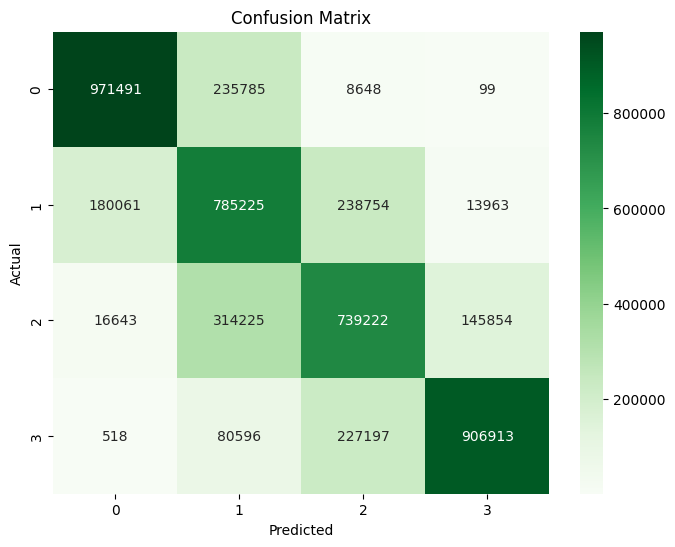

NameError: name 'label_binarize' is not defined

In [ ]:
drop_cols = ['timestamp_TW','first_login_date_TW','uuid', 'ucid', 'upid','level1_id','level2_id','level3_id','level4_id','points','content_pretty_name','points_class']
for col in df.columns:
    if df[col].dtype == 'category' or df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes
X = df.drop(columns=drop_cols)
y = df['points_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
final_model = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=100,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_score = final_model.predict_proba(X_test)
num_classes = len(np.unique(y))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

if num_classes == 2:
    y_proba = y_score[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary Classification)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (Multi-class)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()



--- SHAP Summary Plot for Class 0 ---


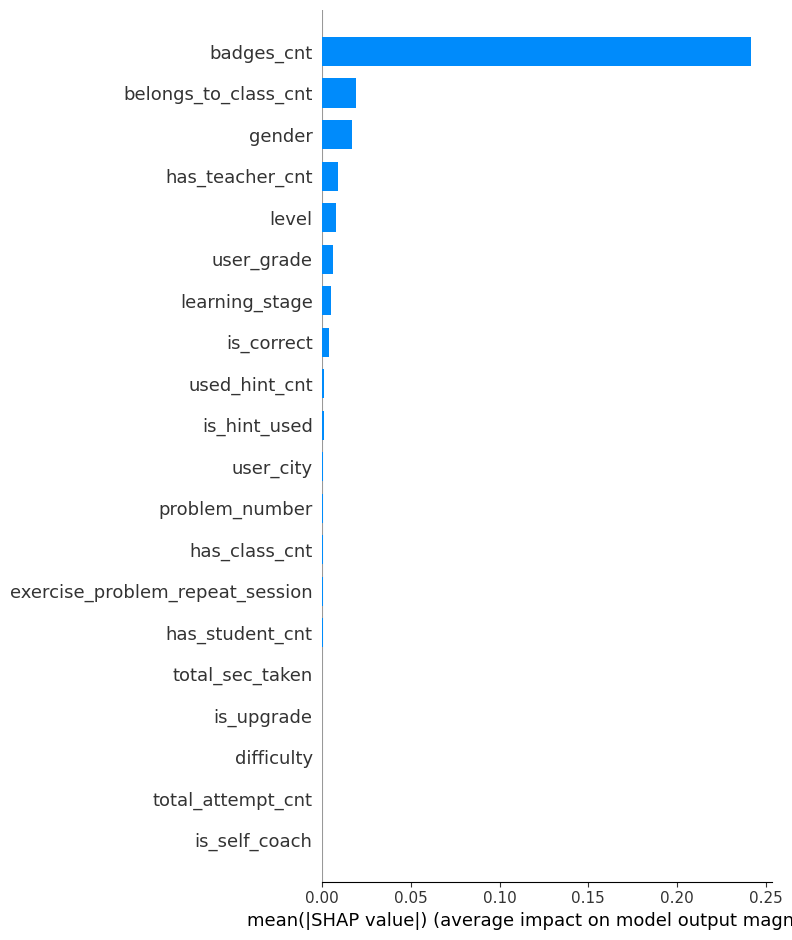


--- SHAP Summary Plot for Class 1 ---


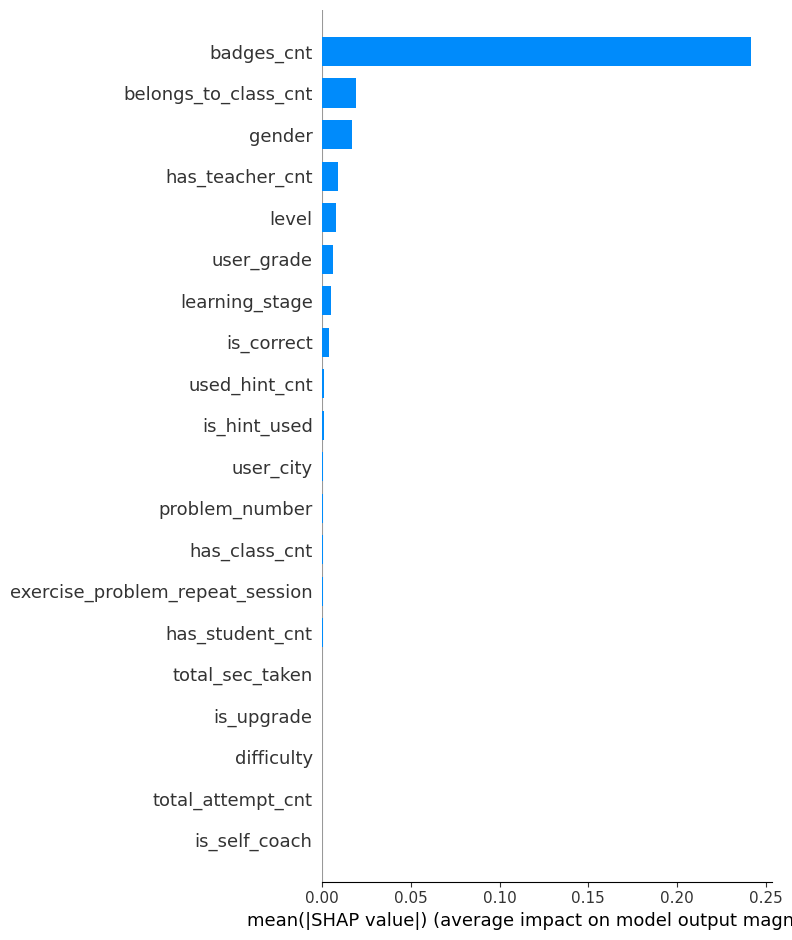


--- SHAP Summary Plot for Class 2 ---


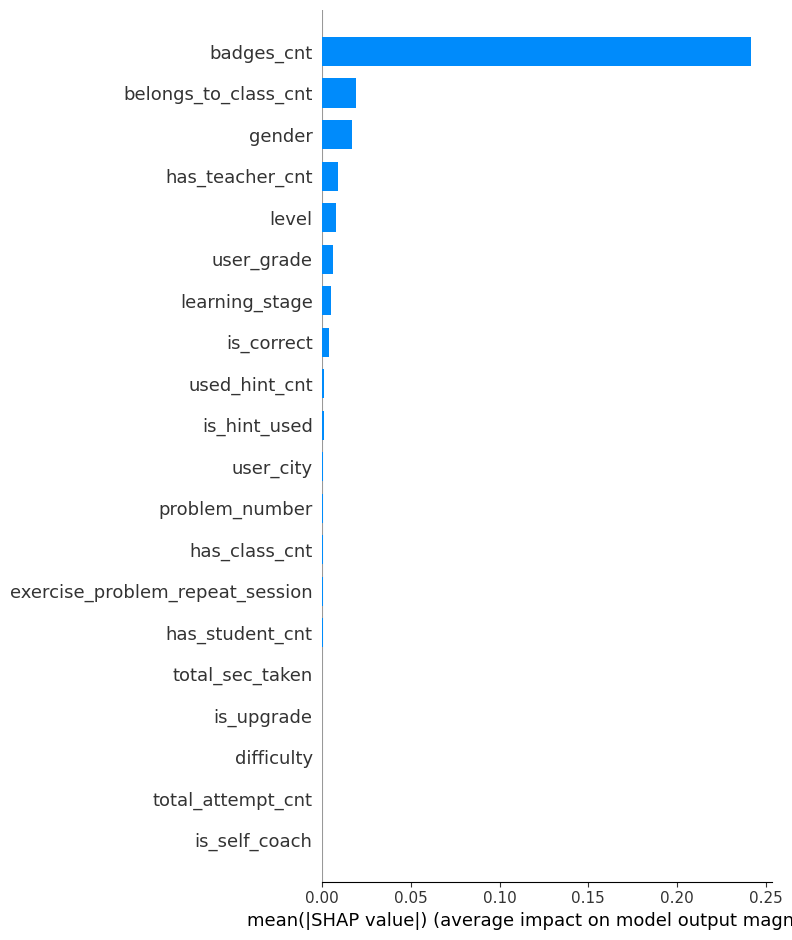

In [ ]:
# Plot summary for multi-class
if num_classes > 2:
    for i in range(0,num_classes-1):
        print(f"\n--- SHAP Summary Plot for Class {i} ---")
        shap.summary_plot(shap_values[:, :, 0], X_test, plot_type="bar")
else:
    shap.summary_plot(shap_values[1], X_test, show=True, plot_type="bar")

## GNN

In [13]:
#GCN
data, node_map = make_graph(df, features=full_features)

In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GCN', data, args), n_trials=100)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-19 11:13:52,368] A new study created in memory with name: no-name-37a65ba2-074f-4452-aeb9-9eda3f5e9100
[I 2025-05-19 11:13:53,148] Trial 0 finished with value: 0.2733097657976138 and parameters: {'hidden_channels': 32, 'lr': 0.0032301424426349886, 'dropout': 0.5531721941727261}. Best is trial 0 with value: 0.2733097657976138.
[I 2025-05-19 11:13:53,472] Trial 1 finished with value: 0.2762925320371189 and parameters: {'hidden_channels': 16, 'lr': 0.006402947137309555, 'dropout': 0.2214379331402042}. Best is trial 0 with value: 0.2733097657976138.
[I 2025-05-19 11:13:54,103] Trial 2 finished with value: 0.28811312417145385 and parameters: {'hidden_channels': 64, 'lr': 0.0020642774827999335, 'dropout': 0.2618794350249892}. Best is trial 0 with value: 0.2733097657976138.
[I 2025-05-19 11:13:54,440] Trial 3 finished with value: 0.2893283252319929 and parameters: {'hidden_channels': 16, 'lr': 0.0018777533362148678, 'dropout': 0.43475173697690467}. Best is trial 0 with value: 0.273


Best trial:
  Value (1 - accuracy): 0.2725
  Best hyperparameters:
    hidden_channels: 32
    lr: 0.0064761652479616676
    dropout: 0.3923177630203558


[GCN] Epoch 001 | Loss: 295754.3438 | Val Acc: 0.2939 | Val F1: 0.3726
[GCN] Epoch 010 | Loss: 68910.5625 | Val Acc: 0.6963 | Val F1: 0.6183
[GCN] Epoch 020 | Loss: 51466.7031 | Val Acc: 0.6594 | Val F1: 0.6077
[GCN] Epoch 030 | Loss: 27638.7734 | Val Acc: 0.6774 | Val F1: 0.6101
[GCN] Epoch 040 | Loss: 21840.6426 | Val Acc: 0.6895 | Val F1: 0.6120
[GCN] Epoch 050 | Loss: 24229.6602 | Val Acc: 0.6943 | Val F1: 0.6318
[GCN] Epoch 060 | Loss: 21308.6211 | Val Acc: 0.6950 | Val F1: 0.6324
[GCN] Epoch 070 | Loss: 22496.9395 | Val Acc: 0.7005 | Val F1: 0.6283
[GCN] Epoch 080 | Loss: 14196.1582 | Val Acc: 0.6965 | Val F1: 0.6301
[GCN] Epoch 090 | Loss: 11539.9688 | Val Acc: 0.6077 | Val F1: 0.6115
[GCN] Epoch 100 | Loss: 13753.5137 | Val Acc: 0.7109 | Val F1: 0.6347
[GCN] Epoch 110 | Loss: 9588.4238 | Val Acc: 0.7068 | Val F1: 0.6324
[GCN] Epoch 120 | Loss: 8448.5020 | Val Acc: 0.7069 | Val F1: 0.6343
[GCN] Epoch 130 | Loss: 7915.5273 | Val Acc: 0.7066 | Val F1: 0.6335
[GCN] Epoch 140 | Loss

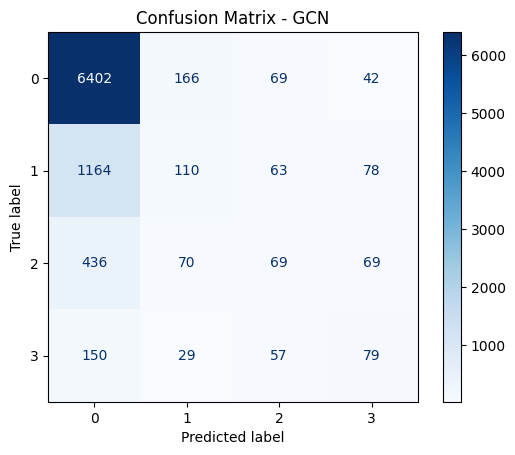

(0.7356677344526676,
 0.676457186931478,
 GCN(
   (conv1): GraphConv(-1, 32)
   (conv2): GraphConv(-1, 4)
   (dropout_layer): Dropout(p=0.3923177630203558, inplace=False)
 ),
 Data(x=[60348, 20], edge_index=[2, 3436761], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [15]:
run_experiment_classification(data, 'GCN', hidden_channels=32, lr=0.0064761652479616676, dropout=0.3923177630203558, epochs=200)

In [18]:
#GAT
data, node_map = make_graph(df, features=full_features)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GAT', data, args), n_trials=100)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-19 11:20:59,349] A new study created in memory with name: no-name-b9c8e56c-756a-47dd-8b6b-3b6deb7d6826
[I 2025-05-19 11:21:00,484] Trial 0 finished with value: 0.49458683163941675 and parameters: {'hidden_channels': 32, 'lr': 0.00015635691485194544, 'dropout': 0.22280340418173142}. Best is trial 0 with value: 0.49458683163941675.
[I 2025-05-19 11:21:01,629] Trial 1 finished with value: 0.3077772867874503 and parameters: {'hidden_channels': 32, 'lr': 0.0012998456489557882, 'dropout': 0.41379584739266506}. Best is trial 1 with value: 0.3077772867874503.
[I 2025-05-19 11:21:03,333] Trial 2 finished with value: 0.263035793194874 and parameters: {'hidden_channels': 64, 'lr': 0.0030337700425622934, 'dropout': 0.2818882483383121}. Best is trial 2 with value: 0.263035793194874.
[I 2025-05-19 11:21:04,477] Trial 3 finished with value: 0.3318603623508617 and parameters: {'hidden_channels': 32, 'lr': 0.0006509383647261363, 'dropout': 0.5772023490818898}. Best is trial 2 with value: 0.2


Best trial:
  Value (1 - accuracy): 0.2628
  Best hyperparameters:
    hidden_channels: 16
    lr: 0.004602354124142422
    dropout: 0.36822383390533664


[GAT] Epoch 001 | Loss: 4695.7041 | Val Acc: 0.7165 | Val F1: 0.6186
[GAT] Epoch 010 | Loss: 439.1164 | Val Acc: 0.7306 | Val F1: 0.6232
[GAT] Epoch 020 | Loss: 153.6693 | Val Acc: 0.7369 | Val F1: 0.6253
[GAT] Epoch 030 | Loss: 100.5513 | Val Acc: 0.7367 | Val F1: 0.6255
[GAT] Epoch 040 | Loss: 11.5226 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 050 | Loss: 16.5942 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 060 | Loss: 32.4080 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 070 | Loss: 12.2413 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 080 | Loss: 10.4720 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 090 | Loss: 11.5981 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 100 | Loss: 19.1060 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 110 | Loss: 10.0541 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 120 | Loss: 11.8958 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 130 | Loss: 3.5422 | Val Acc: 0.7369 | Val F1: 0.6258
[GAT] Epoch 140 | Loss: 21.8485 | Val Acc: 0.7369 | Val F1

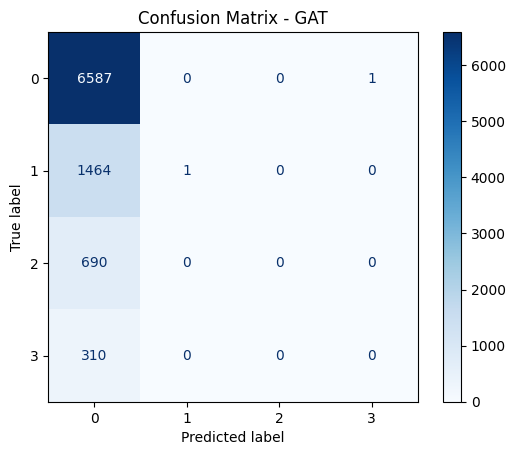

(0.727714569755882,
 0.6132338623004421,
 GAT(
   (conv1): GATConv((-1, -1), 16, heads=2)
   (conv2): GATConv((-1, -1), 4, heads=1)
 ),
 Data(x=[60348, 20], edge_index=[2, 3436761], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [19]:
run_experiment_classification(data, 'GAT', hidden_channels=16, lr=0.004602354124142422, dropout=0.36822383390533664, epochs=200)

In [20]:
#GraphSAGE
data, node_map = make_graph(df, features=full_features)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GraphSAGE', data, args), n_trials=100)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-19 11:25:05,010] A new study created in memory with name: no-name-9dfa77f2-bd19-4c92-888c-d9539a015609
[I 2025-05-19 11:25:05,728] Trial 0 finished with value: 0.2598320813079983 and parameters: {'hidden_channels': 64, 'lr': 0.00028626536217646293, 'dropout': 0.5379240984290163}. Best is trial 0 with value: 0.2598320813079983.
[I 2025-05-19 11:25:06,212] Trial 1 finished with value: 0.8889748121961998 and parameters: {'hidden_channels': 32, 'lr': 0.00023727160374963793, 'dropout': 0.3817318962209828}. Best is trial 0 with value: 0.2598320813079983.
[I 2025-05-19 11:25:06,565] Trial 2 finished with value: 0.922779496243924 and parameters: {'hidden_channels': 16, 'lr': 0.00017814851576441798, 'dropout': 0.5723040207098282}. Best is trial 0 with value: 0.2598320813079983.
[I 2025-05-19 11:25:07,022] Trial 3 finished with value: 0.2722050375607601 and parameters: {'hidden_channels': 32, 'lr': 0.0009100429529754487, 'dropout': 0.5773009276262953}. Best is trial 0 with value: 0.25


Best trial:
  Value (1 - accuracy): 0.2044
  Best hyperparameters:
    hidden_channels: 64
    lr: 0.007215582997360758
    dropout: 0.4299867149523342


[GraphSAGE] Epoch 001 | Loss: 395.3618 | Val Acc: 0.7207 | Val F1: 0.6940
[GraphSAGE] Epoch 010 | Loss: 114.8858 | Val Acc: 0.7372 | Val F1: 0.7304
[GraphSAGE] Epoch 020 | Loss: 59.6281 | Val Acc: 0.7348 | Val F1: 0.7478
[GraphSAGE] Epoch 030 | Loss: 27.8686 | Val Acc: 0.7665 | Val F1: 0.7633
[GraphSAGE] Epoch 040 | Loss: 15.0622 | Val Acc: 0.7582 | Val F1: 0.7438
[GraphSAGE] Epoch 050 | Loss: 9.3417 | Val Acc: 0.7709 | Val F1: 0.7455
[GraphSAGE] Epoch 060 | Loss: 6.2444 | Val Acc: 0.7605 | Val F1: 0.7562
[GraphSAGE] Epoch 070 | Loss: 4.8868 | Val Acc: 0.7644 | Val F1: 0.7496
[GraphSAGE] Epoch 080 | Loss: 3.3684 | Val Acc: 0.7714 | Val F1: 0.7700
[GraphSAGE] Epoch 090 | Loss: 2.6813 | Val Acc: 0.7711 | Val F1: 0.7683
[GraphSAGE] Epoch 100 | Loss: 1.9122 | Val Acc: 0.7789 | Val F1: 0.7703
[GraphSAGE] Epoch 110 | Loss: 1.6236 | Val Acc: 0.7812 | Val F1: 0.7597
[GraphSAGE] Epoch 120 | Loss: 1.2918 | Val Acc: 0.7774 | Val F1: 0.7434
[GraphSAGE] Epoch 130 | Loss: 1.1158 | Val Acc: 0.7799 | 

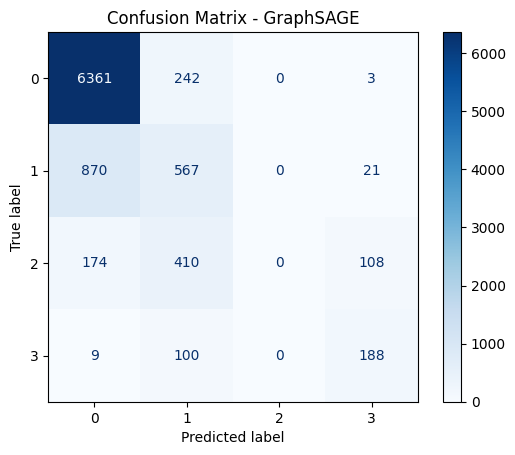

(0.7860377775323097,
 0.7479040827594696,
 GraphSAGE(
   (conv1): SAGEConv((-1, -1), 64, aggr=mean)
   (conv2): SAGEConv((-1, -1), 4, aggr=mean)
 ),
 Data(x=[60348, 20], edge_index=[2, 3436761], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [21]:
run_experiment_classification(data, 'GraphSAGE', hidden_channels=64, lr=0.007215582997360758, dropout=0.4299867149523342, epochs=200)

## EvolveGCN

In [22]:
snapshot, uuid_encoder = build_snapshots(df, time_col='timestamp_TW', uuid_col='uuid',label_col='points_class', snapshot_freq='W',feature_cols=full_features, dropna=True)
num_classes = df['points_class'].nunique()
best_params = run_optuna_evolvegcn(snapshot, num_classes, n_trials=20)
print(best_params)

[I 2025-05-19 11:33:20,331] A new study created in memory with name: no-name-9eb8470c-29d1-493a-b21b-50d76508ffbd
[I 2025-05-19 11:33:28,679] Trial 0 finished with value: 0.45631438382296835 and parameters: {'hidden_dim': 64, 'lr': 0.005210301007169776}. Best is trial 0 with value: 0.45631438382296835.
[I 2025-05-19 11:33:39,152] Trial 1 finished with value: 0.4635635253719954 and parameters: {'hidden_dim': 128, 'lr': 0.004478107699485268}. Best is trial 1 with value: 0.4635635253719954.
[I 2025-05-19 11:33:47,320] Trial 2 finished with value: 0.46928653185806946 and parameters: {'hidden_dim': 32, 'lr': 0.0028523342572519803}. Best is trial 2 with value: 0.46928653185806946.
[I 2025-05-19 11:33:55,229] Trial 3 finished with value: 0.5295688668447157 and parameters: {'hidden_dim': 32, 'lr': 0.0006095248701297983}. Best is trial 3 with value: 0.5295688668447157.
[I 2025-05-19 11:34:03,837] Trial 4 finished with value: 0.5047691720717283 and parameters: {'hidden_dim': 64, 'lr': 0.00148960

Best params: {'hidden_dim': 32, 'lr': 0.0006095248701297983}
{'hidden_dim': 32, 'lr': 0.0006095248701297983}


[EvolveGCN] Epoch 001 | Loss: 2.2933 | Acc: 0.1312 | F1: 0.0675
[EvolveGCN] Epoch 010 | Loss: 1.1380 | Acc: 0.5185 | F1: 0.4789
[EvolveGCN] Epoch 020 | Loss: 1.0407 | Acc: 0.5147 | F1: 0.5045
[EvolveGCN] Epoch 030 | Loss: 1.0184 | Acc: 0.5200 | F1: 0.5126
[EvolveGCN] Epoch 040 | Loss: 1.0177 | Acc: 0.5162 | F1: 0.4716
[EvolveGCN] Epoch 050 | Loss: 1.0014 | Acc: 0.5322 | F1: 0.5064
[EvolveGCN] Epoch 060 | Loss: 0.9847 | Acc: 0.5361 | F1: 0.5334
[EvolveGCN] Epoch 070 | Loss: 0.9928 | Acc: 0.5322 | F1: 0.5035
[EvolveGCN] Epoch 080 | Loss: 0.9803 | Acc: 0.5334 | F1: 0.5149
[EvolveGCN] Epoch 090 | Loss: 0.9844 | Acc: 0.5292 | F1: 0.4989
[EvolveGCN] Epoch 100 | Loss: 0.9812 | Acc: 0.5338 | F1: 0.5020
[EvolveGCN] Epoch 110 | Loss: 0.9872 | Acc: 0.5380 | F1: 0.5189
[EvolveGCN] Epoch 120 | Loss: 0.9732 | Acc: 0.5376 | F1: 0.5291
[EvolveGCN] Epoch 130 | Loss: 0.9689 | Acc: 0.5456 | F1: 0.5356
[EvolveGCN] Epoch 140 | Loss: 0.9884 | Acc: 0.5254 | F1: 0.5296
[EvolveGCN] Epoch 150 | Loss: 0.9719 | A

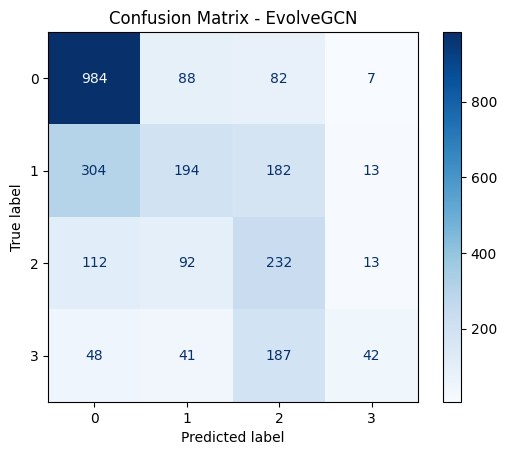

In [23]:
acc, f1, model = run_evolvegcn_experiment(snapshot,num_classes,hidden_dim=best_params['hidden_dim'],lr=best_params['lr'],epochs=200)

# RQ2

## RF

Accuracy: 0.512

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.65      0.61   1210253
           1       0.40      0.39      0.39   1211264
           2       0.43      0.39      0.41   1212215
           3       0.64      0.62      0.63   1212282

    accuracy                           0.51   4846014
   macro avg       0.51      0.51      0.51   4846014
weighted avg       0.51      0.51      0.51   4846014



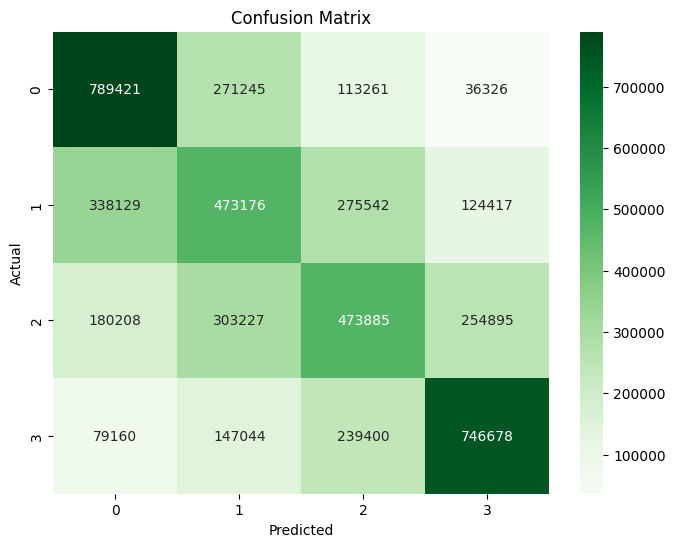

NameError: name 'label_binarize' is not defined

In [24]:
#drop_cols = ['timestamp_TW','first_login_date_TW','uuid', 'ucid', 'upid','level1_id','level2_id','level3_id','level4_id','points','content_pretty_name','points_class']
'''
for col in df.columns:
    if df[col].dtype == 'category' or df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes
'''
X = df[non_platform]
y = df['points_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
final_model = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=100,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_score = final_model.predict_proba(X_test)
num_classes = len(np.unique(y))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

if num_classes == 2:
    y_proba = y_score[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary Classification)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (Multi-class)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot summary for multi-class
if num_classes > 2:
    for i in range(0,num_classes-1):
        print(f"\n--- SHAP Summary Plot for Class {i} ---")
        shap.summary_plot(shap_values[:, :, 0], X_test, plot_type="bar")
else:
    shap.summary_plot(shap_values[1], X_test, show=True, plot_type="bar")

## GNN

[GCN] Epoch 001 | Loss: 443834.2812 | Val Acc: 0.7019 | Val F1: 0.6180
[GCN] Epoch 010 | Loss: 103375.2500 | Val Acc: 0.5326 | Val F1: 0.5397
[GCN] Epoch 020 | Loss: 85076.2109 | Val Acc: 0.4747 | Val F1: 0.5109
[GCN] Epoch 030 | Loss: 59627.1719 | Val Acc: 0.6109 | Val F1: 0.5815
[GCN] Epoch 040 | Loss: 41954.5078 | Val Acc: 0.6928 | Val F1: 0.6147
[GCN] Epoch 050 | Loss: 36730.7812 | Val Acc: 0.7139 | Val F1: 0.6256
[GCN] Epoch 060 | Loss: 34569.4922 | Val Acc: 0.7127 | Val F1: 0.6294
[GCN] Epoch 070 | Loss: 32448.1680 | Val Acc: 0.7089 | Val F1: 0.6254
[GCN] Epoch 080 | Loss: 25485.0527 | Val Acc: 0.7090 | Val F1: 0.6294
[GCN] Epoch 090 | Loss: 27815.4277 | Val Acc: 0.7096 | Val F1: 0.6249
[GCN] Epoch 100 | Loss: 21576.4492 | Val Acc: 0.6356 | Val F1: 0.6086
[GCN] Epoch 110 | Loss: 20889.6836 | Val Acc: 0.7079 | Val F1: 0.6316
[GCN] Epoch 120 | Loss: 18896.0625 | Val Acc: 0.7029 | Val F1: 0.6262
[GCN] Epoch 130 | Loss: 17993.1504 | Val Acc: 0.7099 | Val F1: 0.6276
[GCN] Epoch 140 | 

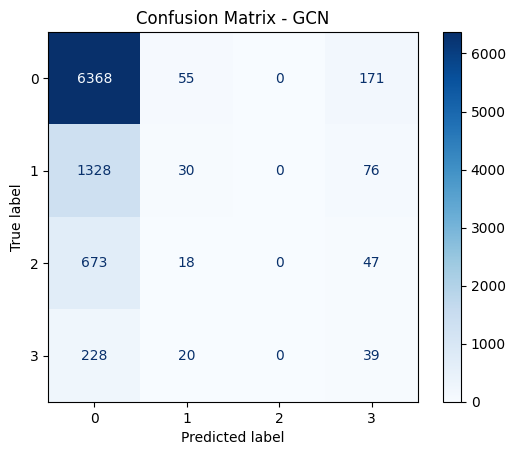

(0.71103501601679,
 0.6207575199198805,
 GCN(
   (conv1): GraphConv(-1, 32)
   (conv2): GraphConv(-1, 4)
   (dropout_layer): Dropout(p=0.3923177630203558, inplace=False)
 ),
 Data(x=[60348, 13], edge_index=[2, 3436761], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [26]:
data, node_map = make_graph(df, features=non_platform)
run_experiment_classification(data, 'GCN', hidden_channels=32, lr=0.0064761652479616676, dropout=0.3923177630203558, epochs=200)

[GAT] Epoch 001 | Loss: 33744.9805 | Val Acc: 0.1405 | Val F1: 0.1454
[GAT] Epoch 010 | Loss: 5004.0640 | Val Acc: 0.6819 | Val F1: 0.6034
[GAT] Epoch 020 | Loss: 2922.4561 | Val Acc: 0.7197 | Val F1: 0.6167
[GAT] Epoch 030 | Loss: 2572.7788 | Val Acc: 0.7232 | Val F1: 0.6180
[GAT] Epoch 040 | Loss: 2299.2664 | Val Acc: 0.7295 | Val F1: 0.6204
[GAT] Epoch 050 | Loss: 2080.6245 | Val Acc: 0.7319 | Val F1: 0.6213
[GAT] Epoch 060 | Loss: 1998.6569 | Val Acc: 0.7334 | Val F1: 0.6217
[GAT] Epoch 070 | Loss: 1591.3099 | Val Acc: 0.7338 | Val F1: 0.6218
[GAT] Epoch 080 | Loss: 1001.6132 | Val Acc: 0.7338 | Val F1: 0.6218
[GAT] Epoch 090 | Loss: 1348.7354 | Val Acc: 0.7320 | Val F1: 0.6213
[GAT] Epoch 100 | Loss: 1200.5442 | Val Acc: 0.7319 | Val F1: 0.6212
[GAT] Epoch 110 | Loss: 940.3172 | Val Acc: 0.7319 | Val F1: 0.6212
[GAT] Epoch 120 | Loss: 769.7410 | Val Acc: 0.7318 | Val F1: 0.6211
[GAT] Epoch 130 | Loss: 284.9235 | Val Acc: 0.7313 | Val F1: 0.6210
[GAT] Epoch 140 | Loss: 213.2545 | V

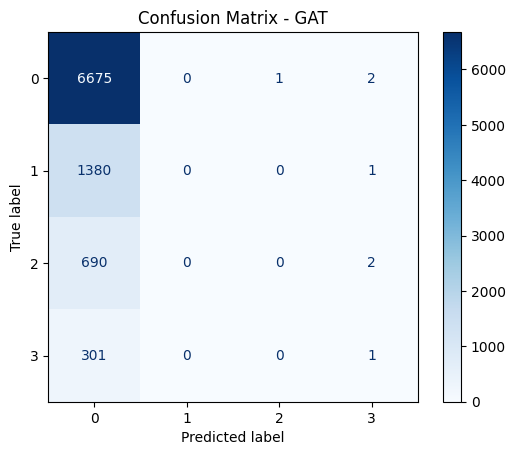

(0.7374351043852867,
 0.6265017830680937,
 GAT(
   (conv1): GATConv((-1, -1), 16, heads=2)
   (conv2): GATConv((-1, -1), 4, heads=1)
 ),
 Data(x=[60348, 13], edge_index=[2, 3436761], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [27]:
data, node_map = make_graph(df, features=non_platform)
run_experiment_classification(data, 'GAT', hidden_channels=16, lr=0.004602354124142422, dropout=0.36822383390533664, epochs=200)

[GraphSAGE] Epoch 001 | Loss: 1353.9236 | Val Acc: 0.3956 | Val F1: 0.4860
[GraphSAGE] Epoch 010 | Loss: 261.8717 | Val Acc: 0.2196 | Val F1: 0.1681
[GraphSAGE] Epoch 020 | Loss: 190.2824 | Val Acc: 0.7517 | Val F1: 0.7192
[GraphSAGE] Epoch 030 | Loss: 124.1825 | Val Acc: 0.7560 | Val F1: 0.7029
[GraphSAGE] Epoch 040 | Loss: 81.2699 | Val Acc: 0.7636 | Val F1: 0.7305
[GraphSAGE] Epoch 050 | Loss: 52.5068 | Val Acc: 0.7680 | Val F1: 0.7261
[GraphSAGE] Epoch 060 | Loss: 38.0231 | Val Acc: 0.7802 | Val F1: 0.7595
[GraphSAGE] Epoch 070 | Loss: 26.8887 | Val Acc: 0.7865 | Val F1: 0.7817
[GraphSAGE] Epoch 080 | Loss: 19.9680 | Val Acc: 0.7821 | Val F1: 0.7862
[GraphSAGE] Epoch 090 | Loss: 15.9794 | Val Acc: 0.7926 | Val F1: 0.7892
[GraphSAGE] Epoch 100 | Loss: 12.2354 | Val Acc: 0.7893 | Val F1: 0.7852
[GraphSAGE] Epoch 110 | Loss: 9.9571 | Val Acc: 0.7845 | Val F1: 0.7846
[GraphSAGE] Epoch 120 | Loss: 8.4723 | Val Acc: 0.7799 | Val F1: 0.7799
[GraphSAGE] Epoch 130 | Loss: 6.7791 | Val Acc: 

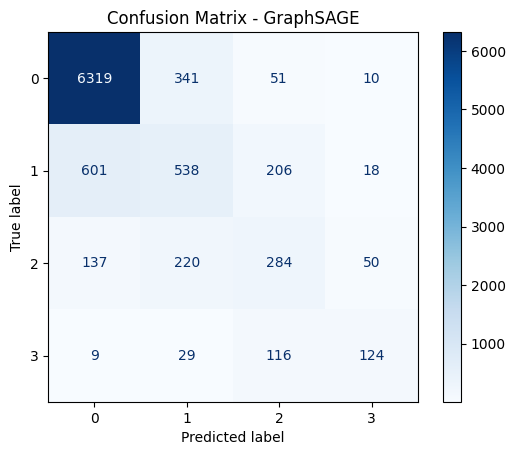

(0.8024964100298244,
 0.7935962993163715,
 GraphSAGE(
   (conv1): SAGEConv((-1, -1), 64, aggr=mean)
   (conv2): SAGEConv((-1, -1), 4, aggr=mean)
 ),
 Data(x=[60348, 13], edge_index=[2, 3436761], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [28]:
data, node_map = make_graph(df, features=non_platform)
run_experiment_classification(data, 'GraphSAGE', hidden_channels=64, lr=0.007215582997360758, dropout=0.4299867149523342, epochs=200)

## EvolveGCN

In [18]:
snapshot, uuid_encoder = build_snapshots(df, time_col='timestamp_TW', uuid_col='uuid',label_col='points_class', snapshot_freq='W',feature_cols=non_platform, dropna=True)
num_classes = df['points_class'].nunique()
best_params = run_optuna_evolvegcn(snapshot, num_classes, n_trials=20)
print(best_params)

[I 2025-05-19 12:55:44,024] A new study created in memory with name: no-name-f7668eb2-a2a7-483f-ba36-f78899c944d7
[I 2025-05-19 12:55:54,805] Trial 0 finished with value: 0.52422739412438 and parameters: {'hidden_dim': 64, 'lr': 0.00016031983905607955}. Best is trial 0 with value: 0.52422739412438.
[I 2025-05-19 12:56:08,554] Trial 1 finished with value: 0.5410148798168638 and parameters: {'hidden_dim': 128, 'lr': 0.00014123449519343987}. Best is trial 1 with value: 0.5410148798168638.
[I 2025-05-19 12:56:22,377] Trial 2 finished with value: 0.5043876383059901 and parameters: {'hidden_dim': 128, 'lr': 0.0005071849226117596}. Best is trial 1 with value: 0.5410148798168638.
[I 2025-05-19 12:56:36,163] Trial 3 finished with value: 0.49446776039679513 and parameters: {'hidden_dim': 128, 'lr': 0.0017212208999174514}. Best is trial 1 with value: 0.5410148798168638.
[I 2025-05-19 12:56:46,920] Trial 4 finished with value: 0.497138496756963 and parameters: {'hidden_dim': 64, 'lr': 0.0031123211

Best params: {'hidden_dim': 128, 'lr': 0.00014123449519343987}
{'hidden_dim': 128, 'lr': 0.00014123449519343987}


[EvolveGCN] Epoch 001 | Loss: 2.2797 | Acc: 0.1213 | F1: 0.0263
[EvolveGCN] Epoch 010 | Loss: 1.2234 | Acc: 0.4968 | F1: 0.4556
[EvolveGCN] Epoch 020 | Loss: 1.0465 | Acc: 0.5223 | F1: 0.4893
[EvolveGCN] Epoch 030 | Loss: 1.0180 | Acc: 0.5227 | F1: 0.5107
[EvolveGCN] Epoch 040 | Loss: 0.9955 | Acc: 0.5380 | F1: 0.5298
[EvolveGCN] Epoch 050 | Loss: 1.0124 | Acc: 0.5280 | F1: 0.4998
[EvolveGCN] Epoch 060 | Loss: 1.0069 | Acc: 0.5227 | F1: 0.4862
[EvolveGCN] Epoch 070 | Loss: 0.9945 | Acc: 0.5380 | F1: 0.5323
[EvolveGCN] Epoch 080 | Loss: 0.9800 | Acc: 0.5357 | F1: 0.5173
[EvolveGCN] Epoch 090 | Loss: 1.0075 | Acc: 0.5269 | F1: 0.5110
[EvolveGCN] Epoch 100 | Loss: 0.9967 | Acc: 0.5288 | F1: 0.5321
[EvolveGCN] Epoch 110 | Loss: 0.9827 | Acc: 0.5349 | F1: 0.5320
[EvolveGCN] Epoch 120 | Loss: 1.0379 | Acc: 0.5147 | F1: 0.4849
[EvolveGCN] Epoch 130 | Loss: 1.0062 | Acc: 0.5189 | F1: 0.5119
[EvolveGCN] Epoch 140 | Loss: 0.9792 | Acc: 0.5399 | F1: 0.5303
[EvolveGCN] Epoch 150 | Loss: 1.0273 | A

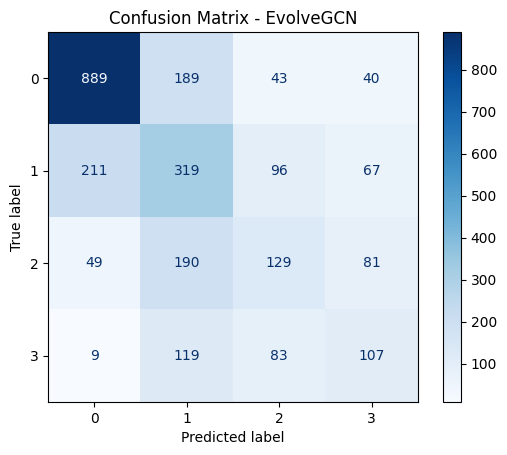

In [19]:
acc, f1, model = run_evolvegcn_experiment(snapshot,num_classes,hidden_dim=best_params['hidden_dim'],lr=best_params['lr'],epochs=200)

# RQ3

## RF

Accuracy: 0.431

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.37      0.43   1210253
           1       0.38      0.28      0.32   1211264
           2       0.37      0.44      0.40   1212215
           3       0.47      0.63      0.54   1212282

    accuracy                           0.43   4846014
   macro avg       0.43      0.43      0.42   4846014
weighted avg       0.43      0.43      0.42   4846014



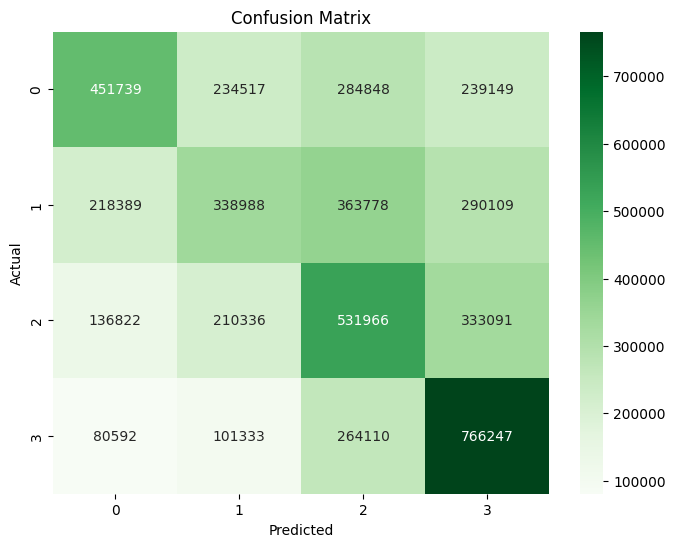

NameError: name 'label_binarize' is not defined

In [16]:
#drop_cols = ['timestamp_TW','first_login_date_TW','uuid', 'ucid', 'upid','level1_id','level2_id','level3_id','level4_id','points','content_pretty_name','points_class']
'''
for col in df.columns:
    if df[col].dtype == 'category' or df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes
'''
X = df[non_behavior]
y = df['points_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
final_model = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=100,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_score = final_model.predict_proba(X_test)
num_classes = len(np.unique(y))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

if num_classes == 2:
    y_proba = y_score[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary Classification)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (Multi-class)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot summary for multi-class
if num_classes > 2:
    for i in range(0,num_classes-1):
        print(f"\n--- SHAP Summary Plot for Class {i} ---")
        shap.summary_plot(shap_values[:, :, 0], X_test, plot_type="bar")
else:
    shap.summary_plot(shap_values[1], X_test, show=True, plot_type="bar")

## GNN

[GCN] Epoch 001 | Loss: 865.3346 | Val Acc: 0.3848 | Val F1: 0.4320
[GCN] Epoch 010 | Loss: 396.2665 | Val Acc: 0.7239 | Val F1: 0.6095
[GCN] Epoch 020 | Loss: 294.5870 | Val Acc: 0.7002 | Val F1: 0.6037
[GCN] Epoch 030 | Loss: 163.6723 | Val Acc: 0.6804 | Val F1: 0.5971
[GCN] Epoch 040 | Loss: 132.8350 | Val Acc: 0.4957 | Val F1: 0.5191
[GCN] Epoch 050 | Loss: 133.8647 | Val Acc: 0.6209 | Val F1: 0.5855
[GCN] Epoch 060 | Loss: 113.1402 | Val Acc: 0.7243 | Val F1: 0.6100
[GCN] Epoch 070 | Loss: 121.0848 | Val Acc: 0.7239 | Val F1: 0.6095
[GCN] Epoch 080 | Loss: 123.8809 | Val Acc: 0.7165 | Val F1: 0.6107
[GCN] Epoch 090 | Loss: 115.6022 | Val Acc: 0.7111 | Val F1: 0.6099
[GCN] Epoch 100 | Loss: 96.0181 | Val Acc: 0.7122 | Val F1: 0.6099
[GCN] Epoch 110 | Loss: 116.1764 | Val Acc: 0.6075 | Val F1: 0.5749
[GCN] Epoch 120 | Loss: 145.5045 | Val Acc: 0.6948 | Val F1: 0.6090
[GCN] Epoch 130 | Loss: 113.0820 | Val Acc: 0.6860 | Val F1: 0.5999
[GCN] Epoch 140 | Loss: 101.6748 | Val Acc: 0.689

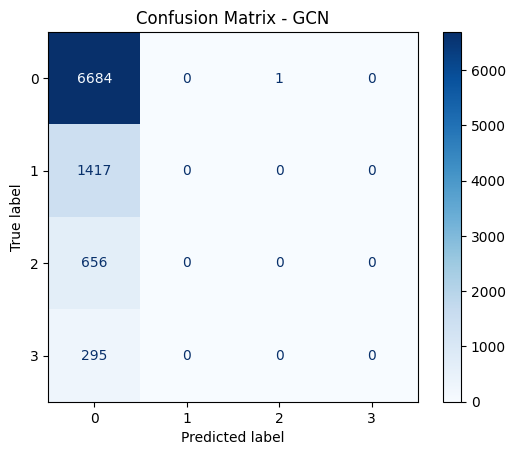

(0.7383187893515961,
 0.6272683620531766,
 GCN(
   (conv1): GraphConv(-1, 32)
   (conv2): GraphConv(-1, 4)
   (dropout_layer): Dropout(p=0.3923177630203558, inplace=False)
 ),
 Data(x=[60348, 9], edge_index=[2, 3436761], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [13]:
data, node_map = make_graph(df, features=non_behavior)
run_experiment_classification(data, 'GCN', hidden_channels=32, lr=0.0064761652479616676, dropout=0.3923177630203558, epochs=200)

[GAT] Epoch 001 | Loss: 7.8312 | Val Acc: 0.1826 | Val F1: 0.0990
[GAT] Epoch 010 | Loss: 1.1802 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 020 | Loss: 1.0350 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 030 | Loss: 0.9657 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 040 | Loss: 0.9196 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 050 | Loss: 0.9169 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 060 | Loss: 0.9001 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 070 | Loss: 0.8986 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 080 | Loss: 0.8883 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 090 | Loss: 0.8856 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 100 | Loss: 0.8849 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 110 | Loss: 0.8838 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 120 | Loss: 0.8811 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 130 | Loss: 0.8757 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoch 140 | Loss: 0.8738 | Val Acc: 0.7304 | Val F1: 0.6167
[GAT] Epoc

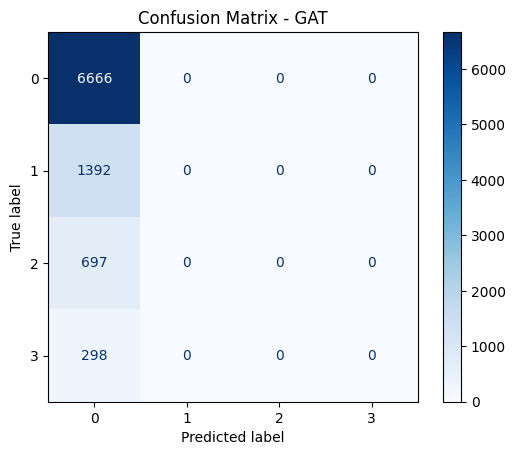

(0.7363304981773997,
 0.6245154400216995,
 GAT(
   (conv1): GATConv((-1, -1), 16, heads=2)
   (conv2): GATConv((-1, -1), 4, heads=1)
 ),
 Data(x=[60348, 9], edge_index=[2, 3436761], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [14]:
data, node_map = make_graph(df, features=non_behavior)
run_experiment_classification(data, 'GAT', hidden_channels=16, lr=0.004602354124142422, dropout=0.36822383390533664, epochs=200)

[GraphSAGE] Epoch 001 | Loss: 1.2496 | Val Acc: 0.7301 | Val F1: 0.6199
[GraphSAGE] Epoch 010 | Loss: 1.0373 | Val Acc: 0.7327 | Val F1: 0.6197
[GraphSAGE] Epoch 020 | Loss: 0.8815 | Val Acc: 0.7327 | Val F1: 0.6197
[GraphSAGE] Epoch 030 | Loss: 0.8373 | Val Acc: 0.7328 | Val F1: 0.6198
[GraphSAGE] Epoch 040 | Loss: 0.8183 | Val Acc: 0.7328 | Val F1: 0.6198
[GraphSAGE] Epoch 050 | Loss: 0.8065 | Val Acc: 0.7329 | Val F1: 0.6201
[GraphSAGE] Epoch 060 | Loss: 0.7985 | Val Acc: 0.7329 | Val F1: 0.6201
[GraphSAGE] Epoch 070 | Loss: 0.7922 | Val Acc: 0.7330 | Val F1: 0.6210
[GraphSAGE] Epoch 080 | Loss: 0.7893 | Val Acc: 0.7330 | Val F1: 0.6214
[GraphSAGE] Epoch 090 | Loss: 0.7810 | Val Acc: 0.7331 | Val F1: 0.6229
[GraphSAGE] Epoch 100 | Loss: 0.7748 | Val Acc: 0.7332 | Val F1: 0.6240
[GraphSAGE] Epoch 110 | Loss: 0.7692 | Val Acc: 0.7331 | Val F1: 0.6214
[GraphSAGE] Epoch 120 | Loss: 0.7631 | Val Acc: 0.7329 | Val F1: 0.6211
[GraphSAGE] Epoch 130 | Loss: 0.7610 | Val Acc: 0.7331 | Val F1:

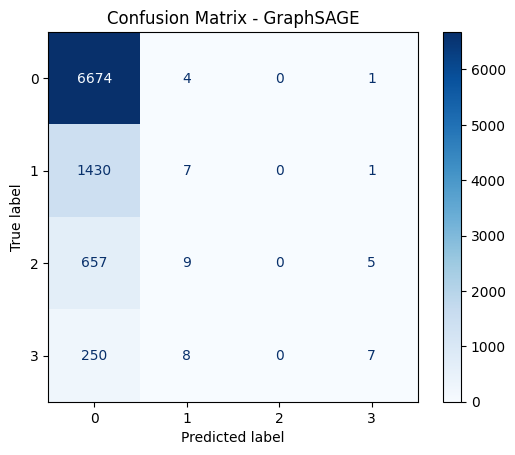

(0.7387606318347509,
 0.6306280212075266,
 GraphSAGE(
   (conv1): SAGEConv((-1, -1), 64, aggr=mean)
   (conv2): SAGEConv((-1, -1), 4, aggr=mean)
 ),
 Data(x=[60348, 9], edge_index=[2, 3436761], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [15]:
data, node_map = make_graph(df, features=non_behavior)
run_experiment_classification(data, 'GraphSAGE', hidden_channels=64, lr=0.007215582997360758, dropout=0.4299867149523342, epochs=200)

## EvolveGCN

[I 2025-05-19 12:44:25,617] A new study created in memory with name: no-name-f78c48a5-4bc5-4068-b678-b5fddeafe371
[I 2025-05-19 12:44:35,499] Trial 0 finished with value: 0.44296070202212895 and parameters: {'hidden_dim': 32, 'lr': 0.0002329984671395067}. Best is trial 0 with value: 0.44296070202212895.
[I 2025-05-19 12:44:45,564] Trial 1 finished with value: 0.4463945059137734 and parameters: {'hidden_dim': 32, 'lr': 0.001545155853861086}. Best is trial 1 with value: 0.4463945059137734.
[I 2025-05-19 12:44:57,700] Trial 2 finished with value: 0.44296070202212895 and parameters: {'hidden_dim': 128, 'lr': 0.008663305217220123}. Best is trial 1 with value: 0.4463945059137734.
[I 2025-05-19 12:45:07,910] Trial 3 finished with value: 0.4505913773368943 and parameters: {'hidden_dim': 64, 'lr': 0.00042534180876302766}. Best is trial 3 with value: 0.4505913773368943.
[I 2025-05-19 12:45:19,797] Trial 4 finished with value: 0.44296070202212895 and parameters: {'hidden_dim': 128, 'lr': 0.009687

Best params: {'hidden_dim': 64, 'lr': 0.00040007053542369}
{'hidden_dim': 64, 'lr': 0.00040007053542369}
[EvolveGCN] Epoch 001 | Loss: 1.3765 | Acc: 0.2732 | F1: 0.1551
[EvolveGCN] Epoch 010 | Loss: 1.2743 | Acc: 0.4430 | F1: 0.2720
[EvolveGCN] Epoch 020 | Loss: 1.2579 | Acc: 0.4430 | F1: 0.2720
[EvolveGCN] Epoch 030 | Loss: 1.2643 | Acc: 0.4430 | F1: 0.2720
[EvolveGCN] Epoch 040 | Loss: 1.2587 | Acc: 0.4430 | F1: 0.2720
[EvolveGCN] Epoch 050 | Loss: 1.2456 | Acc: 0.4502 | F1: 0.2971
[EvolveGCN] Epoch 060 | Loss: 1.2570 | Acc: 0.4441 | F1: 0.2753
[EvolveGCN] Epoch 070 | Loss: 1.2454 | Acc: 0.4452 | F1: 0.2851
[EvolveGCN] Epoch 080 | Loss: 1.2399 | Acc: 0.4563 | F1: 0.3233
[EvolveGCN] Epoch 090 | Loss: 1.2364 | Acc: 0.4617 | F1: 0.3381
[EvolveGCN] Epoch 100 | Loss: 1.2313 | Acc: 0.4544 | F1: 0.3094
[EvolveGCN] Epoch 110 | Loss: 1.2450 | Acc: 0.4426 | F1: 0.2734
[EvolveGCN] Epoch 120 | Loss: 1.2369 | Acc: 0.4582 | F1: 0.3258
[EvolveGCN] Epoch 130 | Loss: 1.2302 | Acc: 0.4609 | F1: 0.3356

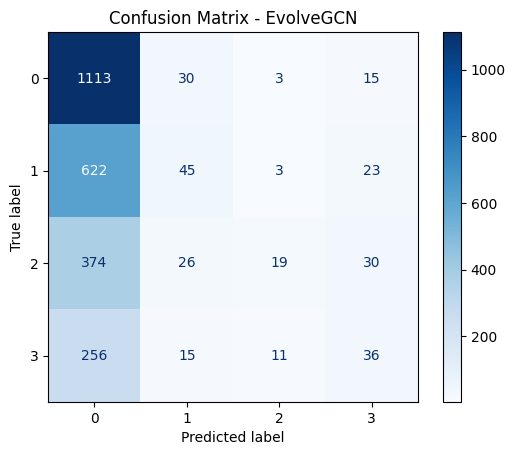

In [17]:
#snapshot, uuid_encoder = build_snapshots(df, time_col='timestamp_TW', uuid_col='uuid',label_col='points_class', snapshot_freq='W',feature_cols=non_behavior, dropna=True)
num_classes = df['points_class'].nunique()
best_params = run_optuna_evolvegcn(snapshot, num_classes, n_trials=20)
print(best_params)
acc, f1, model = run_evolvegcn_experiment(snapshot,num_classes,hidden_dim=best_params['hidden_dim'],lr=best_params['lr'],epochs=200)

# Baseline: RF, XGBoost

### RF Try 3

In [ ]:
from sklearn.preprocessing import LabelEncoder
df.replace({'True': True, 'False': False}, inplace=True)
bool_cols = ['is_correct', 'is_hint_used', 'is_downgrade', 'is_upgrade', 'is_self_coach']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].fillna(False).astype(bool)

num_cols = ['badges_cnt', 'level', 'total_sec_taken', 'used_hint_cnt']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)


cat_cols = ['gender', 'user_city', 'content_kind', 'difficulty', 'subject', 'learning_stage']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)  # RF 不接受 bool，轉成 0/1
df.dropna(inplace=True)
df['points_class'] = pd.qcut(df['points'], q=4, labels=False)

<ipython-input-3-5ec89cae845b>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(bool)
<ipython-input-3-5ec89cae845b>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(bool)


In [ ]:
import shap
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)
if num_classes > 2:
    for i in range(0,num_classes-1):
        print(f"\n--- SHAP Summary Plot for Class {i} ---")
        shap.summary_plot(shap_values[:, :, 0], X_test, plot_type="bar")
else:
  shap.summary_plot(shap_values[1], X_test, show=True, plot_type="bar")

### RF Try 2

In [ ]:
#drop_cols = ['timestamp_TW','first_login_date_TW','uuid', 'ucid', 'upid','level1_id','level2_id','level3_id','level4_id','points','content_pretty_name']
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df.replace({'True': True, 'False': False}, inplace=True)
bool_cols = ['is_correct', 'is_hint_used', 'is_downgrade', 'is_upgrade', 'is_self_coach']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].fillna(False).astype(bool)

num_cols = ['badges_cnt', 'level', 'total_sec_taken', 'used_hint_cnt']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)


cat_cols = ['gender', 'user_city', 'content_kind', 'difficulty', 'subject', 'learning_stage']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)  # RF 不接受 bool，轉成 0/1
df.dropna(inplace=True)
df['points_class'] = pd.qcut(df['points'], q=4, labels=False)

<ipython-input-3-f784779fa2b1>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(bool)
<ipython-input-3-f784779fa2b1>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(bool)


Accuracy: 0.621

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79    122000
           1       0.49      0.59      0.53    121187
           2       0.50      0.41      0.45    121804
           3       0.72      0.69      0.71    121529

    accuracy                           0.62    486520
   macro avg       0.62      0.62      0.62    486520
weighted avg       0.62      0.62      0.62    486520



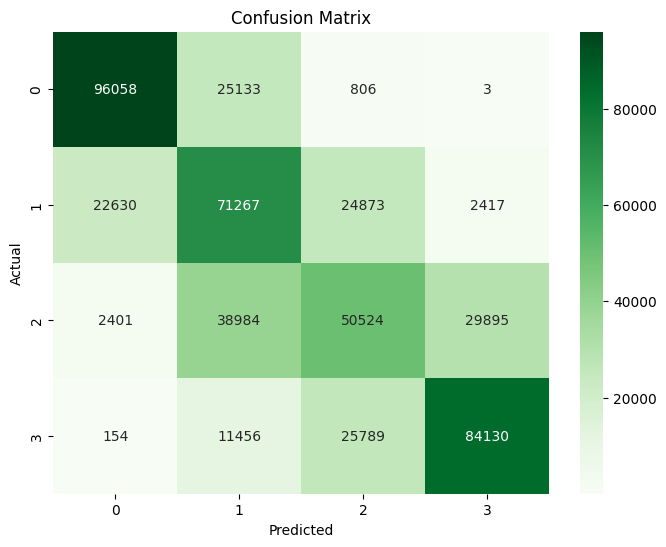

"\nif num_classes == 2:\n    y_proba = y_score[:, 1]\n    fpr, tpr, _ = roc_curve(y_test, y_proba)\n    auc = roc_auc_score(y_test, y_proba)\n\n    plt.figure()\n    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')\n    plt.plot([0, 1], [0, 1], 'k--')\n    plt.xlabel('False Positive Rate')\n    plt.ylabel('True Positive Rate')\n    plt.title('ROC Curve (Binary Classification)')\n    plt.legend()\n    plt.grid(True)\n    plt.show()\nelse:\n    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))\n    plt.figure(figsize=(10, 8))\n    for i in range(num_classes):\n        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])\n        auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])\n        plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc:.3f})')\n\n    plt.plot([0, 1], [0, 1], 'k--')\n    plt.title('ROC Curve (Multi-class)')\n    plt.xlabel('False Positive Rate')\n    plt.ylabel('True Positive Rate')\n    plt.legend()\n    plt.grid(True)\n    plt.show()\n"

In [ ]:
# === Final Training on Full Data ===
# Use best params from above
import seaborn as sns

drop_cols = ['timestamp_TW','first_login_date_TW','uuid', 'ucid', 'upid','level1_id','level2_id','level3_id','level4_id','points','content_pretty_name','points_class']
for col in df.columns:
    if df[col].dtype == 'category' or df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes
df = df.sample(frac=0.1, random_state=42)
X = df.drop(columns=drop_cols)
y = df['points_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#final_model = RandomForestClassifier(max_depth=10, max_features= 'sqrt', n_estimators=100, random_state=42)
final_model = RandomForestClassifier(max_depth=5,max_features=0.5,n_estimators=50,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)

final_model.fit(X_train, y_train)
'''
def batch_predict(model, X, batch_size=100_000):
    y_preds = []
    for i in range(0, len(X), batch_size):
        X_batch = X.iloc[i:i + batch_size]
        y_batch_pred = model.predict(X_batch)
        y_preds.append(y_batch_pred)
    return np.concatenate(y_preds)
'''
y_pred = final_model.predict(X_test)

#y_score = final_model.predict_proba(X_test)
#num_classes = len(np.unique(y))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
'''
if num_classes == 2:
    y_proba = y_score[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary Classification)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (Multi-class)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
'''

In [ ]:
# === SHAP Feature Importance ===
import shap
num_classes = len(np.unique(y))
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)
for i in range(num_classes):
    print(f"Class {i} SHAP shape: {np.shape(shap_values[i])}")

'''
# Plot summary for multi-class
if num_classes > 2:
    for i in range(num_classes):
        print(f"\n--- SHAP Summary Plot for Class {i} ---")
        shap.summary_plot(shap_values[i], X_test, show=True, plot_type="bar")
else:
    # Binary classification
    shap.summary_plot(shap_values[1], X_test, show=True, plot_type="bar")

# Optional: global SHAP summary dot plot
if num_classes == 2:
    shap.summary_plot(shap_values[1], X_test, show=True)
else:
    shap.summary_plot(shap_values[0], X_test, show=True)  # you can change class index if needed
'''

Class 0 SHAP shape: (23, 4)
Class 1 SHAP shape: (23, 4)
Class 2 SHAP shape: (23, 4)
Class 3 SHAP shape: (23, 4)


'\n# Plot summary for multi-class\nif num_classes > 2:\n    for i in range(num_classes):\n        print(f"\n--- SHAP Summary Plot for Class {i} ---")\n        shap.summary_plot(shap_values[i], X_test, show=True, plot_type="bar")\nelse:\n    # Binary classification\n    shap.summary_plot(shap_values[1], X_test, show=True, plot_type="bar")\n\n# Optional: global SHAP summary dot plot\nif num_classes == 2:\n    shap.summary_plot(shap_values[1], X_test, show=True)\nelse:\n    shap.summary_plot(shap_values[0], X_test, show=True)  # you can change class index if needed\n'

In [ ]:
shap_values.shape

(486520, 23, 4)

### RF Try1

In [ ]:
# === Hyperparameter Tuning on Sample (5%) ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats

df_sampled = df.sample(frac=0.05, random_state=42)
X_sample = df_sampled.drop(columns=drop_cols)
y_sample = df_sampled['points']
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42, stratify=y_sample
)

param_dist = {
    'n_estimators': stats.randint(100, 300),
    'max_depth': stats.randint(5, 20),
    'min_samples_split': stats.randint(2, 10),
    'min_samples_leaf': stats.randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=5,
    scoring='accuracy',
    cv=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_sample_train, y_sample_train)
best_params = random_search.best_params_
print("Best Hyperparameters Found:", best_params)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_pa

Best Hyperparameters Found: {'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 291}


Accuracy: 0.919

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95   1211526
           1       0.87      0.90      0.89   1211510
           2       0.88      0.90      0.89   1211841
           3       0.98      0.93      0.95   1211137

    accuracy                           0.92   4846014
   macro avg       0.92      0.92      0.92   4846014
weighted avg       0.92      0.92      0.92   4846014



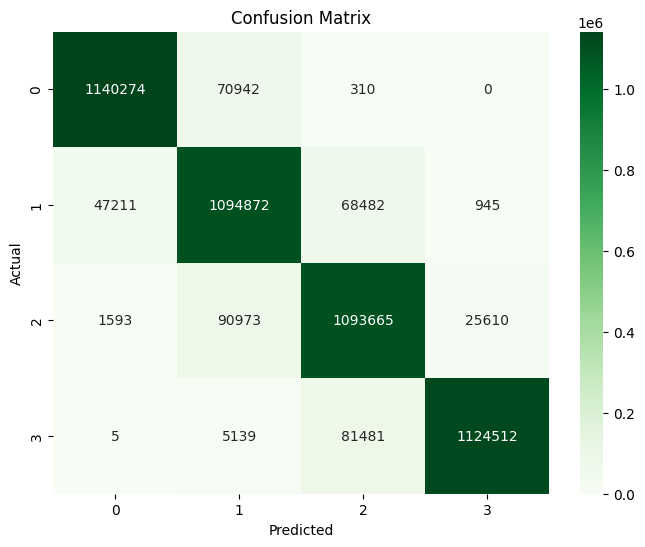

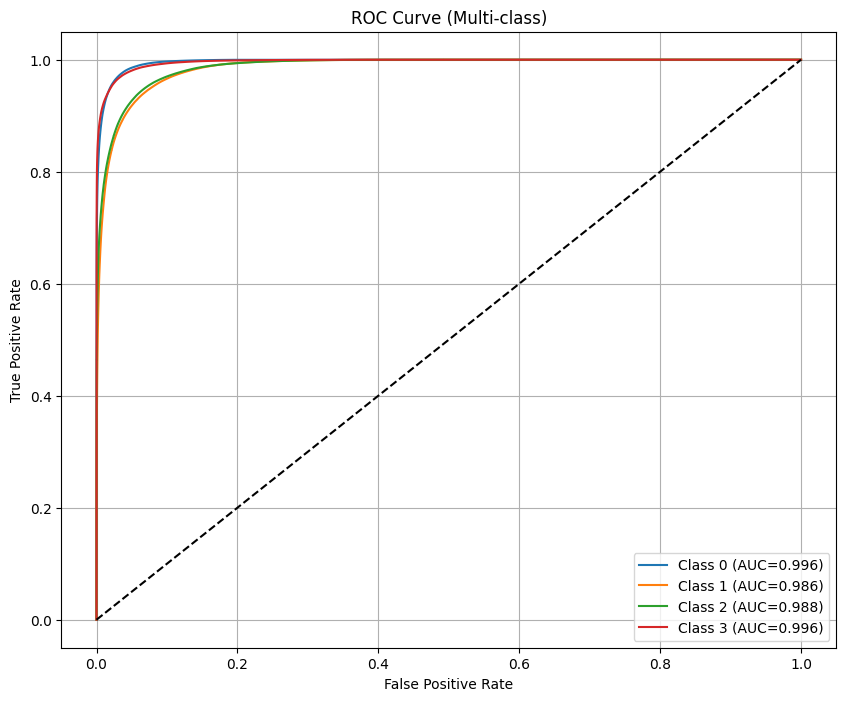

In [ ]:
# === Final Training on Full Data ===
X = df.drop(columns=drop_cols)
y = df['points_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Use best params from above
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_score = final_model.predict_proba(X_test)
num_classes = len(np.unique(y))

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
if num_classes == 2:
    y_proba = y_score[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary Classification)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (Multi-class)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:34:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:35:10] WARNING: /workspac

Accuracy: 0.986

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98   1210253
           1       0.98      0.97      0.97   1211264
           2       1.00      0.99      1.00   1212215
           3       1.00      1.00      1.00   1212282

    accuracy                           0.99   4846014
   macro avg       0.99      0.99      0.99   4846014
weighted avg       0.99      0.99      0.99   4846014



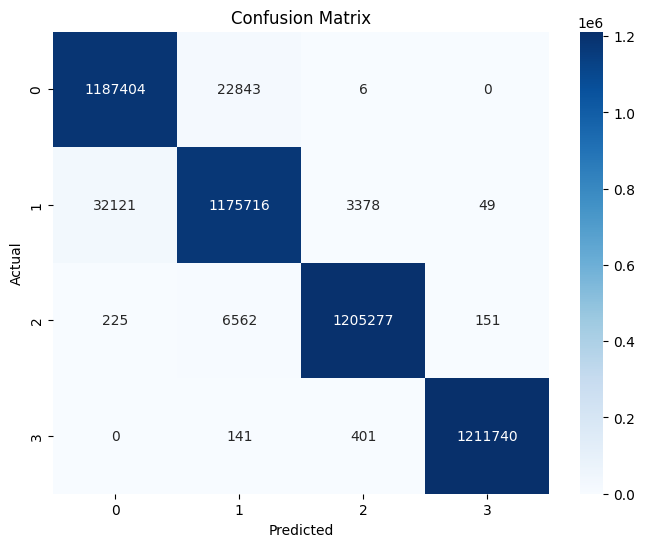

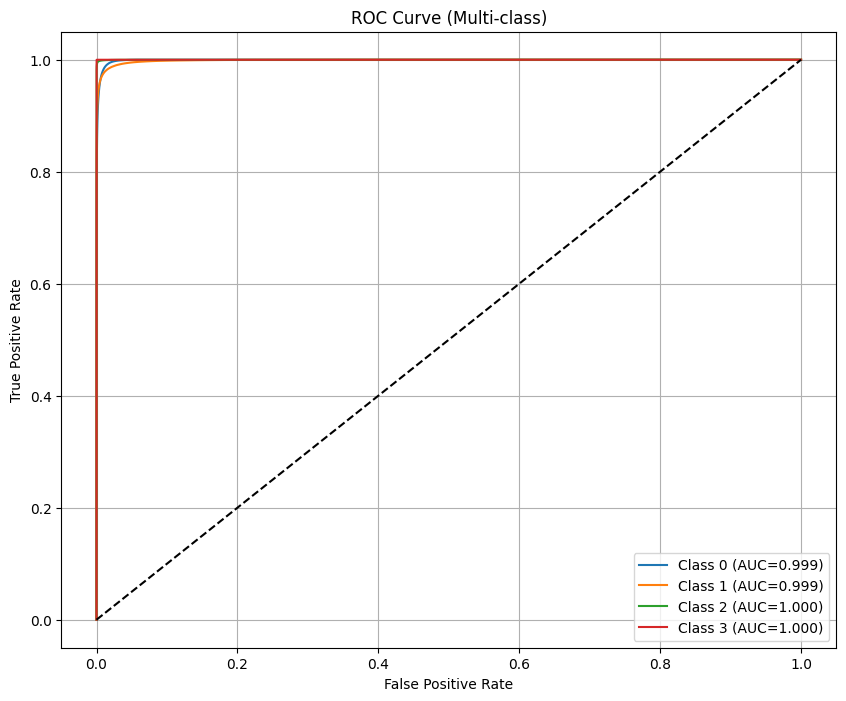

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

# === 資料處理 ===
df = df.copy()
X = df.drop(columns=drop_cols)
y = df['points_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === 超參數空間 ===
param_dist = {
    'n_estimators': stats.randint(100, 300),
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.2),
    'subsample': stats.uniform(0.6, 0.4),
    'colsample_bytree': stats.uniform(0.6, 0.4),
    'gamma': stats.uniform(0, 5)
}

# === 模型訓練（GPU 支援）===
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=5,
    scoring='accuracy',
    cv=2,
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_

# === 預測與評估 ===
y_pred = best_xgb.predict(X_test)
y_score = best_xgb.predict_proba(X_test)
num_classes = len(np.unique(y_test))

# === 準確率 ===
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

# === 分類報告 ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# === 混淆矩陣視覺化 ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# === ROC 曲線 ===
if num_classes == 2:
    y_proba = y_score[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary Classification)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    # 多類別 → Binarize 每一類別
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (Multi-class)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


# GCN, GAT, GraphSAGE

In [ ]:
#SHAP top features: badges_cnt, belongs_to_class_cnt, gender, has_teacher_cnt, level, user_grade, learning_stage, is_correct

In [ ]:
#temporal features
#rolling_login_freq_7d, rolling_mean_hints_usage_10_problems, rolling_correctness_ratio_10_problems, rolling_sum_total_attempt_cnt_5_problems

#basic user features, [] means created features -> feed into graph
#user_grade:max, user_city_encoded, [max_difficulty], [max_days_since_first_login], [average_weekly_login_frequency], [average_hints_usage]

#platform specific features
#has_teacher_cnt	is_self_coach	has_student_cnt	belongs_to_class_cnt	has_class_cnt

In [ ]:
#node: uuid
#label: points_class
#edge: ucid, upid
#node features:
  #1 (with platform specific features): has_teacher_cnt	is_self_coach	has_student_cnt	belongs_to_class_cnt	has_class_cnt, user_grade:max, user_city_encoded, max_difficulty, max_days_since_first_login, average_weekly_login_frequency, average_hints_usage, rolling_login_freq_7d, rolling_mean_hints_usage_10_problems, rolling_correctness_ratio_10_problems, rolling_sum_total_attempt_cnt_5_problems
  #2 (without platform specific features): user_grade:max, user_city_encoded, max_difficulty, max_days_since_first_login, average_weekly_login_frequency, average_hints_usage, rolling_login_freq_7d, rolling_mean_hints_usage_10_problems, rolling_correctness_ratio_10_problems, rolling_sum_total_attempt_cnt_5_problems

### Function prep

In [ ]:
!pip install torch_geometric
!pip install optuna
import torch
from torch_geometric.data import Data
import itertools
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import copy
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch_geometric.nn import GraphConv, GATConv, SAGEConv
from torch_geometric.explain import Explainer, GNNExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.5 MB/s eta 0:00:00


In [ ]:
#Graph prep, aggregate uuid to make one graph

def make_graph(df_raw, features=None, edge_types=('upid', 'ucid')):
    df_sorted = df_raw.sort_values(by='total_sec_taken', ascending=False)
    for col in df_sorted.columns:
      if df_sorted[col].dtype.name == 'category' or df_sorted[col].dtype == 'object':
          try:
              df_sorted[col] = df_sorted[col].astype(float)
          except:
              df_sorted[col] = df_sorted[col].astype('category').cat.codes
    agg_dict = {
        'total_sec_taken': 'sum',
        'total_attempt_cnt': 'sum',
        'used_hint_cnt': 'sum',
        'points_class': 'first',
        'badges_cnt': 'sum',
        'is_hint_used': 'mean',
        'is_upgrade': 'mean',
        'is_downgrade': 'mean',
        'is_correct': 'mean',
        'problem_number': 'mean',
        'exercise_problem_repeat_session': 'mean',
        'user_grade': 'max',
        'difficulty': 'max',
        'learning_stage': 'max',
        'has_teacher_cnt': 'max',
        'is_self_coach': 'max',
        'has_student_cnt': 'max',
        'belongs_to_class_cnt': 'max',
        'has_class_cnt': 'max',
        'user_city_encoded': 'max',
        'max_difficulty': 'max',
        'max_days_since_first_login': 'max',
        'average_weekly_login_frequency': 'max',
        'average_hints_usage': 'max',
        'rolling_login_freq_7d': 'max',
        'rolling_mean_hints_usage_10_problems': 'max',
        'rolling_correctness_ratio_10_problems': 'max',
        'rolling_sum_total_attempt_cnt_5_problems': 'max',
    }

    df = df_sorted.groupby('uuid').agg(agg_dict).reset_index()
    upid_map = df_sorted.drop_duplicates('uuid', keep='first').set_index('uuid')['upid']
    ucid_map = df_sorted.drop_duplicates('uuid', keep='first').set_index('uuid')['ucid']
    df['upid'] = df['uuid'].map(upid_map)
    df['ucid'] = df['uuid'].map(ucid_map)

    # default features
    if features is None:
        features = [
            'has_teacher_cnt', 'is_self_coach', 'has_student_cnt', 'belongs_to_class_cnt', 'has_class_cnt',
            'user_grade', 'user_city_encoded', 'max_difficulty', 'max_days_since_first_login',
            'average_weekly_login_frequency', 'average_hints_usage', 'rolling_login_freq_7d',
            'rolling_mean_hints_usage_10_problems', 'rolling_correctness_ratio_10_problems',
            'rolling_sum_total_attempt_cnt_5_problems', 'problem_number', 'exercise_problem_repeat_session',
            'is_correct', 'is_hint_used', 'is_downgrade', 'is_upgrade'
        ]

    # node features
    node_features = df[features]
    x = torch.tensor(node_features.values, dtype=torch.float)
    x = torch.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)

    # labels
    y = torch.tensor(df['points_class'].astype(int).values, dtype=torch.long)

    # node index mapping
    df['node_id'] = df.reset_index().index
    uuid2node = dict(zip(df['uuid'], df['node_id']))

    # edge building
    import itertools
    import numpy as np
    from torch_geometric.data import Data

    all_edges = []
    for etype in edge_types:
        for _, group in df.groupby(etype):
            users = group['node_id'].tolist()
            if len(users) >= 2:
                all_edges.extend(itertools.combinations(users, 2))

    if all_edges:
        all_edges = np.unique(np.array(all_edges), axis=0)
        edge_index = torch.tensor(all_edges.T, dtype=torch.long)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)

    # build PyG data
    data = Data(x=x, edge_index=edge_index, y=y)

    # mask split
    num_nodes = data.num_nodes
    idx = np.random.permutation(num_nodes)
    train_cut = int(0.7 * num_nodes)
    val_cut = int(0.85 * num_nodes)
    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.train_mask[idx[:train_cut]] = True
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask[idx[train_cut:val_cut]] = True
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask[idx[val_cut:]] = True

    return data, df[['uuid', 'node_id']]

#with platform features
#platform_data, node_map = make_graph(df)

#no platform features
basic_features = [
    'user_grade', 'user_city_encoded', 'max_difficulty', 'max_days_since_first_login',
    'average_weekly_login_frequency', 'average_hints_usage', 'rolling_login_freq_7d',
    'rolling_mean_hints_usage_10_problems', 'rolling_correctness_ratio_10_problems',
    'rolling_sum_total_attempt_cnt_5_problems'
]


In [ ]:
class GCN(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GraphConv(-1, hidden_channels)
        self.conv2 = GraphConv(-1, out_channels)
        self.dropout_layer = nn.Dropout(p=self.dropout)

    def forward(self, x, edge_index):
        x = self.dropout_layer(x)
        x = self.conv1(x, edge_index).relu()
        x = self.dropout_layer(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(nn.Module):
    def __init__(self, hidden_channels, out_channels, heads=2, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv((-1, -1), hidden_channels, heads=heads, dropout=dropout, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels, heads=1, concat=False, dropout=dropout, add_self_loops=False)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
# === 訓練與評估函式（分類任務） ===
import argparse
args = argparse.Namespace()
args.epochs = 30
args.heads = 2 # used for GAT
def run_experiment_classification(data, model_type, hidden_channels=None, lr=None, dropout=None, epochs=100, heads=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_copy = copy.deepcopy(data).to(device)
    num_classes = int(data_copy.y.max().item()) + 1

    if model_type == 'GCN':
        model = GCN(hidden_channels, out_channels=num_classes, dropout=dropout).to(device)
    elif model_type == 'GAT':
        model = GAT(hidden_channels, out_channels=num_classes, heads=heads, dropout=dropout).to(device)
    elif model_type == 'GraphSAGE':
        model = GraphSAGE(hidden_channels, out_channels=num_classes).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data_copy.x, data_copy.edge_index)
        loss = loss_fn(out[data_copy.train_mask], data_copy.y[data_copy.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_copy.x, data_copy.edge_index)
            val_pred = out[data_copy.val_mask].argmax(dim=1)
            val_true = data_copy.y[data_copy.val_mask]
            val_acc = accuracy_score(val_true.cpu(), val_pred.cpu())
            val_f1 = f1_score(val_true.cpu(), val_pred.cpu(), average='weighted')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())

        if epoch % 10 == 0 or epoch == 1:
            print(f"[{model_type}] Epoch {epoch:03d} | Loss: {loss:.4f} "
                  f"| Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    model.load_state_dict(best_model_state)
    model.eval()
    with torch.no_grad():
        out = model(data_copy.x, data_copy.edge_index)
        test_pred = out[data_copy.test_mask].argmax(dim=1)
        test_true = data_copy.y[data_copy.test_mask]
        test_acc = accuracy_score(test_true.cpu(), test_pred.cpu())
        test_f1 = f1_score(test_true.cpu(), test_pred.cpu(), average='weighted')

    print(f"[{model_type}] Test Acc: {test_acc:.4f} | F1: {test_f1:.4f}")

    # === GNNExplainer 視覺化 ===
    node_index = int(data_copy.test_mask.nonzero(as_tuple=True)[0][0])
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs'
        ),
    )
    explanation = explainer(data_copy.x, data_copy.edge_index, index=node_index)
    print(f"Available explanations: {explanation.available_explanations}")
    explanation.visualize_feature_importance('feature_importance.png', top_k=10)
    explanation.visualize_graph('subgraph.pdf')

    cm = confusion_matrix(test_true.cpu(), test_pred.cpu())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_type}")
    plt.savefig("confusion_matrix.png")
    plt.show()

    return test_acc, test_f1, model, data_copy

In [ ]:
# === Optuna 目標函數 ===
def objective_classification(trial, model_name, data, args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32, 64])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.2, 0.6)

    args.hidden_channels = hidden_channels
    args.dropout = dropout
    args.lr = lr

    num_classes = int(data.y.max().item()) + 1

    if model_name == 'GCN':
        model = GCN(hidden_channels, out_channels=num_classes, dropout=dropout).to(device)
    elif model_name == 'GAT':
        model = GAT(hidden_channels, out_channels=num_classes, heads=args.heads, dropout=dropout).to(device)
    elif model_name == 'GraphSAGE':
        model = GraphSAGE(hidden_channels, out_channels=num_classes).to(device)
    else:
        raise ValueError(f"Unknown model {model_name}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    data_copy = copy.deepcopy(data).to(device)

    best_val_acc = 0
    for epoch in range(args.epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_copy.x, data_copy.edge_index)
        loss = loss_fn(out[data_copy.train_mask], data_copy.y[data_copy.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_copy.x, data_copy.edge_index)
            val_pred = out[data_copy.val_mask].argmax(dim=1)
            val_true = data_copy.y[data_copy.val_mask]
            val_acc = accuracy_score(val_true.cpu(), val_pred.cpu())
            if val_acc > best_val_acc:
                best_val_acc = val_acc

    del model, optimizer, data_copy
    torch.cuda.empty_cache()
    return 1 - best_val_acc

### Run - without platform features

In [ ]:
#GCN
selected_features = [
    'user_grade', 'user_city_encoded', 'max_difficulty', 'max_days_since_first_login',
    'average_weekly_login_frequency', 'average_hints_usage', 'rolling_login_freq_7d',
    'rolling_mean_hints_usage_10_problems', 'rolling_correctness_ratio_10_problems',
    'rolling_sum_total_attempt_cnt_5_problems'
]
data, node_map = make_graph(df, features=selected_features)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GCN', data, args), n_trials=100)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-16 20:19:06,670] A new study created in memory with name: no-name-61dadfac-4497-44eb-90a1-025a534065df
[I 2025-05-16 20:19:07,081] Trial 0 finished with value: 0.33274414494034465 and parameters: {'hidden_channels': 32, 'lr': 0.00019584078759498513, 'dropout': 0.43556196454752605}. Best is trial 0 with value: 0.33274414494034465.
[I 2025-05-16 20:19:07,376] Trial 1 finished with value: 0.8967079098541759 and parameters: {'hidden_channels': 16, 'lr': 0.0003074571862902039, 'dropout': 0.5220324389409121}. Best is trial 0 with value: 0.33274414494034465.
[I 2025-05-16 20:19:07,958] Trial 2 finished with value: 0.2791648254529385 and parameters: {'hidden_channels': 64, 'lr': 0.00023428798831302342, 'dropout': 0.4204679520971361}. Best is trial 2 with value: 0.2791648254529385.
[I 2025-05-16 20:19:08,552] Trial 3 finished with value: 0.3036897923110915 and parameters: {'hidden_channels': 64, 'lr': 0.002539382009093154, 'dropout': 0.29441892290115423}. Best is trial 2 with value: 


Best trial:
  Value (1 - accuracy): 0.2683
  Best hyperparameters:
    hidden_channels: 64
    lr: 0.007284354271228343
    dropout: 0.5853674946467203


[GCN] Epoch 001 | Loss: 115266.8203 | Val Acc: 0.1765 | Val F1: 0.0863
[GCN] Epoch 010 | Loss: 5086.9756 | Val Acc: 0.7322 | Val F1: 0.6190
[GCN] Epoch 020 | Loss: 14111.0254 | Val Acc: 0.7322 | Val F1: 0.6190
[GCN] Epoch 030 | Loss: 7819.9702 | Val Acc: 0.7230 | Val F1: 0.6206
[GCN] Epoch 040 | Loss: 7279.0830 | Val Acc: 0.5725 | Val F1: 0.5658
[GCN] Epoch 050 | Loss: 4064.6340 | Val Acc: 0.7138 | Val F1: 0.6174
[GCN] Epoch 060 | Loss: 3066.2505 | Val Acc: 0.7028 | Val F1: 0.6180
[GCN] Epoch 070 | Loss: 2616.2178 | Val Acc: 0.6979 | Val F1: 0.6205
[GCN] Epoch 080 | Loss: 2435.2393 | Val Acc: 0.7226 | Val F1: 0.6233
[GCN] Epoch 090 | Loss: 2402.9653 | Val Acc: 0.7241 | Val F1: 0.6221
[GCN] Epoch 100 | Loss: 2210.1250 | Val Acc: 0.7181 | Val F1: 0.6242
[GCN] Test Acc: 0.7321 | F1: 0.6189
Available explanations: ['node_mask', 'edge_mask']


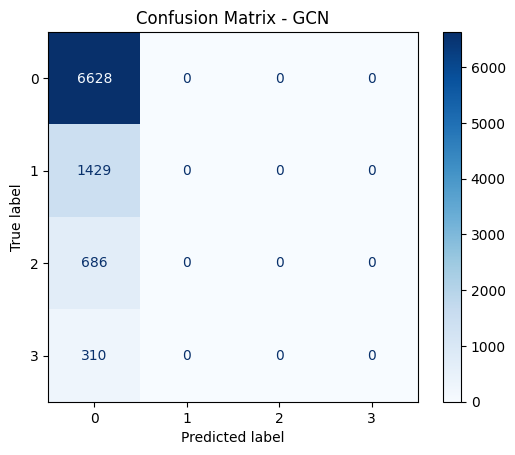

(0.7321329945874295,
 0.6189117388081733,
 GCN(
   (conv1): GraphConv(-1, 64)
   (conv2): GraphConv(-1, 4)
   (dropout_layer): Dropout(p=0.47347098788835285, inplace=False)
 ),
 Data(x=[60348, 10], edge_index=[2, 3439082], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [ ]:
run_experiment_classification(data, 'GCN', hidden_channels=64, lr=0.0018483283285976402, dropout=0.47347098788835285, epochs=200)

[GCN] Epoch 001 | Loss: 34189.2695 | Val Acc: 0.6992 | Val F1: 0.6198
[GCN] Epoch 010 | Loss: 14839.6807 | Val Acc: 0.6112 | Val F1: 0.5889
[GCN] Epoch 020 | Loss: 8267.1514 | Val Acc: 0.5329 | Val F1: 0.5520
[GCN] Epoch 030 | Loss: 6370.2681 | Val Acc: 0.5820 | Val F1: 0.5883
[GCN] Epoch 040 | Loss: 3652.3523 | Val Acc: 0.7068 | Val F1: 0.6194
[GCN] Epoch 050 | Loss: 2368.3560 | Val Acc: 0.6916 | Val F1: 0.6138
[GCN] Epoch 060 | Loss: 3428.2668 | Val Acc: 0.7101 | Val F1: 0.6197
[GCN] Epoch 070 | Loss: 2878.5146 | Val Acc: 0.7043 | Val F1: 0.6317
[GCN] Epoch 080 | Loss: 2012.6921 | Val Acc: 0.6378 | Val F1: 0.6094
[GCN] Epoch 090 | Loss: 2271.8398 | Val Acc: 0.6635 | Val F1: 0.6109
[GCN] Epoch 100 | Loss: 1886.7697 | Val Acc: 0.7180 | Val F1: 0.6322
[GCN] Epoch 110 | Loss: 1410.1654 | Val Acc: 0.7088 | Val F1: 0.6251
[GCN] Epoch 120 | Loss: 3883.1897 | Val Acc: 0.7081 | Val F1: 0.6236
[GCN] Epoch 130 | Loss: 4474.0972 | Val Acc: 0.5914 | Val F1: 0.5987
[GCN] Epoch 140 | Loss: 4120.760

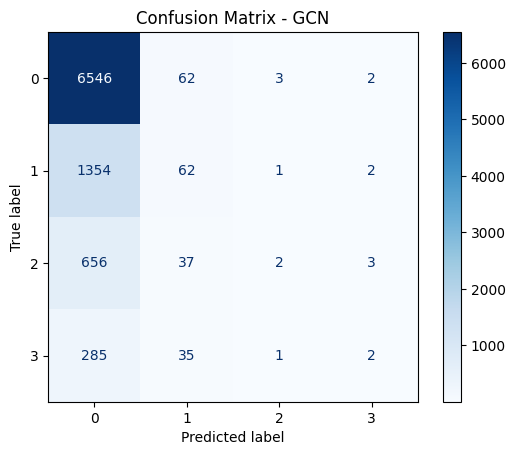

(0.7303656246548106,
 0.6317317420222733,
 GCN(
   (conv1): GraphConv(-1, 64)
   (conv2): GraphConv(-1, 4)
   (dropout_layer): Dropout(p=0.5853674946467203, inplace=False)
 ),
 Data(x=[60348, 10], edge_index=[2, 3439082], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [ ]:
run_experiment_classification(data, 'GCN', hidden_channels=64, lr=0.007284354271228343, dropout=0.5853674946467203, epochs=200)

In [ ]:
#GAT
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GAT', data, args), n_trials=100)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-16 20:21:10,691] A new study created in memory with name: no-name-14b38904-31a7-434f-be6d-5ff756795c48
[I 2025-05-16 20:21:11,507] Trial 0 finished with value: 0.33583738400353513 and parameters: {'hidden_channels': 16, 'lr': 0.0003202631811699673, 'dropout': 0.4584010659459324}. Best is trial 0 with value: 0.33583738400353513.
[I 2025-05-16 20:21:13,205] Trial 1 finished with value: 0.26889085285019887 and parameters: {'hidden_channels': 64, 'lr': 0.007794826361449595, 'dropout': 0.5291187001486286}. Best is trial 1 with value: 0.26889085285019887.
[I 2025-05-16 20:21:14,014] Trial 2 finished with value: 0.26999558108705257 and parameters: {'hidden_channels': 16, 'lr': 0.009420493892678072, 'dropout': 0.4162893777576028}. Best is trial 1 with value: 0.26889085285019887.
[I 2025-05-16 20:21:14,815] Trial 3 finished with value: 0.26889085285019887 and parameters: {'hidden_channels': 16, 'lr': 0.0005247575546803472, 'dropout': 0.3875892545890467}. Best is trial 1 with value: 0


Best trial:
  Value (1 - accuracy): 0.2687
  Best hyperparameters:
    hidden_channels: 64
    lr: 0.005321246337104459
    dropout: 0.43208995381297116


[GAT] Epoch 001 | Loss: 217.3419 | Val Acc: 0.2118 | Val F1: 0.2242
[GAT] Epoch 010 | Loss: 127.6850 | Val Acc: 0.7310 | Val F1: 0.6190
[GAT] Epoch 020 | Loss: 6.4936 | Val Acc: 0.7314 | Val F1: 0.6192
[GAT] Epoch 030 | Loss: 1.4340 | Val Acc: 0.7314 | Val F1: 0.6192
[GAT] Epoch 040 | Loss: 1.2470 | Val Acc: 0.7314 | Val F1: 0.6192
[GAT] Epoch 050 | Loss: 1.0323 | Val Acc: 0.7314 | Val F1: 0.6192
[GAT] Epoch 060 | Loss: 0.9310 | Val Acc: 0.7314 | Val F1: 0.6192
[GAT] Epoch 070 | Loss: 0.9510 | Val Acc: 0.7314 | Val F1: 0.6192
[GAT] Epoch 080 | Loss: 0.9164 | Val Acc: 0.7314 | Val F1: 0.6192
[GAT] Epoch 090 | Loss: 0.9228 | Val Acc: 0.7314 | Val F1: 0.6192
[GAT] Epoch 100 | Loss: 0.9964 | Val Acc: 0.7314 | Val F1: 0.6192
[GAT] Test Acc: 0.7317 | F1: 0.6196
Available explanations: ['node_mask', 'edge_mask']


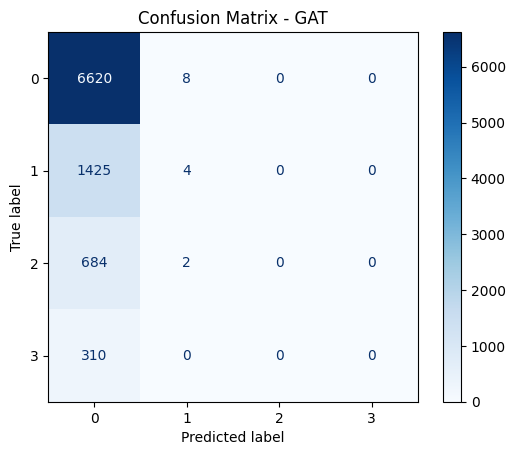

(0.7316911521042748,
 0.6195922141676817,
 GAT(
   (conv1): GATConv((-1, -1), 64, heads=2)
   (conv2): GATConv((-1, -1), 4, heads=1)
 ),
 Data(x=[60348, 10], edge_index=[2, 3439082], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [ ]:
run_experiment_classification(data, 'GAT', hidden_channels=64, lr=0.002738406698751693, dropout=0.530416443255489, epochs=200)

[GAT] Epoch 001 | Loss: 26.0287 | Val Acc: 0.1745 | Val F1: 0.0839
[GAT] Epoch 010 | Loss: 1.6917 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 020 | Loss: 1.0777 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 030 | Loss: 1.1325 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 040 | Loss: 1.0678 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 050 | Loss: 0.9357 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 060 | Loss: 0.9326 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 070 | Loss: 0.9437 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 080 | Loss: 0.9663 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 090 | Loss: 0.9715 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 100 | Loss: 0.9834 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 110 | Loss: 0.9944 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 120 | Loss: 0.9209 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 130 | Loss: 0.9324 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epoch 140 | Loss: 0.9470 | Val Acc: 0.7300 | Val F1: 0.6186
[GAT] Epo

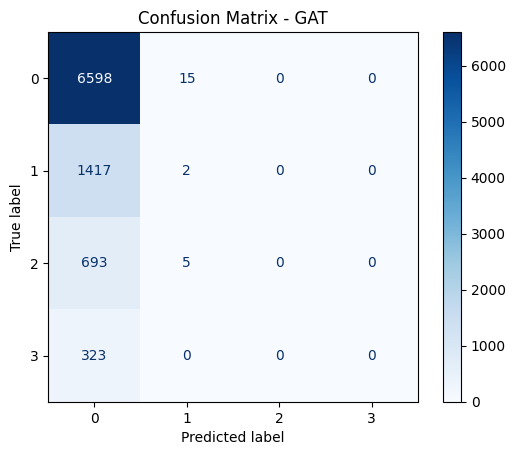

(0.7290400972053463,
 0.6166050291216771,
 GAT(
   (conv1): GATConv((-1, -1), 64, heads=2)
   (conv2): GATConv((-1, -1), 4, heads=1)
 ),
 Data(x=[60348, 10], edge_index=[2, 3439082], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [ ]:
run_experiment_classification(data, 'GAT', hidden_channels=64, lr=0.005321246337104459, dropout=0.43208995381297116, epochs=200)

In [ ]:
#GraphSAGE
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GraphSAGE', data, args), n_trials=100)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-16 20:27:02,362] A new study created in memory with name: no-name-9e57c314-08e3-4ec0-a177-fe1b47cd43cd
[I 2025-05-16 20:27:03,018] Trial 0 finished with value: 0.24292973928413608 and parameters: {'hidden_channels': 64, 'lr': 0.007769833125437229, 'dropout': 0.41455723820882884}. Best is trial 0 with value: 0.24292973928413608.
[I 2025-05-16 20:27:03,444] Trial 1 finished with value: 0.3340698188245692 and parameters: {'hidden_channels': 32, 'lr': 0.00022495753475667042, 'dropout': 0.527483119776653}. Best is trial 0 with value: 0.24292973928413608.
[I 2025-05-16 20:27:04,049] Trial 2 finished with value: 0.269222271321255 and parameters: {'hidden_channels': 64, 'lr': 0.0021506782559864743, 'dropout': 0.3640800525095501}. Best is trial 0 with value: 0.24292973928413608.
[I 2025-05-16 20:27:04,662] Trial 3 finished with value: 0.2421564295183385 and parameters: {'hidden_channels': 64, 'lr': 0.007869161593543344, 'dropout': 0.5758244869928446}. Best is trial 3 with value: 0.24


Best trial:
  Value (1 - accuracy): 0.2359
  Best hyperparameters:
    hidden_channels: 64
    lr: 0.0032180154075386533
    dropout: 0.5868705819243168


[GraphSAGE] Epoch 001 | Loss: 23.5586 | Val Acc: 0.6894 | Val F1: 0.6306
[GraphSAGE] Epoch 010 | Loss: 7.9737 | Val Acc: 0.7390 | Val F1: 0.6795
[GraphSAGE] Epoch 020 | Loss: 4.9360 | Val Acc: 0.7556 | Val F1: 0.7190
[GraphSAGE] Epoch 030 | Loss: 3.2824 | Val Acc: 0.7617 | Val F1: 0.7412
[GraphSAGE] Epoch 040 | Loss: 2.2985 | Val Acc: 0.7534 | Val F1: 0.7251
[GraphSAGE] Epoch 050 | Loss: 1.7581 | Val Acc: 0.7520 | Val F1: 0.7207
[GraphSAGE] Epoch 060 | Loss: 1.4846 | Val Acc: 0.7594 | Val F1: 0.7391
[GraphSAGE] Epoch 070 | Loss: 1.2871 | Val Acc: 0.7655 | Val F1: 0.7334
[GraphSAGE] Epoch 080 | Loss: 1.1675 | Val Acc: 0.7691 | Val F1: 0.7461
[GraphSAGE] Epoch 090 | Loss: 1.0763 | Val Acc: 0.7724 | Val F1: 0.7454
[GraphSAGE] Epoch 100 | Loss: 0.9808 | Val Acc: 0.7768 | Val F1: 0.7482
[GraphSAGE] Test Acc: 0.7701 | F1: 0.7400
Available explanations: ['node_mask', 'edge_mask']


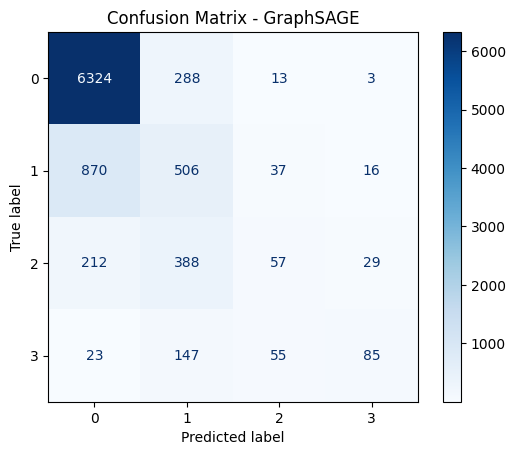

(0.7701314481387386,
 0.7399949157361363,
 GraphSAGE(
   (conv1): SAGEConv((-1, -1), 64, aggr=mean)
   (conv2): SAGEConv((-1, -1), 4, aggr=mean)
 ),
 Data(x=[60348, 10], edge_index=[2, 3439082], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [ ]:
run_experiment_classification(data, 'GraphSAGE', hidden_channels=64, lr=0.0041144142920297114, dropout=0.4841458134881994, epochs=200)

[GraphSAGE] Epoch 001 | Loss: 32.9552 | Val Acc: 0.1382 | Val F1: 0.1220
[GraphSAGE] Epoch 010 | Loss: 10.4677 | Val Acc: 0.7156 | Val F1: 0.6893
[GraphSAGE] Epoch 020 | Loss: 6.0344 | Val Acc: 0.7332 | Val F1: 0.6821
[GraphSAGE] Epoch 030 | Loss: 4.6122 | Val Acc: 0.7509 | Val F1: 0.7000
[GraphSAGE] Epoch 040 | Loss: 3.5060 | Val Acc: 0.7557 | Val F1: 0.7056
[GraphSAGE] Epoch 050 | Loss: 2.8535 | Val Acc: 0.7497 | Val F1: 0.7142
[GraphSAGE] Epoch 060 | Loss: 2.3782 | Val Acc: 0.7472 | Val F1: 0.7158
[GraphSAGE] Epoch 070 | Loss: 1.9905 | Val Acc: 0.7473 | Val F1: 0.7193
[GraphSAGE] Epoch 080 | Loss: 1.6924 | Val Acc: 0.7361 | Val F1: 0.7215
[GraphSAGE] Epoch 090 | Loss: 1.4965 | Val Acc: 0.7384 | Val F1: 0.7274
[GraphSAGE] Epoch 100 | Loss: 1.3180 | Val Acc: 0.7362 | Val F1: 0.7285
[GraphSAGE] Epoch 110 | Loss: 1.1878 | Val Acc: 0.7375 | Val F1: 0.7312
[GraphSAGE] Epoch 120 | Loss: 1.0987 | Val Acc: 0.7412 | Val F1: 0.7335
[GraphSAGE] Epoch 130 | Loss: 1.0127 | Val Acc: 0.7426 | Val F

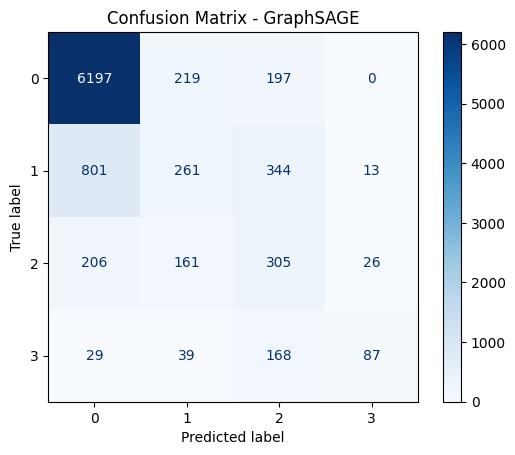

(0.7566552524025185,
 0.7341516283596377,
 GraphSAGE(
   (conv1): SAGEConv((-1, -1), 64, aggr=mean)
   (conv2): SAGEConv((-1, -1), 4, aggr=mean)
 ),
 Data(x=[60348, 10], edge_index=[2, 3439082], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [ ]:
run_experiment_classification(data, 'GraphSAGE', hidden_channels=64, lr=0.0032180154075386533, dropout=0.5868705819243168, epochs=200)

### Run - with platform features

In [ ]:
#GCN
data, node_map = make_graph(df)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GCN', data, args), n_trials=100)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-16 20:31:05,942] A new study created in memory with name: no-name-8e680e67-399d-4086-a005-591d3ffd93f1
[I 2025-05-16 20:31:06,400] Trial 0 finished with value: 0.3614670790985418 and parameters: {'hidden_channels': 32, 'lr': 0.0006089741197488291, 'dropout': 0.40320486157069435}. Best is trial 0 with value: 0.3614670790985418.
[I 2025-05-16 20:31:06,747] Trial 1 finished with value: 0.28733981440565626 and parameters: {'hidden_channels': 16, 'lr': 0.0007307792393102963, 'dropout': 0.5622354626510631}. Best is trial 1 with value: 0.28733981440565626.
[I 2025-05-16 20:31:07,068] Trial 2 finished with value: 0.27231551038444546 and parameters: {'hidden_channels': 16, 'lr': 0.0060850313691391865, 'dropout': 0.39370386218480236}. Best is trial 2 with value: 0.27231551038444546.
[I 2025-05-16 20:31:07,700] Trial 3 finished with value: 0.8035793194874061 and parameters: {'hidden_channels': 64, 'lr': 0.00011163528338796213, 'dropout': 0.4804863556431895}. Best is trial 2 with value:


Best trial:
  Value (1 - accuracy): 0.2723
  Best hyperparameters:
    hidden_channels: 16
    lr: 0.0060850313691391865
    dropout: 0.39370386218480236


[GCN] Epoch 001 | Loss: 40572.5938 | Val Acc: 0.1206 | Val F1: 0.0620
[GCN] Epoch 010 | Loss: 4518.6587 | Val Acc: 0.6995 | Val F1: 0.6074
[GCN] Epoch 020 | Loss: 4306.8115 | Val Acc: 0.7000 | Val F1: 0.6149
[GCN] Epoch 030 | Loss: 1182.5570 | Val Acc: 0.5706 | Val F1: 0.5653
[GCN] Epoch 040 | Loss: 690.2795 | Val Acc: 0.6879 | Val F1: 0.6128
[GCN] Epoch 050 | Loss: 584.5109 | Val Acc: 0.6997 | Val F1: 0.6205
[GCN] Epoch 060 | Loss: 411.1924 | Val Acc: 0.7056 | Val F1: 0.6205
[GCN] Epoch 070 | Loss: 411.1952 | Val Acc: 0.6959 | Val F1: 0.6207
[GCN] Epoch 080 | Loss: 304.8937 | Val Acc: 0.7181 | Val F1: 0.6211
[GCN] Epoch 090 | Loss: 298.3274 | Val Acc: 0.7053 | Val F1: 0.6234
[GCN] Epoch 100 | Loss: 209.5381 | Val Acc: 0.7177 | Val F1: 0.6216
[GCN] Epoch 110 | Loss: 208.5456 | Val Acc: 0.7078 | Val F1: 0.6162
[GCN] Epoch 120 | Loss: 273.3638 | Val Acc: 0.7195 | Val F1: 0.6228
[GCN] Epoch 130 | Loss: 204.4768 | Val Acc: 0.7139 | Val F1: 0.6185
[GCN] Epoch 140 | Loss: 147.9679 | Val Acc:

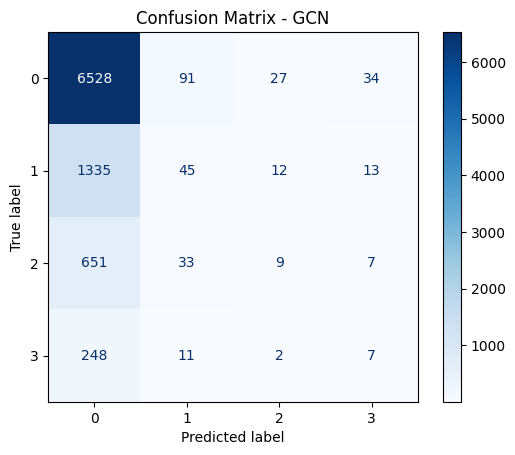

(0.7278250303766707,
 0.6357927934815409,
 GCN(
   (conv1): GraphConv(-1, 16)
   (conv2): GraphConv(-1, 4)
   (dropout_layer): Dropout(p=0.39370386218480236, inplace=False)
 ),
 Data(x=[60348, 21], edge_index=[2, 3439082], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [ ]:
run_experiment_classification(data, 'GCN', hidden_channels=16, lr=0.0060850313691391865, dropout=0.39370386218480236, epochs=200)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GAT', data, args), n_trials=100)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-16 20:33:00,343] A new study created in memory with name: no-name-d8098b00-1fa6-4e2a-b1af-cdc151d09324
[I 2025-05-16 20:33:02,054] Trial 0 finished with value: 0.2725364560318162 and parameters: {'hidden_channels': 64, 'lr': 0.000509148519607406, 'dropout': 0.2348794993222524}. Best is trial 0 with value: 0.2725364560318162.
[I 2025-05-16 20:33:03,198] Trial 1 finished with value: 0.34964648696420686 and parameters: {'hidden_channels': 32, 'lr': 0.00012433098620958491, 'dropout': 0.3591760592569452}. Best is trial 0 with value: 0.2725364560318162.
[I 2025-05-16 20:33:04,893] Trial 2 finished with value: 0.2743040212107821 and parameters: {'hidden_channels': 64, 'lr': 0.003168167282948385, 'dropout': 0.25016647219106053}. Best is trial 0 with value: 0.2725364560318162.
[I 2025-05-16 20:33:06,597] Trial 3 finished with value: 0.8536235086168802 and parameters: {'hidden_channels': 64, 'lr': 0.00023964354842344023, 'dropout': 0.5558858361888517}. Best is trial 0 with value: 0.27


Best trial:
  Value (1 - accuracy): 0.2723
  Best hyperparameters:
    hidden_channels: 64
    lr: 0.004188373829586611
    dropout: 0.302372167813883


[GCN] Epoch 001 | Loss: 72278.2344 | Val Acc: 0.0465 | Val F1: 0.0132
[GCN] Epoch 010 | Loss: 16077.2441 | Val Acc: 0.7229 | Val F1: 0.6146
[GCN] Epoch 020 | Loss: 6367.2935 | Val Acc: 0.6993 | Val F1: 0.6143
[GCN] Epoch 030 | Loss: 3804.0381 | Val Acc: 0.3776 | Val F1: 0.4420
[GCN] Epoch 040 | Loss: 3982.2964 | Val Acc: 0.6680 | Val F1: 0.6062
[GCN] Epoch 050 | Loss: 2749.4438 | Val Acc: 0.5787 | Val F1: 0.5615
[GCN] Epoch 060 | Loss: 1638.1155 | Val Acc: 0.7144 | Val F1: 0.6179
[GCN] Epoch 070 | Loss: 1525.9431 | Val Acc: 0.7235 | Val F1: 0.6141
[GCN] Epoch 080 | Loss: 1273.6534 | Val Acc: 0.6727 | Val F1: 0.6037
[GCN] Epoch 090 | Loss: 1153.0520 | Val Acc: 0.7028 | Val F1: 0.6261
[GCN] Epoch 100 | Loss: 1160.4252 | Val Acc: 0.7160 | Val F1: 0.6213
[GCN] Epoch 110 | Loss: 1428.5975 | Val Acc: 0.7146 | Val F1: 0.6229
[GCN] Epoch 120 | Loss: 1030.8969 | Val Acc: 0.7105 | Val F1: 0.6264
[GCN] Epoch 130 | Loss: 1137.1584 | Val Acc: 0.7171 | Val F1: 0.6233
[GCN] Epoch 140 | Loss: 1883.739

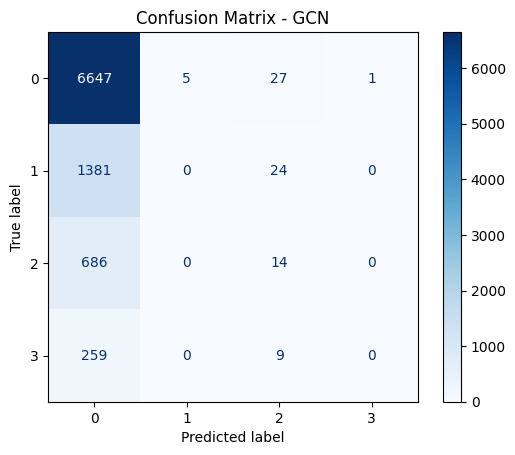

(0.7357781950734563,
 0.629471705716654,
 GCN(
   (conv1): GraphConv(-1, 64)
   (conv2): GraphConv(-1, 4)
   (dropout_layer): Dropout(p=0.302372167813883, inplace=False)
 ),
 Data(x=[60348, 21], edge_index=[2, 3439082], y=[60348], train_mask=[60348], val_mask=[60348], test_mask=[60348]))

In [ ]:
run_experiment_classification(data, 'GCN', hidden_channels=64, lr=0.004188373829586611, dropout=0.302372167813883, epochs=200)

In [ ]:
no_platform_feature = [
    'user_grade', 'user_city_encoded', 'max_difficulty', 'max_days_since_first_login',
    'average_weekly_login_frequency', 'average_hints_usage', 'rolling_login_freq_7d',
    'rolling_mean_hints_usage_10_problems', 'rolling_correctness_ratio_10_problems',
    'rolling_sum_total_attempt_cnt_5_problems', 'problem_number', 'exercise_problem_repeat_session',
            'is_correct', 'is_hint_used', 'is_downgrade', 'is_upgrade'
]
with_platform_feature = [
            'has_teacher_cnt', 'is_self_coach', 'has_student_cnt', 'belongs_to_class_cnt', 'has_class_cnt',
            'user_grade', 'user_city_encoded', 'max_difficulty', 'max_days_since_first_login',
            'average_weekly_login_frequency', 'average_hints_usage', 'rolling_login_freq_7d',
            'rolling_mean_hints_usage_10_problems', 'rolling_correctness_ratio_10_problems',
            'rolling_sum_total_attempt_cnt_5_problems', 'problem_number', 'exercise_problem_repeat_session',
            'is_correct', 'is_hint_used', 'is_downgrade', 'is_upgrade']

### Run - RQ1